# Interpretating forces of 21 Lennard-Jones interacting particles with dNRI+, PyG dataloaders and super-GaussiansMask ignoring the border Rinterior=0.8, two edge types (edge_function + skip) for interaction/no-interaction classification, Super-Gaussian also in encoder, linear in RefMLP, and augmented data by rotations.

This self-contained notebook trains a model to learn to predict trajectories of an LJ gas of 21 particles and extracts the interaction forces. See the dataset creation in the LJ_gas2D_dataset_reflective_circle notebook.

The dataset consist of 21 particles interacting with a Lennard-Jones potential inside a reflective circle.
We use PyG dataloaders with implicit batching and further augment the dataset with rotations.

The model is simplified and optimized from dNRI paper's code.
The model learns the physics of the bulk and is able to predict further in time.
The loss ignores the reflections from the border by considering only an interior defined by R=0.8.
The Gumbel temperature is decreased through the training.

The model unsupervisedly classifies types of interactions based on the full trajectory.
We add a final linear layer to the building block MLP and a learnable super-Gaussian to mask long distance interactions (as a separate module and inside the encoder).

The model is crafted for interpretability, i.e., the edge functions allow extracting the functional form of the forces.

In [6]:
import os, matplotlib.pyplot as plt, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

In [4]:
params = {
 'load_model': None,
 'load_best_model': False,
 'working_dir': '../results/synthLJ_21/LJ_21particles_dnri/seed_1/',
 'gpu': torch.cuda.is_available() and True,
    # data args
 'data_seed': 1, # data loader
 'data_path': '../data/raw/synthLJ_21/',
 'batch_size': 16,
 'val_batch_size': None,
 'test': False,
 'use_data_norm': True,
 'sparse': False,
    # model args
 'model_seed': 1,
 'pred_delta': False,
 'mode': 'train',
 'model_type': 'dnri',
 'num_vars' : 21, # num objects
 'input_node_size' : 2, # input node features: velocities
 'n_bound':0,           #+ boundaries
 'input_edge_size' : 3, # input edge features: d, versor
 'output_size' : 4,
 'input_time_steps' : 50,
 'num_edge_types': 2, # Interaction types: LJ, None
 'prior_num_layers': 3,
 'prior_hidden_size': 128,
 'encoder_hidden': 256,
 'encoder_dropout': 0.0,
 'encoder_bn': True,
 'encoder_mlp_hidden': 128,
 'encoder_mlp_num_layers': 3,
 'encoder_rnn_type': 'lstm',
 'encoder_rnn_hidden': 64,
 'encoder_rnn_num_layers': 1,
 'rnn_hidden': 64,
 'teacher_forcing_prior': False,
 'encoder_normalize_mode': None,
 'decoder_type': 'ref_mlp',
 'decoder_rnn_type': 'gru',
 'decoder_hidden': 256,
 'decoder_hidden_out': 2, #256,
 'decoder_rnn_hidden': None,
 'decoder_msg_hidden': 256,
 'decoder_dropout': 0.0,
 'skip_first': True,
    # loss args
 'nll_loss_type' : 'gaussian',
 'add_uniform_prior': False,  # False = only add learned prior
 'no_edge_prior': 0.9,
 'prior_variance': 5e-05,
 'normalize_kl': True,
 'normalize_kl_per_var': False,
 'normalize_nll': True,
 'normalize_nll_per_var': False,
 'kl_coef': 1.0,
    # train args
 'gumbel_temp': 1.5,
 'continue_training': False,
 'num_epochs': 100, #200,
 'lr': 0.0005,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 100, # 200
 'mom': 0,
 'clip_grad_norm': None,
 'train_hard_sample': True,
      # eval args
 'test_burn_in_steps': 10,
 'error_out_name': 'prediction_errors_%dstep.npy',
 'error_suffix': None,
 'subject_ind': -1,
}

In [5]:
os.makedirs(params['working_dir'], exist_ok=True, )

In [6]:
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print(dvc)

cuda


In [7]:
def non_diagonal_linear_index(n):
    idx = np.arange(n*(n-1))
    row_idx = idx // (n-1)
    col_idx = idx % (n-1)
    col_idx += (col_idx >= row_idx).astype(int)
    return row_idx, col_idx

# # example usage:
row_idx, col_idx = non_diagonal_linear_index(params['num_vars'])
# print(idx,row_idx, col_idx)  # [0, 1, 0, 1]

# Data loading

In [8]:
def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():  torch.cuda.manual_seed_all(seed_val)

In [9]:
def get_dv(data, sparse=True, boundary=False): # data shape= sims,num_particles,T, dim
    assert data.dim()==4, data.dim()
    N = data.shape[1]
    if sparse:
        row_idx, col_idx = s_e.to(data.device), r_e.to(data.device)
    else:
        row_idx, col_idx = non_diagonal_linear_index(N)
    v = data[:,col_idx,:,:2]-data[:,row_idx,:,:2]
    d = torch.sqrt((v*v).sum(-1))[...,None]
    v = v/d
    return torch.cat((d,v),dim=-1)

In [10]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
class SmallSynthDataPyG():
    def __init__(self, data_path, mode, params):
        # paths
        self.data_path = data_path;  self.mode = mode
        if mode in ['train', 'val','test']:
            path = os.path.join(data_path, f'{mode}_feats')
            edge_path = os.path.join(data_path, f'{mode}_edges')

        # load node data into device directly
        self.node_feats = torch.load(path,
                                     map_location=torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                               else 'cpu'))
        # Transpose data: shape=  sims,T,num_particles, dim -> sims,num_particles,T, dim
        self.node_feats = self.node_feats.transpose(1,2).contiguous()
        # take the latest 50 snapshots
        sf = 1
        self.delta_t = 0.0025*10*sf
        self.slice_t = slice_t = slice(-50, None, sf)
        self.node_feats = self.node_feats[:,:,slice_t]
        # normalize data
        self.use_data_norm = params.get('use_data_norm',True)
        if self.use_data_norm:  self._normalize_data()  # self._normalize_symmetric_data

        # get edge features from normalized node features
        with torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                               else 'cpu'):
            self.edge_feats = get_dv(self.node_feats, params['sparse'])

            # set edges
            if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
                send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
            else: # fully connected
                send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
                edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                                      for i in range(params['num_vars'])]),
                                         requires_grad=False)
                self.edge2node_mat = edge2node_mat
        edge_index = torch.stack((send_edges, recv_edges))

        # create Data list containing time series' node and edge feats
        if not params['sparse']:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index, edge2node_mat=edge2node_mat)
                         for n,e in zip(self.node_feats,self.edge_feats)]
        else:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index)
                         for n,e in zip(self.node_feats,self.edge_feats)]

        # load ground truth edges into CPU for comparison-only
        self.edges = torch.load(edge_path)
        # take the latest 50 snapshots
        self.edges = self.edges[:,slice_t]
        if params['sparse']:
            self.edges = self.edges[...,np.concatenate([np.flatnonzero(np.logical_and(row_idx==i.item(), col_idx==j.item())) for i,j in zip(s_e,r_e)])]

    def _normalize_data(self):
        # normalize with the same minmax parameters of the training
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max, self.loc_min = train_data[...,  :2].max(), train_data[...,  :2].min()
        self.vel_max, self.vel_min = train_data[..., 2:4].max(), train_data[..., 2:4 ].min()
        self.norm, self.norm_v = (self.loc_max-self.loc_min)*.5, (self.vel_max-self.vel_min)*.5

        self.node_feats[...,  :2] = (self.node_feats[...,  :2]-self.loc_min) / self.norm  -1
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]-self.vel_min) / self.norm_v-1

    def unnormalize(self, data):
        if self.use_data_norm:
            result1 = (data[...,  :2] + 1) * self.norm   + self.loc_min
            result2 = (data[..., 2:4] + 1) * self.norm_v + self.vel_min
            return torch.concatenate([result1, result2], axis=-1)
        else:
            return data

    def _normalize_symmetric_data(self):
        # normalize with the same abs max parameters of the training
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max = train_data[...,  :2].abs().max()
        self.vel_max = train_data[..., 2:4].abs().max()
        self.norm, self.norm_v = self.loc_max, self.vel_max

        self.node_feats[...,  :2] = (self.node_feats[...,  :2]+self.loc_max) / self.norm  -1.
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]+self.vel_max) / self.norm_v-1.

ds_train = SmallSynthDataPyG(params['data_path'], 'train', params)

In [11]:
bs=16

In [10]:
seed(params['data_seed'])
dl_train = DataLoader(ds_train.datalist, batch_size=bs, shuffle=True, drop_last=True)

In [11]:
ds_valid = SmallSynthDataPyG(params['data_path'], 'val', params)
dl_valid = DataLoader(ds_valid.datalist, batch_size=bs, shuffle=False, drop_last=False)

In [12]:
b = next(iter(dl_train)); b

DataBatch(edge_index=[2, 6720], node_feats=[336, 50, 4], edge_feats=[6720, 50, 3], edge2node_mat=[336, 420], batch=[336], ptr=[17])

In [13]:
# rotate positions and velocities cartesian components and also distance versor

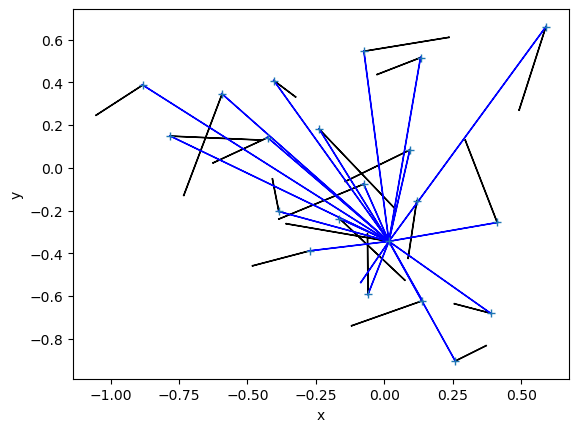

In [397]:
plt.plot(*b.node_feats[:21,0,:2].T.cpu().numpy(),'+');
for i in range(21):
    plt.arrow(*b.node_feats[i,0,:].cpu().numpy());
for j in range(1,21):
    plt.arrow(*b.node_feats[0,0,:2].cpu().numpy(),*(b.edge_feats[j,0,1:]*b.edge_feats[j,0,0:1]).cpu().numpy(), color='b');
plt.gca().set( xlabel='x', ylabel='y');

In [15]:
def rotate_cart_2D(tensor, angle):
    if not isinstance(angle, torch.Tensor): angle = torch.tensor(angle)
    # Create rotation matrix
    rotation_matrix = torch.tensor([[torch.cos(angle), -torch.sin(angle)],
                                    [torch.sin(angle),  torch.cos(angle)]],
                                  device=tensor.device)

    # If tensor is on CUDA, move rotation matrix to CUDA
    # if tensor.is_cuda:    rotation_matrix = rotation_matrix.cuda()

    # Split tensor into positions and velocities
    if tensor.shape[-1]==4:
        # Concatenate rotated positions and velocities
        rotated_tensor = torch.cat((torch.matmul(tensor[..., :2], rotation_matrix),
                                    torch.matmul(tensor[..., 2:], rotation_matrix)),
                                   dim=-1)  # Shape: (B, 4)
    else:
        rotated_tensor = torch.matmul(tensor, rotation_matrix)
    return rotated_tensor

In [16]:
rot = rotate_cart_2D(b.node_feats, 3.)
rot_e = torch.cat([b.edge_feats[...,0:1],
                  rotate_cart_2D(b.edge_feats[...,1:], 3.)], dim=-1)

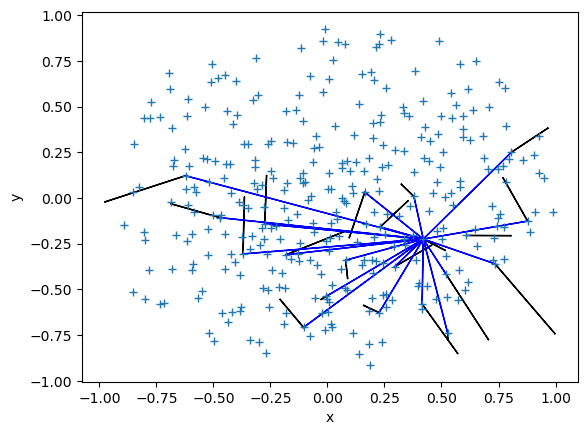

In [398]:
plt.plot(*rot[...,0,:2].T.cpu().numpy(),'+');
for i in range(21):
    plt.arrow(*rot[i,0,:].cpu().numpy());
for j in range(1,21):
    plt.arrow(*rot[0,0,:2].cpu().numpy(),*(rot_e[j,0,1:]*rot_e[j,0,0:1]).cpu().numpy(), color='b');
plt.gca().set( xlabel='x', ylabel='y');

In [18]:
b.edge_index

tensor([[  0,   0,   0,  ..., 335, 335, 335],
        [  1,   2,   3,  ..., 332, 333, 334]], device='cuda:0')

In [19]:
b.ptr

tensor([  0,  21,  42,  63,  84, 105, 126, 147, 168, 189, 210, 231, 252, 273,
        294, 315, 336], device='cuda:0')

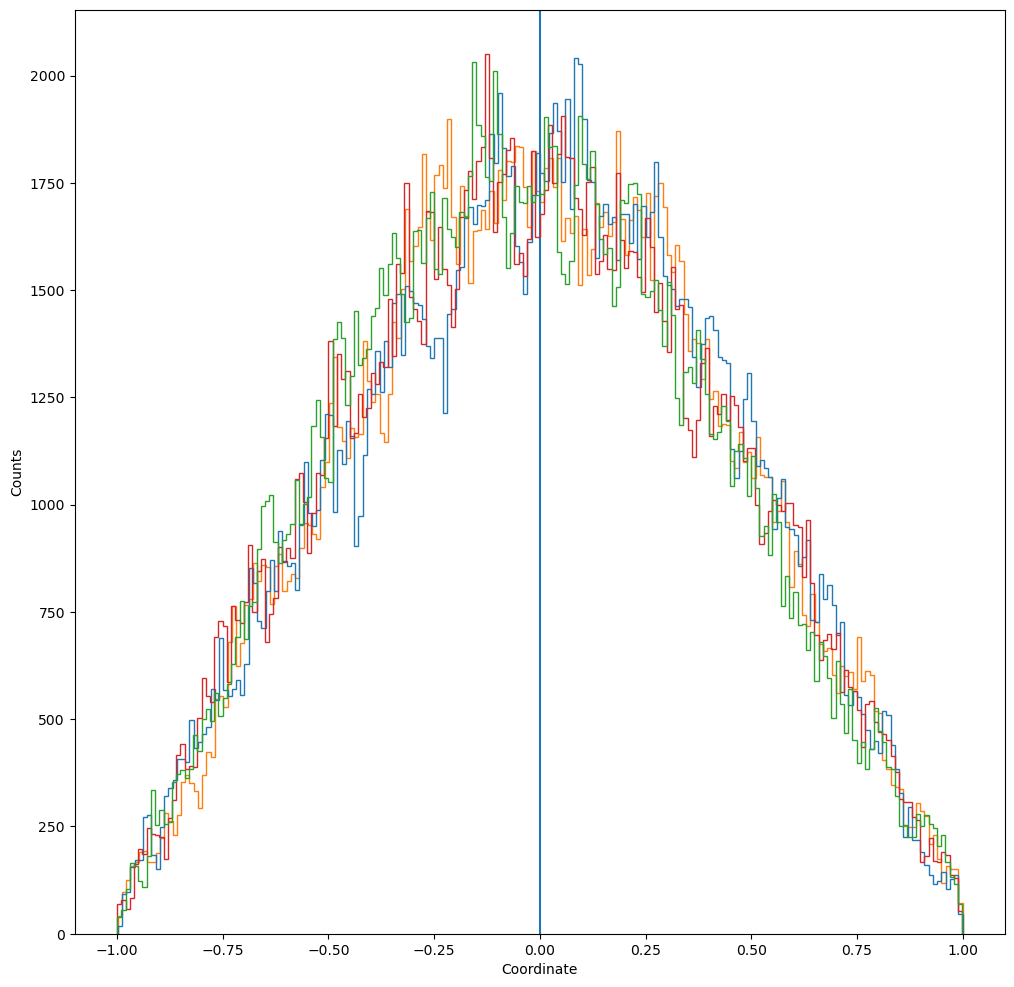

In [400]:
plt.figure(figsize=(12,12))
plt.hist(ds_train.node_feats[...,:2].reshape(-1,2).cpu(),200, histtype='step');
plt.axvline(0);
plt.hist(ds_valid.node_feats[...,:2].reshape(-1,2).cpu(),200, histtype='step');
plt.gca().set( xlabel='Coordinate', ylabel='Counts');

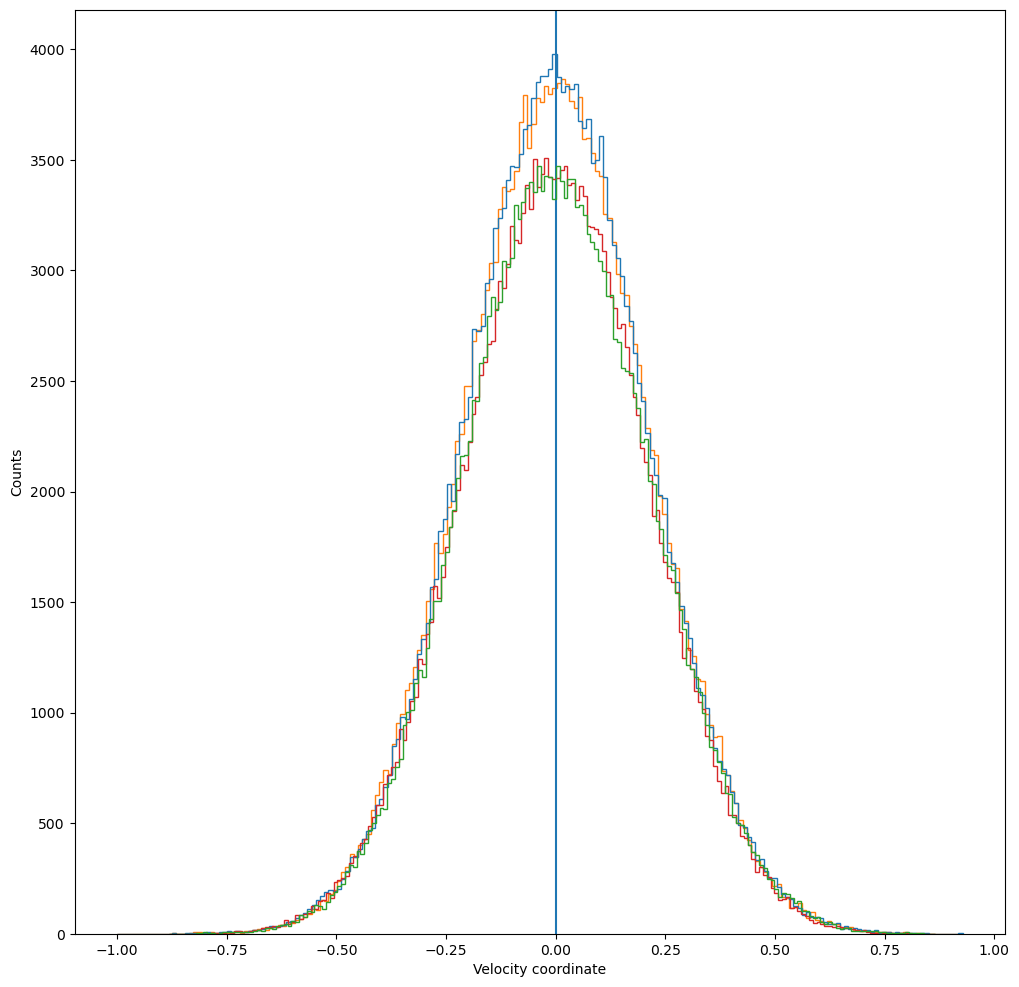

In [401]:
plt.figure(figsize=(12,12))
plt.hist(ds_train.node_feats[...,2:4].reshape(-1,2).cpu(),200, histtype='step');
plt.axvline(0);
plt.hist(ds_valid.node_feats[...,2:4].reshape(-1,2).cpu(),200, histtype='step');
plt.gca().set( xlabel='Velocity coordinate', ylabel='Counts');

## look at data

In [36]:
n = ds_train.node_feats[:][0].shape[0]
n

21

In [43]:
feats = ds_train.node_feats[:].cpu(); feats.shape

torch.Size([200, 21, 50, 4])

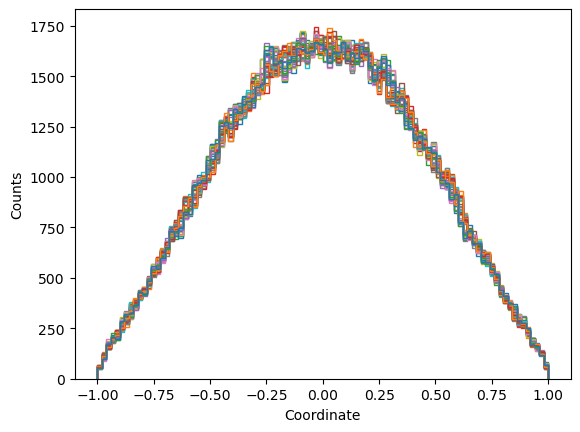

In [402]:
plt.hist(feats[:,:,:,:2].reshape(-1,2*n).numpy(), 100, histtype='step');
plt.gca().set( xlabel='Coordinate', ylabel='Counts');

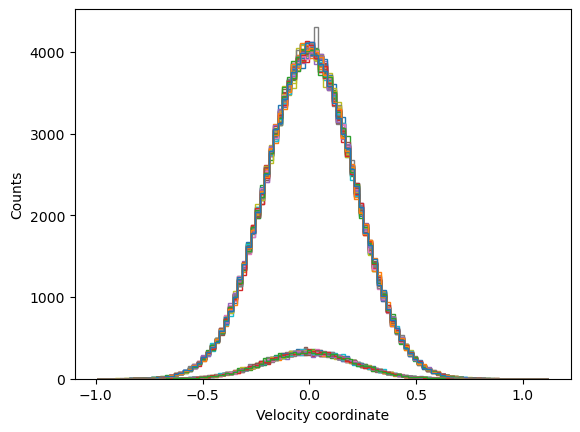

In [403]:
plt.hist(feats[:,:,:,2:].reshape(-1,2*n).numpy(), 100, histtype='step');
plt.hist(ds_valid.node_feats[:][:,:,:,2:].reshape(-1,2*n).cpu().numpy(), 100, histtype='step');
plt.gca().set( xlabel='Velocity coordinate', ylabel='Counts');

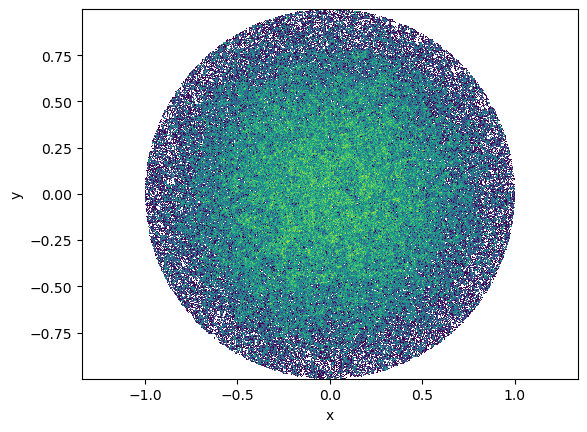

In [404]:
plt.hist2d(feats[:,:,0:n,0].reshape(-1).numpy(),
           feats[:,:,0:n,1].reshape(-1).numpy(), 500, norm='log');
plt.gca().axis('equal')
plt.gca().set( xlabel='x', ylabel='y');

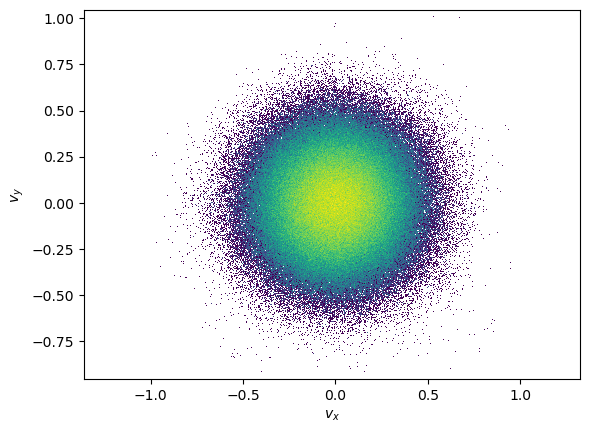

In [405]:
plt.hist2d(feats[:,:,0:n,2].reshape(-1).numpy(),
           feats[:,:,0:n,3].reshape(-1).numpy(), 500, norm='log');
plt.gca().axis('equal');
plt.gca().set( xlabel=r'$v_x$', ylabel=r'$v_y$');

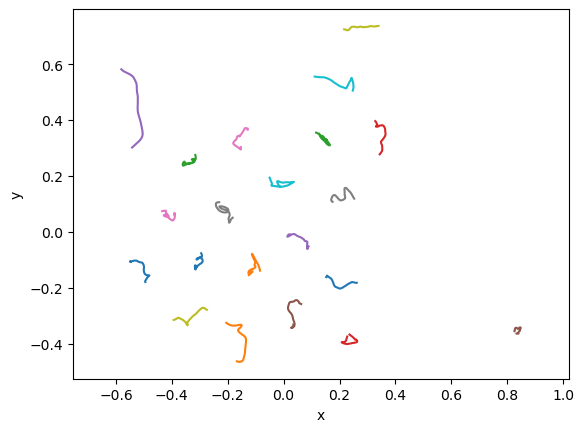

In [406]:
i=0#i+=1
for j in range(n):
    plt.plot(*feats[i,j,:,:2].cpu().T);
plt.gca().axis('equal')
plt.gca().set( xlabel='x', ylabel='y');

In [407]:
print( f"{((ds_train.edges[:,1:]==0)*1.).mean()*100:.2g}% of non-interacting edges")

70% of non-interacting edges


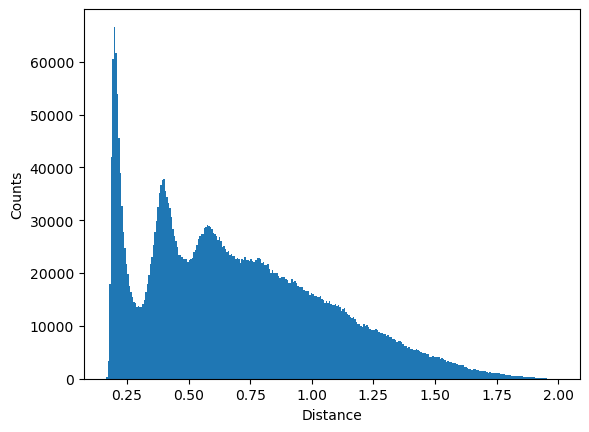

In [408]:
plt.hist(ds_train.edge_feats[...,0].reshape(-1).cpu().numpy(),300);
plt.gca().set( xlabel='Distance', ylabel='Counts');

## How to determine interior? R < maximum bounce from boundary

In [688]:
path = os.path.join(params['data_path'],f'train_feats')
# load node data into device directly
sf = 1
slice_t = slice(None, None, sf)
node_feats = torch.load(path,
                         map_location=torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                   else 'cpu'))[:,slice_t].transpose(2,1)

In [689]:
circle_radius = 6.134981116414218-0.5  # 5.6347
delta_t = 0.0025*10*sf
circle_center = np.zeros(2)
mask = torch.linalg.norm(node_feats[:,:,:-1,:2]+node_feats[:,:,:-1,2:4]/
              torch.linalg.norm(node_feats[:,:,:-1,2:4],axis=-1, keepdims=True)*
              torch.linalg.norm(node_feats[:,:,1:,2:4],axis=-1, keepdims=True)*
                         delta_t
              ,axis=-1)>circle_radius
idx = torch.nonzero(mask)

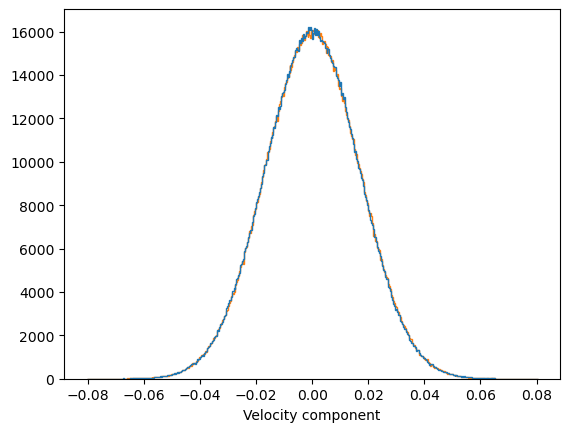

In [704]:
plt.hist(node_feats[:,:,:,2:].reshape(-1,2).cpu().numpy()*delta_t,500, histtype='step', );
plt.xlabel('Velocity component');

In [691]:
mask.shape, idx.shape, node_feats[:,:,:-1,:2].shape

(torch.Size([200, 21, 499]),
 torch.Size([1909, 3]),
 torch.Size([200, 21, 499, 2]))

In [692]:
idx_ = idx+torch.tensor([[0,0,1]], device=idx.device)

In [693]:
assert (idx_[:,-1]>=500).sum()==0

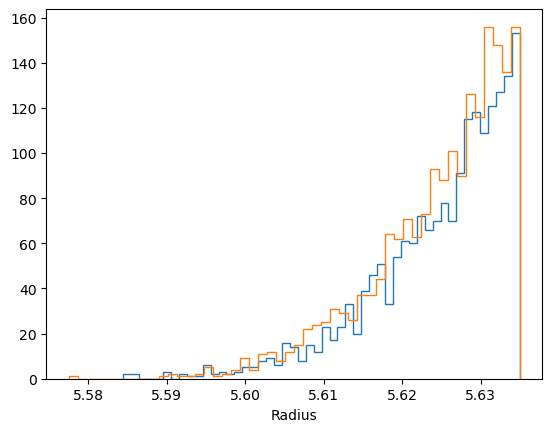

In [696]:
plt.hist(torch.linalg.norm(node_feats[:,:,:-1,:2][mask],axis=-1).cpu().numpy(),50, histtype='step');
plt.hist(torch.linalg.norm(node_feats[:,:,:,:2][*(idx_).T],axis=-1).cpu().numpy(),50, histtype='step');
plt.xlabel('Radius');

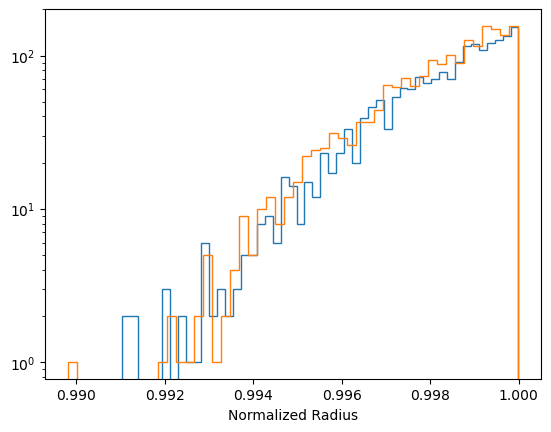

In [697]:
plt.hist(torch.linalg.norm(node_feats[:,:,:-1,:2][mask],axis=-1).cpu().numpy()/circle_radius,50, histtype='step', log=True);
plt.hist(torch.linalg.norm(node_feats[:,:,:,:2][*(idx_).T],axis=-1).cpu().numpy()/circle_radius,50, histtype='step');
plt.xlabel('Normalized Radius');

In [703]:
# take the maximum velocity and suppose it starts from the border
# then that radius is save
vmax = torch.linalg.norm(node_feats[...,2:4],axis=-1).max()
Rinterior = (1. - vmax*delta_t/circle_radius).item()
print(f'{Rinterior=:.3g}')

Rinterior=0.984


# Model

In [12]:
def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            m.bias.data.fill_(0.1)
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()

def set_dropout(self,p):
    for m in self.modules():
        if isinstance(m, nn.Dropout):
            m.p = p

In [13]:
class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., use_bn=True):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True),
            nn.Linear(n_out,n_out)  # <--linear at the end gives full range
        )
        self.bn = nn.BatchNorm1d(n_out) if use_bn else None

        init_weights(self)

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        return self.batch_norm(x) if self.bn is not None else x

In [12]:
# from torch.nn.functional import gumbel_softmax

In [352]:
# redefine gumbel_softmax to avoid Gumbel noise in the inference
# effectively sampling from a categorical distribution
from torch.overrides import (
    handle_torch_function,
    has_torch_function_unary,
)
import warnings
import torch
def gumbel_softmax (
    logits: torch.Tensor,
    tau: float = 1,
    hard: bool = False,
    eps: float = 1e-10,
    dim: int = -1,
    training: bool = True,
) -> torch.Tensor:
    if has_torch_function_unary(logits):
        return handle_torch_function(
            gumbel_softmax, (logits,), logits, tau=tau, hard=hard, eps=eps, dim=dim
        )
    if eps != 1e-10:
        warnings.warn("`eps` parameter is deprecated and has no effect.")

    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    if training:
        gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    else:
        gumbels = logits / tau
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

## Learnable super-Gaussian

In [15]:
def getattrs(o,l): return *[getattr(o,n) for n in l],

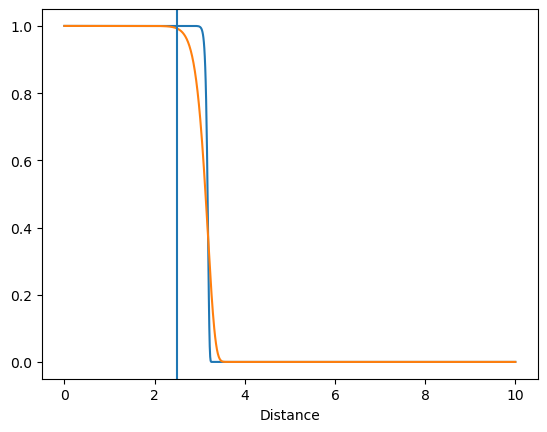

In [16]:
x = torch.linspace(0,10,1000)/ds_train.norm
sigma = torch.tensor(.4)
beta = torch.tensor(50)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))));
beta = torch.tensor(10)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))));
plt.axvline(2.5);
plt.gca().set( xlabel='Distance');

In [17]:
# modified from https://github.com/DeepTrackAI/deeplay/blob/develop/deeplay/components/gnn/mpn/ldw.py#L9
class LearnableDistanceMask(nn.Module):
    def __init__(
        self,
        C: int,  # number of classes (-1 if skip_first)
        sigma: list[float] = [.4],
        beta:  list[float] = [10.],
        sigma_limit  = [1e-3, .4],
        beta_limit   = [1.,   100.],
        skip_first   = True,
    ):
        super().__init__()

        self.C = C
        self.sigma_limit = sigma_limit
        self.beta_limit  = beta_limit
        self.skip_first = skip_first

        self.sigma = nn.Parameter(torch.tensor(sigma*C if len(sigma)==1 else sigma))
        self.beta  = nn.Parameter(torch.tensor(beta*C  if len(beta)==1 else beta))
        assert len(self.sigma)==C
        assert len(self.beta) ==C

    def forward(self, distance  # BE, 1
               ):
        sigma = torch.clamp(self.sigma, *self.sigma_limit)
        beta  = torch.clamp(self.beta,  *self.beta_limit)
        if self.skip_first:
            edge_weights = torch.zeros(*distance.shape[:-1],self.C+1,
                                       device=distance.device)
            edge_weights[...,1:] = torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta))  # BE,C-1
            return edge_weights  # [BE, C]
        else:
            return torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta))  # BE,C

## Encoder

In [18]:
class DNRI_Encoder(nn.Module):
    def __init__(self, params,**kwargs):
        super(DNRI_Encoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.num_edges = params['num_edge_types']  # 2
        self.skip_first = skip_first = params['skip_first']  # True
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat']
        self.separate_prior_encoder = params.get('separate_prior_encoder', False) #
        use_bn = params['encoder_bn']
        dropout = params['encoder_dropout']  # 0

        if 'super_G' in kwargs: self.super_G = kwargs['super_G']

        inp_node_size = params['input_node_size']    #  4
        n_bound = params.get('n_bound',0)
        inp_edge_size = params['input_edge_size']
        hidden_size = params['encoder_hidden']  # 256
        rnn_hidden_size = params['encoder_rnn_hidden']  # 64
        if rnn_hidden_size is None:  rnn_hidden_size = hidden_size
        self.rnn_hidden_size = rnn_hidden_size
        rnn_type = params['encoder_rnn_type']  # 'lstm'
        self.rnn_num_layers = rnn_num_layers = params.get('encoder_rnn_num_layers', 1)

        self.mlp1 = RefNRIMLP(inp_node_size*2, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp1_e = RefNRIMLP(params['num_edge_types'],
                                hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp2 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp3 = RefNRIMLP(  hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp4 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)

        if rnn_type == 'lstm': # True
            self.bi_rnn = nn.LSTM(hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)
        elif rnn_type == 'gru':
            self.bi_rnn = nn.GRU (hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)

        # encoder out
        out_hidden_size = 2*rnn_hidden_size  # 128
        num_layers = params['encoder_mlp_num_layers']  # 3
        if num_layers == 1: # False
            self.encoder_fc_out = nn.Linear(out_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['encoder_mlp_hidden'] # 128
            layers = [nn.Linear(out_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.encoder_fc_out = nn.Sequential(*layers)

        # prior out
        num_layers = params['prior_num_layers'] # 3
        if num_layers == 1: # False
            self.prior_fc_out = nn.Linear(rnn_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['prior_hidden_size'] # 128
            layers = [nn.Linear(rnn_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.prior_fc_out = nn.Sequential(*layers)

        init_weights(self)

    def node2edge(self, node_embeddings, edge_index):
        # Input size: [batch*num_vars, num_timesteps, embed_size]
        return torch.cat([node_embeddings[edge_index[0]],
                          node_embeddings[edge_index[1]]],
                         dim=-1)

    def edge2node(self, edge_embeddings, BN,  # [batch*num_edges, timesteps, embed_size]
                  edge_index=None, sparse=True):
        # BN is Batch*Nodes_num not edges
        old_shape = edge_embeddings.shape
        device = next(self.parameters()).device
        node_aggregate = torch.zeros((BN, *old_shape[1:]), # B*N, T, H
                                     device=device)
        if sparse:
            if len(edge_embeddings.shape) == 3:
                node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1,1).expand(-1, *old_shape[1:]),
                                     src=edge_embeddings,)
            else: # single_timestep
                 node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1).expand(-1, old_shape[-1]),
                                     src=edge_embeddings,)
        else: # fully connected
            if len(edge_embeddings.shape) == 3:
                tmp_embeddings = edge_embeddings.view(old_shape[0], old_shape[1], -1)
                node_aggregate = torch.matmul(self.edge2node_mat, tmp_embeddings).view(old_shape[0], -1, *old_shape[2:])
            else:
                node_aggregate = torch.matmul(self.edge2node_mat, edge_embeddings)
        return node_aggregate/(self.num_vars-1)

    def forward(self,
                node_feats,
                edge_feats,
                edge_index,
               ):
        # Inputs is shape [batch*num_vars, num_timesteps,  input_size]
        x = node_feats  # B*N, T, 2
        BN = node_feats.shape[0]
        num_timesteps = node_feats.size(1)
        # x = node_feats.transpose(-3, -2).contiguous()  # already done in dataset creation
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, 2H
        x_ = self.mlp1_e(self.super_G(edge_feats[...,0:1])) # B*E, T, H <- distance
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, T, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, T, 2H
        x = self.mlp3(x)                                    # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, T, 2H
        x = self.mlp4(x)                                    # B*E, T, H


        # At this point, x should be [batch*num_edges, num_timesteps, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, T, H
        # x = x.contiguous().view(-1, *old_shape[-2:]) # B*E, T, H # already done with implicit batching
        # forward_x, prior_state = self.forward_rnn(x)
        # timesteps = old_shape[2]
        # reverse_x = x.flip(1)
        # reverse_x, _ = self.reverse_rnn(reverse_x)
        # reverse_x = reverse_x.flip(1)
        # equivalent to bilstm

        x, (h, c) = self.bi_rnn(x)  # B*E, T, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,T,H
        prior_state = (h,c) # h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (D*num_layers, B*E,H)

        #x: [batch*num_edges, num_timesteps, hidden_size]
        prior_result = self.prior_fc_out(forward_x)  # B*E,T,C
        #.view(*old_shape[:-1], self.num_edges).transpose(-3,-2).contiguous()
        # combined_x = torch.cat([forward_x, reverse_x], dim=-1)
        encoder_result = self.encoder_fc_out(x)  # B*E,T,C
        #.view(*old_shape[:-1], self.num_edges).transpose(-3,-2).contiguous()
        return prior_result, encoder_result, prior_state
                # B*E, T, C

    def single_step_forward(self,
                            node_feats,
                            edge_feats,
                            edge_index,
                            prior_state):
        # Inputs is shape [batch*num_vars, input_size]
        x = node_feats
        BN = node_feats.shape[0]
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, 2H
        x_ = self.mlp1_e(self.super_G(edge_feats[...,0:1]))#.transpose(-3, -2).contiguous()) # B*E, H
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, 2H
        x = self.mlp3(x)                                    # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, 2H
        x = self.mlp4(x)                                    # B*E, H


        # At this point, x should be [batch*num_edges, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, H
        x  = x.contiguous().view(-1, 1, old_shape[-1])   # B*E, 1, H


        x, (h, c) = self.bi_rnn(x,prior_state)  # B*E, 1, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,1,H
        prior_state = (h, c) #h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (num_layers, B*E,H)
        prior_result = self.prior_fc_out(forward_x).view(*old_shape[:-1], self.num_edges).contiguous() # B*E, C

        return prior_result, prior_state

## Decoder

In [19]:
class DNRI_MLP_Decoder(nn.Module):   # this is the Markovian decoder
    def __init__(self, params, **kwargs):
        super(DNRI_MLP_Decoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.pred_delta = params.get('pred_delta',False)
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat'].T
        edge_types = params['num_edge_types']  # 2
        self.n_bound = params.get('n_bound',0)
        n_hid   = params['decoder_hidden']  # 256
        msg_hid = params['decoder_hidden']  # 256
        self.msg_out_size = msg_out = params['decoder_hidden_out'] # 2
        self.skip_first_edge_type = skip_first = params['skip_first']  # True
        inp_node_size  = n_in_node = params['input_node_size']  # 4
        inp_edge_size  = params['input_edge_size']  # 4
        out_size = params['output_size']
        self.dropout_prob = do_prob = params['decoder_dropout']  # 0.0

        self.edge_functions = nn.ModuleList([
            nn.Sequential(nn.Linear(1, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(msg_hid, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(  msg_hid, msg_out) # <-- msg_out = d for interpretability
                          # ,nn.ReLU() # <-- key to learn
                         )   # (B,E,O)
            for _ in range(edge_types if not skip_first else edge_types -1)
        ])
        self.node_function = nn.Sequential(
            nn.Linear(inp_node_size + msg_out+self.n_bound, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, out_size))

        print('Using learned interaction net decoder.')


    def get_initial_hidden(self, inputs):  return None

    def forward(self, inputs,  # BN,F; BE,V; 2,BE
                hidden,
                edges,         # BE,C
               ):
        # TODO: hidden is not used!! So, it can handle all times at once.
        node_feats_, edge_feats, edge_index = inputs
        # BN,F;      BE,V;       2,BE
        node_feats = node_feats_[...,2:]  # BE,2; # velocities

        # Node2edge
        pre_msg = edge_feats[...,0:1]  # (B*E,1) # distances

        all_msgs = torch.zeros(pre_msg.size(0),self.msg_out_size,   # (B*E,O)
                               device=node_feats.device)

        # To exlude one edge type, simply offset range by 1
        start_idx = 1 if self.skip_first_edge_type else 0

        norm = 1  # TODO sqrt(E)
        # Run separate MLP for every edge type
        for i in range(len(self.edge_functions)):
            msg = self.edge_functions[i](pre_msg)*edge_feats[...,1:]
            msg = msg*edges[..., i+start_idx:i+start_idx+1]  # <-- Encoder z edges predictions
            # normed sum message from one edge type into all messages
            all_msgs += msg/norm     # (B*E,O)

        # Aggregate all msgs to receiver
        if self.sparse:
            agg_msgs = torch.zeros(node_feats.shape[0], all_msgs.shape[-1], #  B*N, H
                              device=all_msgs.device
                         ).scatter_add(
                             dim=0, # node dimension
                             index=edge_index[1].view(-1,1).expand(-1, all_msgs.shape[-1]), # repeat for each feature
                             src=all_msgs,)  # [BN, H]
        else:
            all_msgs = all_msgs.reshape(-1,self.edge2node_mat.shape[0],all_msgs.shape[-1])
            agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1)
            agg_msgs = agg_msgs.reshape(-1,agg_msgs.shape[-1])

        agg_msgs = agg_msgs.contiguous()   # (B*N,O)

        # Skip connection (only velocities)
        aug_inputs = torch.cat([node_feats, agg_msgs], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        pred = self.node_function(aug_inputs)   # B*N,O

        # Predict position/velocity difference
        return (node_feats_ + pred, None) if not self.pred_delta else (pred, None)

## dNRI

In [353]:
from torch_geometric.utils import to_dense_batch
class DNRI(nn.Module):
    def __init__(self, params, **kwargs):
        super(DNRI, self).__init__()
        self.sparse = sparse = params['sparse']
        # Model Params
        self.num_vars = params['num_vars']  # 21
        self.pred_delta = params.get('pred_delta',False)

        self.num_edges = params['num_edge_types']  # 3
        self.num_edge_types = params.get('num_edge_types')  # 2

        self.skip_first = skip_first = params['skip_first']  # True
        self.Rbox = torch.tensor(params.get('Rbox', 3.0), device=dvc)
        self.n_bound = params.get('n_bound',0)

        self.use_supergaussian = params.get('use_supergaussian', True)
        if self.use_supergaussian:
            self.super_gaussians = LearnableDistanceMask(C=self.num_edges-1 if skip_first else self.num_edges,
                                                          skip_first=skip_first)
            self.encoder = DNRI_Encoder(params,super_G=self.super_gaussians) if self.sparse else DNRI_Encoder(params, super_G=self.super_gaussians,**kwargs)
        else:
            self.encoder = DNRI_Encoder(params,) if self.sparse else DNRI_Encoder(params, **kwargs)
        decoder_type = params.get('decoder_type', None)  # ref_mlp
        if decoder_type == 'ref_mlp':
            self.decoder = DNRI_MLP_Decoder(params, ) if self.sparse else DNRI_MLP_Decoder(params, **kwargs)
        else:
            # recurrent decoder with hidden state
            self.decoder = DNRI_Decoder(params,) if self.sparse else DNRI_Decoder(params, **kwargs)

        # Training params
        self.gumbel_temp = params.get('gumbel_temp')  # 0.5
        self.train_hard_sample = params.get('train_hard_sample')  # False
        self.teacher_forcing_steps = params.get('teacher_forcing_steps', -1)  # -1

        self.normalize_kl = params.get('normalize_kl', False)  # True
        self.normalize_kl_per_var = params.get('normalize_kl_per_var', False) # False
        self.normalize_nll = params.get('normalize_nll', False)  # True
        self.normalize_nll_per_var = params.get('normalize_nll_per_var', False) # False
        self.kl_coef = params.get('kl_coef', 1.)  # 1.0
        self.prior_coef = params.get('prior_coef', 1.)
        self.nll_loss_type = params.get('nll_loss_type', 'crossent')  # gaussian
        self.prior_variance = params.get('prior_variance')   # 5e-05
        self.timesteps = params.get('timesteps', 0)  #
        self.burn_in_steps = params.get('train_burn_in_steps') #
        self.teacher_forcing_prior = params.get('teacher_forcing_prior', False) # False
        self.val_teacher_forcing_steps = params.get('val_teacher_forcing_steps', -1) # -1
        self.add_uniform_prior = params.get('add_uniform_prior')
        # loss params
        self.Rinterior = params.get('Rinterior', 0.8)

        if self.add_uniform_prior:
            if params.get('no_edge_prior') is not None: # 0.9
                prior = torch.full((self.num_edge_types,),(1 - params['no_edge_prior'])/(self.num_edge_types - 1)) # 0.1/1
                prior[0] = params['no_edge_prior'] # 0.9
                log_prior = torch.log(prior) # log([0.9,0.1])
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior
                print("USING NO-EDGE PRIOR: ",prior, self.log_prior) # <-----
            else:
                print("USING UNIFORM PRIOR")
                prior = torch.full((self.num_edge_types,), 1.0/self.num_edge_types)
                log_prior = torch.log(prior)
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior

    def single_step_forward(self, inputs, # BN,F; BE,V; 2,BE
                            decoder_hidden,
                            edge_logits,  # BE,C
                            hard_sample):
        # sample edges at each timestep
        edges = gumbel_softmax(edge_logits,
                               tau=self.gumbel_temp,
                               hard=hard_sample,
                               training=self.training,
                              )  # BE,C
        # mask with learnable supergaussian based on distance
        mask_type = self.super_gaussians(inputs[1][...,0:1])  # distance
        edges = edges * mask_type  # zero-out type of edges beyond distance
        predictions, decoder_hidden = self.decoder(inputs, decoder_hidden, edges)  # BN,O; None
        return predictions, decoder_hidden, edges

    def forward(self, inputs, is_train=False, teacher_forcing=True,
                      return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1)
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample  # False
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1], edge_feats[:,:-1], edge_index)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_p_logits = posterior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,
                                                                          decoder_hidden,
                                                                          current_p_logits,
                                                                          hard_sample)
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1)  # BN,T-1,O
        all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
        return posterior_logits, prior_logits, all_predictions, all_edges
               # BE,T-1,C;       BE,T-1,C;     # BN,T-1,O

    def calculate_loss(self, inputs, is_train=False, teacher_forcing=True,
                       return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        # BN,T,F;   BE,T,V;     2,BE
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1) # T
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        # BE,T-1,C;     BE,T-1,C;          2*(D*num_layers, BE,H)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)  # BN,F; BE,V; 2,BE
            current_p_logits = posterior_logits[:, step]  # BE,C
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,  # BN,F; BE,V; 2,BE
                                                                          decoder_hidden,
                                                                          current_p_logits, # BE,C
                                                                          hard_sample)
            # BN,O; None; BE,C
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1) # BN,T-1,O

        target = node_feats[:, 1:,] if not self.pred_delta else node_feats[...,2:].diff(dim=1) # BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        posterior_prob = F.softmax(posterior_logits, dim=-1)  # BE,T-1,C
        loss_kl = self.kl_categorical_learned(posterior_prob, prior_logits) # 1
        if self.add_uniform_prior:  # True
            loss_kl = 0.5*loss_kl + 0.5*self.prior_coef*self.kl_categorical_avg(posterior_prob)   # 1
        loss = loss_nll + self.kl_coef*loss_kl  # 1
        loss = loss.mean()  # 1

        if return_edges: # False
            all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
            return loss, loss_nll, loss_kl, all_edges, all_predictions
        elif return_logits:  # True <-----------
            return loss, loss_nll, loss_kl, posterior_logits, all_predictions
        else:
            return loss, loss_nll, loss_kl

    def calculate_baseloss(self, inputs,):
        node_feats = inputs['node_feats']
        # BN,O; None; BE,C
        all_predictions = node_feats[:, :-1,:-1]
        target = node_feats[:, 1:,:-1]# BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        return loss_nll#, loss_kl

    def predict_future(self, inputs, prediction_steps, return_edges=False, return_everything=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        burn_in_timesteps = node_feats.size(1)
        decoder_hidden = self.decoder.get_initial_hidden(node_feats)
        all_predictions = []
        all_edges = []
        prior_logits, _, prior_hidden = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        for step in range(burn_in_timesteps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_edge_logits = prior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            if return_everything:
                all_edges.append(edges)
                all_predictions.append(predictions)
        # compute distances of predictions
        predictions = node_feats[:, burn_in_timesteps-1]  # BN, F
        for step in range(prediction_steps):
            pred_,mask = to_dense_batch(predictions, inputs.batch)# B,N,F
            pred_edge_feats = get_dv(pred_.unsqueeze(2), self.sparse)
            pred_edge_feats = pred_edge_feats.squeeze().reshape(-1,3)
            current_inputs = (predictions, pred_edge_feats, edge_index)
            current_edge_logits, prior_hidden  = self.encoder.single_step_forward(*current_inputs, prior_hidden)
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            all_predictions.append(predictions)
            all_edges.append(edges)
            # add distance to boundary feature to predictions
            if self.n_bound !=0:
                d_boundary = distance_to_boundary(predictions[...,:2], R=1.)  # interior|0->1|boundary
                predictions = torch.cat((predictions,d_boundary),dim=-1)

        predictions = torch.stack(all_predictions, dim=1)
        if return_edges:
            edges = torch.stack(all_edges, dim=1)
            return predictions, edges
        else:
            return predictions

    def nll(self, preds, target):
        if self.nll_loss_type == 'crossent':
            return self.nll_crossent(preds, target)
        elif self.nll_loss_type == 'gaussian':
            return self.nll_gaussian(preds, target)
        elif self.nll_loss_type == 'poisson':
            return self.nll_poisson(preds, target)

    def nll_gaussian(self, preds, target, add_const=False):
                           # BN,T-1,O
        # ignore border to learn the bulk
        border_mask = torch.linalg.norm(target[...,:2],axis=-1) < self.Rinterior
        neg_log_p = ((preds - target) ** 2 / (2 * self.prior_variance))  # prior variance=5e-5
        #const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        #neg_log_p += const
        if self.normalize_nll_per_var:  # False
            return neg_log_p.sum() / (target.size(0) * target.size(2))
        elif self.normalize_nll: # True
            return (neg_log_p.sum(-1)[border_mask] #+ const
                   ).mean() # 1
        else:
            return neg_log_p.view(target.size(0), -1).sum() / (target.size(1))

    def kl_categorical_learned(self, preds, prior_logits):
                                     # BE,T-1,C; BE,T-1,C
        log_prior = nn.LogSoftmax(dim=-1)(prior_logits) # BE,T-1,C
        kl_div = preds*(torch.log(preds + 1e-16) - log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).view(preds.size(0), -1).mean(dim=1).mean() # 1
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_avg(self, preds, eps=1e-16):
                               # BE,T-1,C
        avg_preds = preds.mean(dim=1)  # BE,C  # temporal mean
        kl_div = avg_preds*(torch.log(avg_preds+eps) - self.log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).mean() # 1 #.view(preds.size(0), -1).mean(dim=1) # <----
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def save(self, path):  torch.save(self.state_dict(), path)

    def load(self, path):  self.load_state_dict(torch.load(path))

## Instantiate model

In [71]:
seed(params['model_seed']) # set seed for numpy and torch

In [72]:
params['use_supergaussian']=True

In [73]:
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.
USING NO-EDGE PRIOR:  tensor([0.9000, 0.1000], device='cuda:0') tensor([[-0.1054, -2.3026]], device='cuda:0')


In [74]:
next(model.parameters()).device

device(type='cuda', index=0)

In [75]:
model.super_gaussians._parameters

OrderedDict([('sigma',
              Parameter containing:
              tensor([0.4000], device='cuda:0', requires_grad=True)),
             ('beta',
              Parameter containing:
              tensor([10.], device='cuda:0', requires_grad=True))])

In [76]:
b

DataBatch(edge_index=[2, 6720], node_feats=[336, 50, 4], edge_feats=[6720, 50, 3], edge2node_mat=[336, 420], batch=[336], ptr=[17])

In [80]:
with torch.no_grad():
    print(list(map(lambda x: f'{x.item():.4g}', model.calculate_loss(ds_train.datalist[0]))))

['231.3', '231', '0.3063']


In [81]:
model.calculate_baseloss(ds_train.datalist[0])

tensor(33.5541, device='cuda:0')

In [82]:
ds_train.datalist[0]

Data(edge_index=[2, 420], node_feats=[21, 50, 4], edge_feats=[420, 50, 3], edge2node_mat=[21, 420])

In [83]:
with torch.no_grad():
    out = model(ds_train.datalist[0])

In [84]:
print(out[0].shape, out[1].shape, out[2].shape) # BE,T-1,C;     BE,T-1,C;  BN,T-1, O

torch.Size([420, 49, 2]) torch.Size([420, 49, 2]) torch.Size([21, 49, 4])


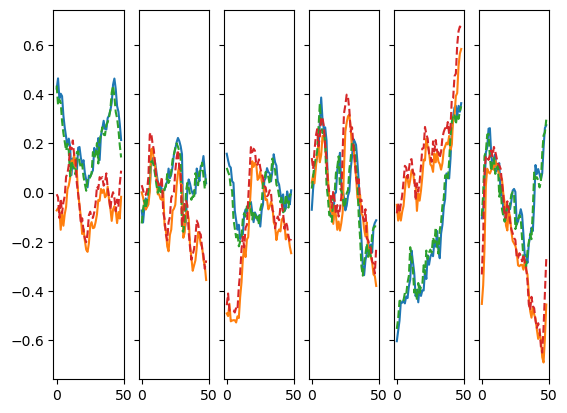

In [85]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,-2:].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,2:].cpu(), '--');

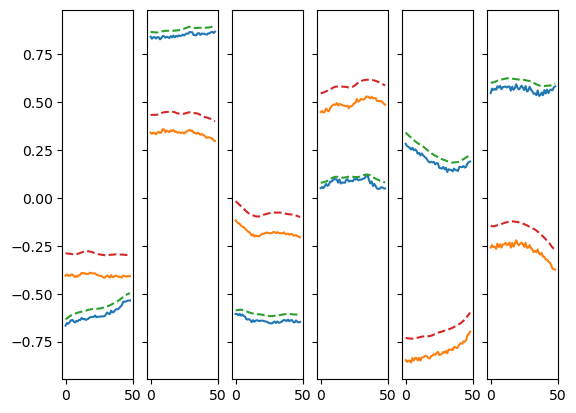

In [86]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,:2].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,:2].cpu(), '--');

In [87]:
model

DNRI(
  (super_gaussians): LearnableDistanceMask()
  (encoder): DNRI_Encoder(
    (super_G): LearnableDistanceMask()
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp1_e): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
      (bn): BatchNor

# Train

In [271]:
def get_edges_count_table(edges, dim=1):
    edges_table = np.zeros((params['num_edge_types'],params['num_vars']*(params['num_vars']-1)), dtype=int)
    idx = [slice(None)]*dim
    for i in range(edges.shape[dim]):
        u,c = edges[*(*idx,i)].unique(return_counts=True,)
        for j,j_c in zip(u,c):
            edges_table[int(j),i] = j_c
    return edges_table

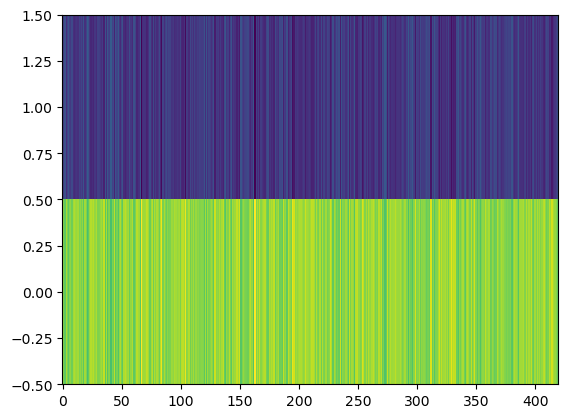

In [89]:
plt.imshow(get_edges_count_table(ds_train.edges[:,1:], dim=2),origin='lower', aspect='auto', interpolation='none');

In [131]:
import time

def build_scheduler(opt, params):
    lr_decay_factor, lr_decay_steps = params.get('lr_decay_factor'), params.get('lr_decay_steps')
    return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor) if lr_decay_factor else None

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary'), None

def train(model, dl_train, dl_valid, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)  # 16
    val_batch_size = params.get('val_batch_size', batch_size) # None
    if val_batch_size is None:  val_batch_size = batch_size # None=> 16
    accumulate_steps = params.get('accumulate_steps')  # 1
    training_scheduler = params.get('training_scheduler', None) #
    num_epochs = params.get('num_epochs', 100) # 200
    # val_interval = params.get('val_interval', 1)  # 5
    val_start = params.get('val_start', 0)  #
    clip_grad = params.get('clip_grad', None)  #
    clip_grad_norm = params.get('clip_grad_norm', None) # None
    normalize_nll = params.get('normalize_nll', False) # True
    normalize_kl = params.get('normalize_kl', False)  # True
    tune_on_nll = params.get('tune_on_nll', False)  # True
    verbose = params.get('verbose', False)  # False
    val_teacher_forcing = params.get('val_teacher_forcing', False)  # True
    continue_training = params.get('continue_training', False)  # FAlse
    lr = params['lr']  # 5e-4
    wd = params.get('wd', 0.)  #
    mom = params.get('mom', 0.) # 0.

    model_params = [param for param in model.parameters() if param.requires_grad]
    opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, 'model_checkpoint')
    training_path = os.path.join(working_dir, 'training_checkpoint')
    if continue_training: # False
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else: # <------------------------------------------
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    unnorm_targ_pos = ds_valid.node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_valid.node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v

    training_scheduler = build_scheduler(opt, params)
    end = start = 0
    train_loss, val_loss_ = [], []
    for epoch in trange(start_epoch, num_epochs+1):
        log = f"{epoch} {end-start:.2g}s"
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time()
        for batch_ind, batch in enumerate(dl_train):
            # data augmentation by rotations
            angle = torch.rand(1)*2.*torch.pi
            batch.node_feats = rotate_cart_2D(batch.node_feats, angle)
            batch.edge_feats = torch.cat([batch.edge_feats[...,0:1],
                                          rotate_cart_2D(batch.edge_feats[...,1:], angle)],
                                         dim=-1)

            loss, loss_nll, loss_kl = model.calculate_loss(batch, is_train=True)
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                print('clipping gradient values')
            elif clip_grad_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
                print('clipping gradient norms')
            opt.step()
            opt.zero_grad()

        if training_scheduler is not None:  training_scheduler.step()
        loss_train = loss.item()
        train_loss.append(loss.item())

        model.eval()
        opt.zero_grad()

        total_nll, total_kl, bs = 0., 0., 0
        val_loss = 0.
        all_edges, all_false_edges, all_preds = [], [], []
        with torch.no_grad():
            for batch_ind, batch in enumerate(dl_valid):
                loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(batch, is_train=False, teacher_forcing=val_teacher_forcing, return_edges=True)
                val_loss += loss.sum().item()*len(batch.batch)
                total_kl += loss_kl.sum().item()*len(batch.batch)
                total_nll += loss_nll.sum().item()*len(batch.batch)
                bs+=len(batch.batch)
                all_edges.append(edges)
                all_preds.append(preds)
            all_edges = torch.cat(all_edges,dim=0)
            all_preds = torch.cat(all_preds,dim=0)
            total_kl  /= bs
            total_nll /= bs
            val_loss  /= bs
            total_loss = model.kl_coef*total_kl + total_nll
            val_loss_.append(val_loss)
            # NLL positions, velocities
            unnorm_pred_pos = all_preds[...,:2]*ds_train.norm
            unnorm_pred_vel = all_preds[...,2:]*ds_train.norm_v
            # MSE is a scaled version of the nll gaussian with fixed variance
            nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
            nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))

            all_edges_ = all_edges.argmax(dim=-1).float().cpu()
            if all_edges_[ds_valid.edges[:,1:].transpose(1,2).reshape(-1, all_edges.shape[-2])==1].mean()> 1.2: # sort labels
                all_edges_ = all_edges[...,[0,2,1]].argmax(dim=-1).float().cpu()
            f1, *_ = f1_score_dnri(all_edges_,
                                   ds_valid.edges[:,1:].transpose(1,2))
            cm = confusion_matrix(ds_valid.edges[:,1:].transpose(1,2).reshape(-1),
                                  all_edges_.numpy().reshape(-1),
                                  normalize='true'
                                 )
        tuning_loss = total_nll
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            model.save(best_path)
        model.save(checkpoint_dir)
        torch.save({'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        print(log, f"{training_scheduler.get_last_lr()[0]:.2g}"\
              f"\t{loss_train:.4g}/{total_loss:.4g}({best_val_result:.4g}) {total_kl:.4g} {f1:.3g}")
        print(*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),
             "sigma=",*[f'{p.item():.3g}' for p in model.super_gaussians.sigma[:]],
              "beta",*[f'{p.item():.3g}' for p in model.super_gaussians.beta[:]])
        with np.printoptions(precision=1, suppress=True):
            print(cm*100)
        end = time.time()
    tab = get_edges_count_table(all_edges_.reshape(-1,params['num_vars']*(params['num_vars']-1),*all_edges_.shape[1:]), dim=1)
    plt.imshow(tab,origin='lower', aspect='auto', interpolation='none');
    plt.figure()
    plt.plot(train_loss);plt.plot(val_loss_);
    print(f"{best_val_result:.4g}|",*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),f"|{f1:.3g}|{cm[0,0]*100:.0f},{cm[1,1]*100:.0f}|")

In [105]:
params['use_supergaussian']=True
params['add_uniform_prior']=False

In [120]:
seed(params['model_seed']) # set seed for numpy, torch, cuda, and random libs
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.


In [121]:
with torch.no_grad():
    print(list(map(lambda x: f'{x.item():.4g}', model.calculate_loss(ds_train.datalist[0]))))
    print( model.calculate_baseloss(ds_train.datalist[0]).item())

['231.1', '231', '0.05479']
33.55405807495117


In [122]:
f"{model.super_gaussians._parameters['sigma'].item():.3g}", f"{model.super_gaussians._parameters['beta'].item():.3g}"

('0.4', '10')

In [123]:
with torch.inference_mode():
    loss, loss_nll, loss_kl, logits, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_logits=True)
    loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_edges=True)
    print(f'{loss=:.4g} = {loss_nll=:.4g} + {loss_kl=:.4g}')
    # MSE positions, velocities
    unnorm_pred_pos = preds[...,:2]*ds_train.norm
    unnorm_pred_vel = preds[...,2:]*ds_train.norm_v
    unnorm_targ_pos = ds_train.datalist[0].node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_train.datalist[0].node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v
    nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    print(f'unnormed NLL: {nll_pos=:.4g}, {nll_vel=:.4g}')

    all_edges_ = edges.argmax(dim=-1).float().cpu()
    f1, *_ = f1_score_dnri(all_edges_,
                           ds_train.edges[0,1:])
    cm = confusion_matrix(ds_train.edges[0,1:].reshape(-1),
                          all_edges_.numpy().reshape(-1),
                          normalize='true'
                         )
    print(f'F1={f1:.2g}')
    print(f'CM=')
    with np.printoptions(precision=1, suppress=True):
        print(cm*100)

loss=231 = loss_nll=230.9 + loss_kl=0.05479
unnormed NLL: nll_pos=4025, nll_vel=1053
F1=0.5
CM=
[[76.6 23.4]
 [77.4 22.6]]


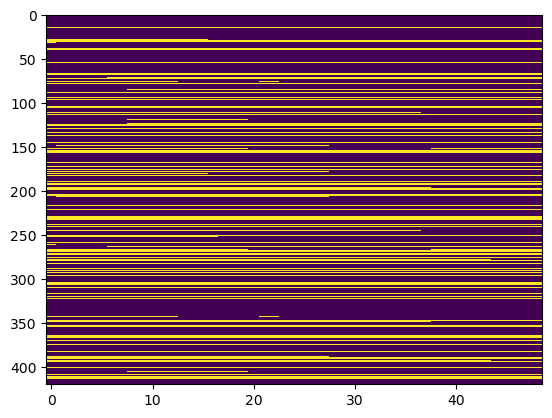

In [124]:
plt.imshow(ds_train.edges[0,1:].cpu().numpy().T, aspect='auto', interpolation='none');

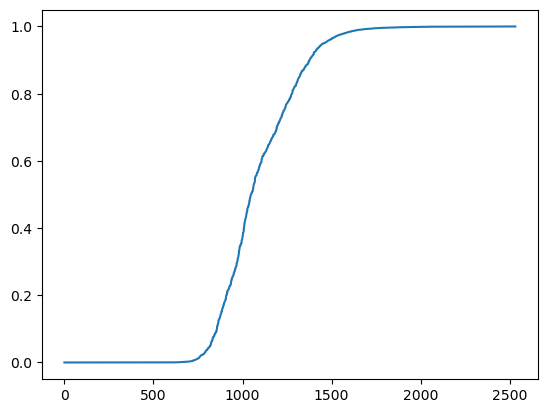

In [125]:
plt.plot(edges.unique().cpu().numpy());

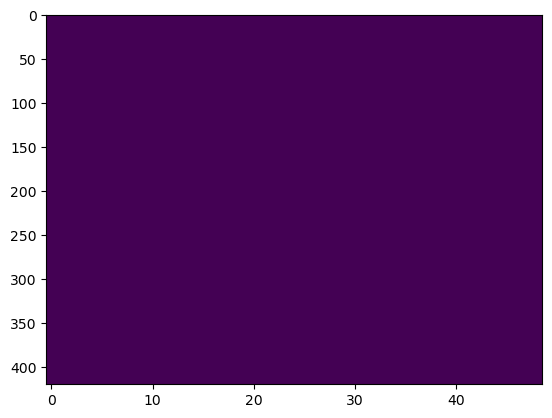

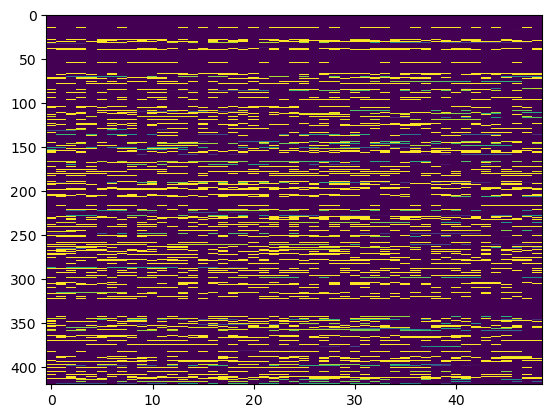

In [126]:
for i in range(2):
    plt.figure();    plt.imshow(edges[...,i].cpu().numpy(), aspect='auto', interpolation='none');

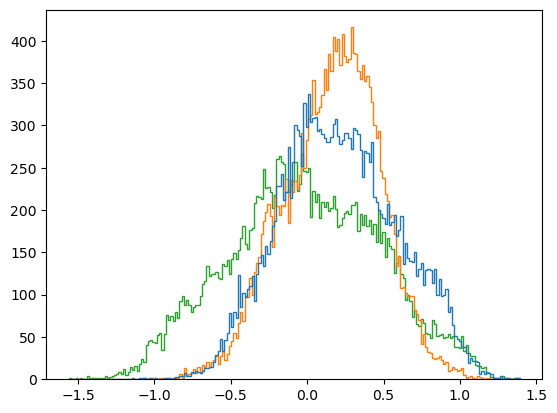

In [143]:
plt.hist(logits.reshape(-1,3).cpu().numpy(), 200, histtype='step');

## Training 

In [127]:
params['lr']=5e-6

In [128]:
params['num_epochs']=20

In [129]:
params['gumbel_temp']=1.5
model.gumbel_temp=1.5

1 0s 5e-06	216.6/221.1(221.1) 0.0707 0.684
3.57e+03 1.12e+03 0.4 10
[[75.8 24.2]
 [36.4 63.6]]
2 15s 5e-06	196.1/199.6(199.6) 0.0485 0.679
3.02e+03 1.08e+03 0.4 10
[[76.4 23.6]
 [38.5 61.5]]
3 12s 5e-06	177.9/180.3(180.2) 0.04916 0.666
2.51e+03 1.05e+03 0.4 10
[[77.7 22.3]
 [43.6 56.4]]
4 12s 5e-06	165.4/163.2(163.2) 0.05486 0.646
2.06e+03 1.02e+03 0.4 10
[[79.5 20.5]
 [50.5 49.5]]
5 12s 5e-06	147.8/148.6(148.5) 0.06084 0.626
1.67e+03 998 0.4 10
[[81.1 18.9]
 [56.6 43.4]]
6 13s 5e-06	138.4/136.1(136) 0.06834 0.614
1.34e+03 977 0.4 10
[[81.9 18.1]
 [59.9 40.1]]
7 13s 5e-06	127.6/125.4(125.4) 0.07881 0.611
1.07e+03 959 0.4 10
[[82.2 17.8]
 [60.9 39.1]]
8 11s 5e-06	116.9/116.6(116.5) 0.08717 0.607
844 940 0.4 10
[[82.5 17.5]
 [62.2 37.8]]
9 12s 5e-06	111.4/109.4(109.3) 0.09051 0.597
673 922 0.4 10
[[83.  17. ]
 [64.4 35.6]]
10 13s 5e-06	107/103.6(103.5) 0.09502 0.594
538 905 0.4 10
[[83.  17. ]
 [65.1 34.9]]
11 15s 5e-06	99.16/98.85(98.75) 0.09768 0.59
433 890 0.4 10
[[83.  17. ]
 [65.8 3

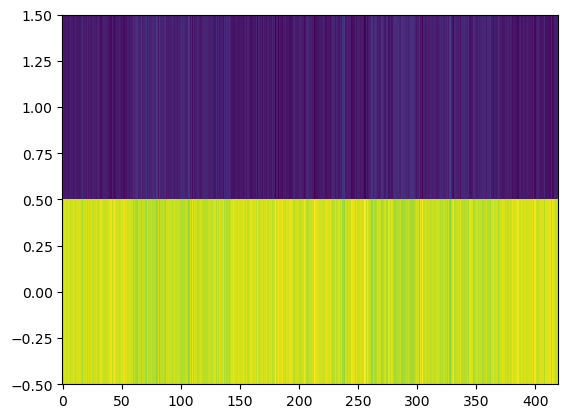

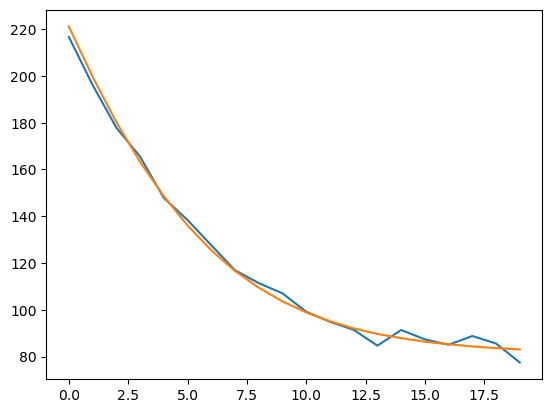

In [130]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [132]:
params['lr']=1e-5

  0%|          | 0/20 [00:00<?, ?it/s]

1 0s 1e-05	82.64/81.25(81.17) 0.07575 0.511
51.8 826 0.4 10
[[84.5 15.5]
 [80.6 19.4]]
2 9.9s 1e-05	75.58/80.13(80.07) 0.06164 0.498
30.4 821 0.4 10
[[84.9 15.1]
 [82.9 17.1]]
3 13s 1e-05	79.75/79.49(79.45) 0.04771 0.495
20.9 817 0.4 10
[[84.6 15.4]
 [83.1 16.9]]
4 14s 1e-05	83.04/79.04(79) 0.04019 0.5
18.4 813 0.4 10
[[84.3 15.7]
 [82.2 17.8]]
5 11s 1e-05	76.98/78.65(78.61) 0.03893 0.489
18.8 809 0.4 10
[[84.6 15.4]
 [84.1 15.9]]
6 9.7s 1e-05	77.24/78.12(78.07) 0.04163 0.486
22.3 803 0.4 10
[[84.3 15.7]
 [84.4 15.6]]
7 16s 1e-05	77.78/77.22(77.17) 0.04638 0.47
22.8 795 0.4 10
[[84.5 15.5]
 [86.8 13.2]]
8 11s 1e-05	78.11/76.09(76.04) 0.05244 0.471
20.2 786 0.4 10
[[84.2 15.8]
 [86.5 13.5]]
9 10s 1e-05	74.79/75.05(74.99) 0.05523 0.459
14.8 779 0.399 10
[[85.3 14.7]
 [88.9 11.1]]
10 14s 1e-05	74.66/74.49(74.43) 0.06055 0.447
11.1 775 0.399 10
[[85.7 14.3]
 [90.7  9.3]]
11 12s 1e-05	75.69/73.83(73.77) 0.06177 0.46
10.8 769 0.399 10
[[85.3 14.7]
 [88.8 11.2]]
12 13s 1e-05	75.91/73.4(73.34)

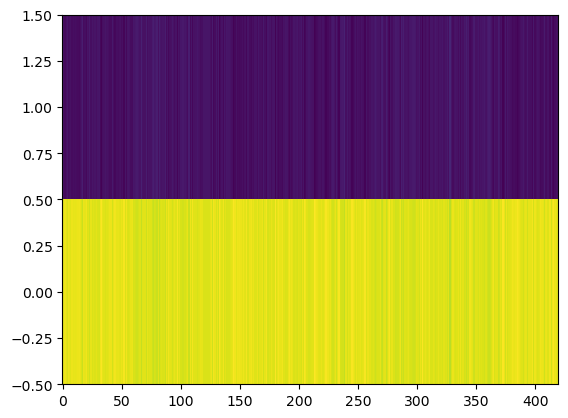

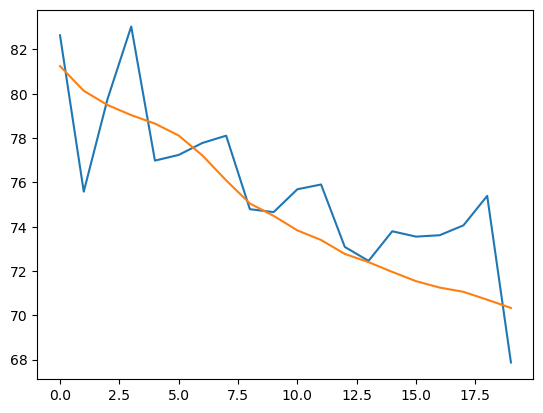

In [133]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [134]:
params['lr']=5e-5

  0%|          | 0/20 [00:00<?, ?it/s]

1 0s 5e-05	68.8/70.84(70.77) 0.07348 0.481
4.95 743 0.4 10
[[87.6 12.4]
 [87.1 12.9]]
2 15s 5e-05	68.02/69.52(69.43) 0.09022 0.502
5.12 731 0.4 10
[[86.5 13.5]
 [83.4 16.6]]
3 12s 5e-05	69.18/68.64(68.54) 0.1028 0.514
4.12 721 0.4 10
[[87.1 12.9]
 [82.  18. ]]
4 13s 5e-05	69.09/67.41(67.3) 0.1108 0.526
3.16 710 0.4 10
[[86.8 13.2]
 [80.  20. ]]
5 12s 5e-05	64.96/66.45(66.34) 0.1125 0.53
2.6 700 0.4 10
[[86.9 13.1]
 [79.3 20.7]]
6 12s 5e-05	68.63/65.87(65.75) 0.1174 0.527
2.35 694 0.4 10
[[86.4 13.6]
 [79.5 20.5]]
7 13s 5e-05	70.04/64.52(64.4) 0.1186 0.569
2.07 681 0.4 10
[[85.3 14.7]
 [71.8 28.2]]
8 12s 5e-05	64.09/63.89(63.76) 0.1229 0.547
1.86 675 0.4 10
[[85.4 14.6]
 [75.6 24.4]]
9 12s 5e-05	63.23/63.13(63) 0.1248 0.543
1.68 668 0.4 10
[[85.2 14.8]
 [76.  24. ]]
10 13s 5e-05	64.01/62.94(62.81) 0.1316 0.538
1.56 666 0.4 10
[[85.2 14.8]
 [76.9 23.1]]
11 13s 5e-05	61.85/62.63(62.5) 0.1315 0.543
1.42 662 0.4 10
[[85.1 14.9]
 [75.9 24.1]]
12 13s 5e-05	60.61/63.03(62.5) 0.1335 0.549
1.47 

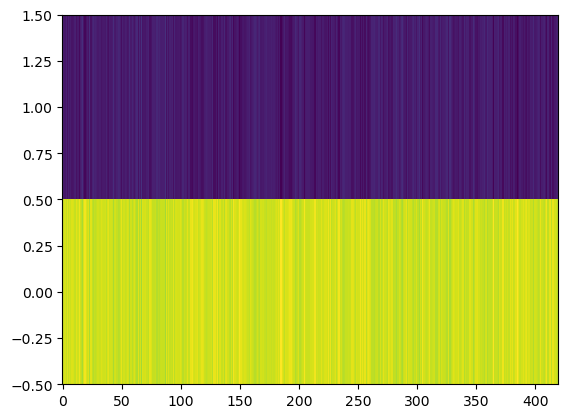

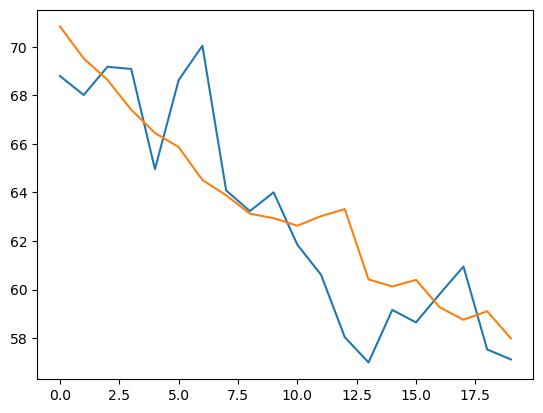

In [135]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [136]:
params['num_epochs']=100

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 5e-05	58.09/59.5(59.33) 0.1767 0.667
1.34 631 0.4 10
[[83.9 16.1]
 [51.7 48.3]]
2 13s 5e-05	60.18/58.11(57.97) 0.1442 0.637
1.16 617 0.4 10
[[84.1 15.9]
 [57.9 42.1]]
3 16s 5e-05	57.74/57.7(57.57) 0.138 0.625
1.08 614 0.4 10
[[84.8 15.2]
 [61.1 38.9]]
4 12s 5e-05	58.65/57.39(57.25) 0.1388 0.62
1.04 611 0.4 10
[[84.8 15.2]
 [62.1 37.9]]
5 14s 5e-05	56.79/57.29(57.15) 0.1414 0.629
1.04 610 0.4 10
[[84.7 15.3]
 [60.3 39.7]]
6 9.7s 5e-05	56.82/57.18(57.04) 0.1417 0.64
1.06 608 0.4 10
[[84.8 15.2]
 [58.1 41.9]]
7 11s 5e-05	58.86/57.21(57.04) 0.144 0.635
0.996 609 0.4 10
[[85.1 14.9]
 [59.6 40.4]]
8 16s 5e-05	54.62/56.92(56.77) 0.1459 0.621
1.05 606 0.4 10
[[85.4 14.6]
 [62.5 37.5]]
9 11s 5e-05	56.14/56.48(56.34) 0.1417 0.653
1.04 602 0.4 10
[[84.9 15.1]
 [55.7 44.3]]
10 9.8s 5e-05	60.03/56.5(56.34) 0.1386 0.665
1.01 602 0.4 10
[[84.9 15.1]
 [53.3 46.7]]
11 13s 5e-05	53.87/56.16(56.01) 0.143 0.658
1.09 598 0.4 10
[[85.5 14.5]
 [55.5 44.5]]
12 11s 5e-05	55.06/56.25(56.01) 0.1489 0.652
1.

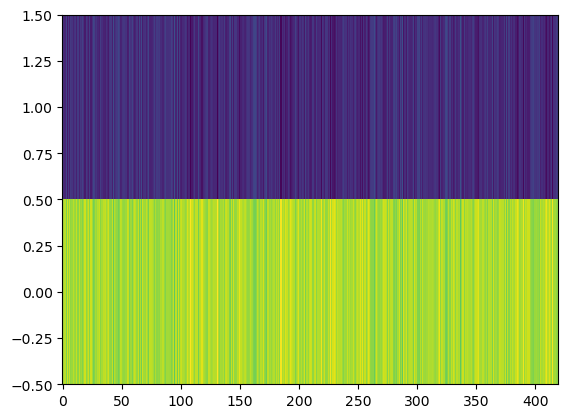

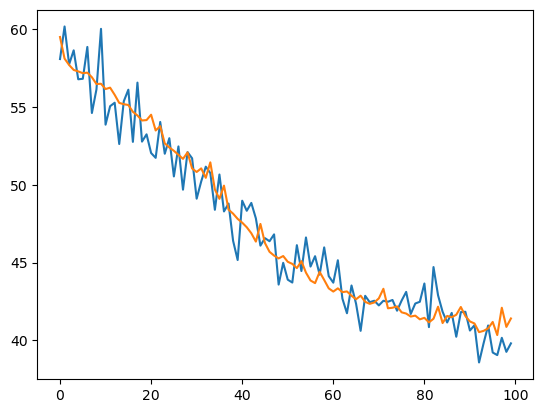

In [137]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [138]:
params['gumbel_temp']=.5
model.gumbel_temp=.5

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 5e-05	53.82/58.13(57.95) 0.184 0.767
1.51 622 0.4 9.93
[[90.  10. ]
 [38.8 61.2]]
2 11s 5e-05	45.79/47.04(46.9) 0.1428 0.812
0.979 517 0.4 9.93
[[90.3  9.7]
 [29.  71. ]]
3 10s 5e-05	42.03/43.02(42.89) 0.1309 0.812
2.19 475 0.4 9.93
[[90.4  9.6]
 [29.2 70.8]]
4 11s 5e-05	40.39/40.93(40.8) 0.1253 0.803
1.26 454 0.4 9.93
[[90.5  9.5]
 [31.5 68.5]]
5 17s 5e-05	43.35/40.61(40.48) 0.1254 0.796
0.579 451 0.4 9.93
[[90.4  9.6]
 [32.8 67.2]]
6 12s 5e-05	39.74/40.32(40.2) 0.1184 0.797
0.503 449 0.4 9.93
[[90.9  9.1]
 [33.5 66.5]]
7 9.9s 5e-05	40.96/40.64(40.2) 0.1232 0.791
0.51 451 0.4 9.93
[[90.9  9.1]
 [34.9 65.1]]
8 12s 5e-05	39.19/40.71(40.2) 0.1224 0.79
0.491 452 0.4 9.93
[[90.6  9.4]
 [34.7 65.3]]
9 14s 5e-05	41.1/39.9(39.79) 0.1149 0.798
0.484 445 0.4 9.93
[[90.3  9.7]
 [32.2 67.8]]
10 11s 5e-05	40.02/40.52(39.79) 0.1205 0.79
0.483 450 0.4 9.93
[[90.7  9.3]
 [34.8 65.2]]
11 12s 5e-05	41.94/40.28(39.79) 0.1205 0.791
0.504 448 0.4 9.93
[[90.6  9.4]
 [34.3 65.7]]
12 12s 5e-05	38.8/39.9

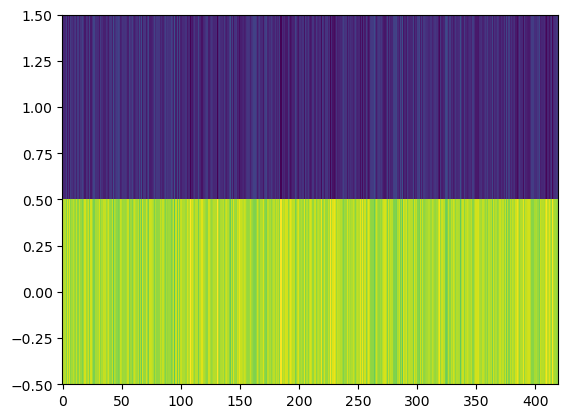

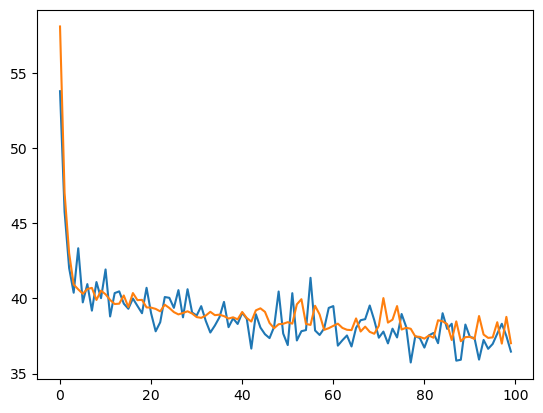

In [139]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [140]:
params['gumbel_temp']=.1
model.gumbel_temp=.1

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 5e-05	51.59/55.64(55.43) 0.214 0.755
0.63 599 0.4 9.89
[[89.6 10.4]
 [40.9 59.1]]
2 10s 5e-05	46.96/52.6(52.44) 0.1597 0.818
0.504 564 0.4 9.89
[[90.1  9.9]
 [27.2 72.8]]
3 13s 5e-05	41.34/42.05(41.9) 0.1474 0.822
0.654 469 0.4 9.89
[[92.4  7.6]
 [30.1 69.9]]
4 12s 5e-05	39.27/39.81(39.68) 0.1368 0.828
0.823 443 0.4 9.89
[[91.8  8.2]
 [27.7 72.3]]
5 13s 5e-05	38.07/39.02(38.87) 0.1449 0.811
0.844 436 0.4 9.89
[[92.   8. ]
 [32.2 67.8]]
6 14s 5e-05	36.63/38.24(38.09) 0.1433 0.805
0.424 429 0.4 9.89
[[91.6  8.4]
 [32.8 67.2]]
7 11s 5e-05	37.92/37.69(37.56) 0.1286 0.816
0.385 423 0.4 9.89
[[91.2  8.8]
 [29.5 70.5]]
8 9.7s 5e-05	37.45/38.21(37.56) 0.1381 0.802
0.374 428 0.4 9.89
[[91.6  8.4]
 [33.5 66.5]]
9 11s 5e-05	36.83/37.81(37.56) 0.1347 0.807
0.381 424 0.4 9.89
[[91.8  8.2]
 [32.7 67.3]]
10 14s 5e-05	37.86/38.1(37.56) 0.136 0.803
0.367 426 0.4 9.89
[[92.2  7.8]
 [34.1 65.9]]
11 12s 5e-05	38.86/37.72(37.56) 0.1355 0.8
0.361 423 0.4 9.89
[[91.8  8.2]
 [34.3 65.7]]
12 12s 5e-05	37.

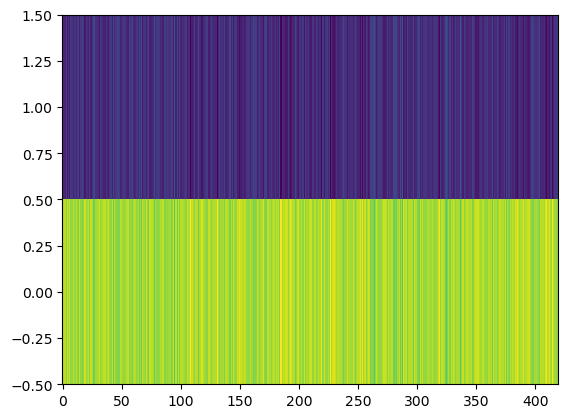

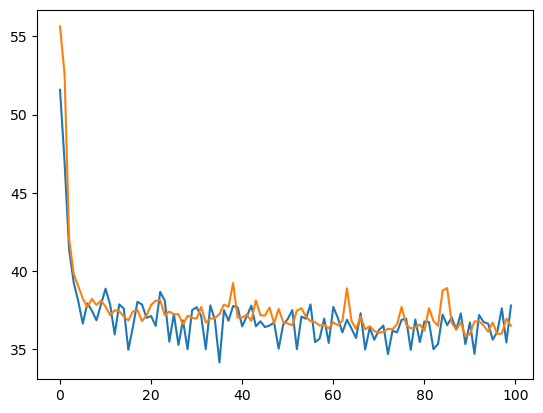

In [141]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [142]:
params['gumbel_temp']=.05
model.gumbel_temp=.05

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 5e-05	59.06/48.65(48.49) 0.1605 0.792
0.54 530 0.4 9.86
[[90.3  9.7]
 [33.8 66.2]]
2 15s 5e-05	42.43/45.34(45.19) 0.1563 0.846
0.444 504 0.4 9.86
[[91.5  8.5]
 [22.7 77.3]]
3 11s 5e-05	37.5/38.62(38.48) 0.1403 0.825
0.461 433 0.4 9.86
[[91.7  8.3]
 [28.1 71.9]]
4 13s 5e-05	36.02/37.14(37) 0.1364 0.826
0.435 418 0.4 9.86
[[91.9  8.1]
 [28.3 71.7]]
5 11s 5e-05	36.58/36.38(36.25) 0.1354 0.82
0.598 410 0.4 9.86
[[91.7  8.3]
 [29.4 70.6]]
6 12s 5e-05	35.59/36.02(35.89) 0.136 0.816
0.473 407 0.4 9.86
[[91.4  8.6]
 [30.  70. ]]
7 14s 5e-05	35.34/36.34(35.89) 0.1363 0.816
0.342 409 0.4 9.86
[[91.2  8.8]
 [29.7 70.3]]
8 11s 5e-05	37.47/36.22(35.89) 0.1354 0.812
0.32 409 0.4 9.86
[[91.5  8.5]
 [31.  69. ]]
9 10s 5e-05	37.79/36.44(35.89) 0.1412 0.802
0.333 411 0.4 9.86
[[91.2  8.8]
 [32.9 67.1]]
10 9.7s 5e-05	36.96/36.1(35.89) 0.1266 0.822
0.281 408 0.4 9.86
[[90.9  9.1]
 [27.5 72.5]]
11 14s 5e-05	35.37/35.87(35.74) 0.1374 0.814
0.326 406 0.4 9.86
[[90.8  9.2]
 [29.4 70.6]]
12 14s 5e-05	38.1

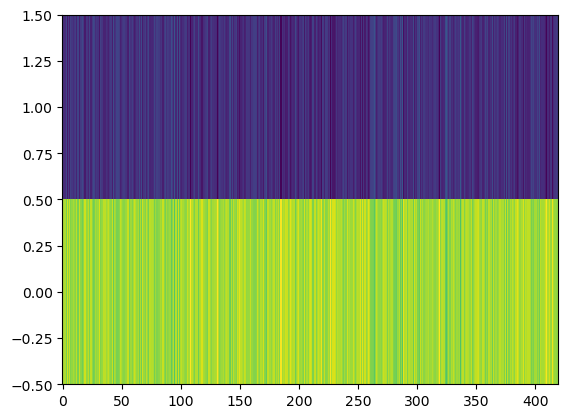

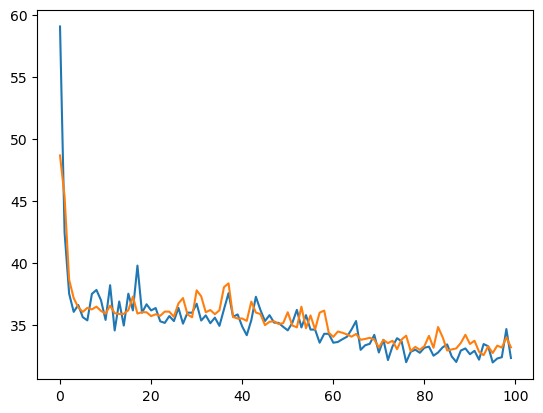

In [143]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [144]:
params['gumbel_temp']=.01
model.gumbel_temp=.01

In [145]:
params['lr']=1e-5

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 1e-05	31.75/32.73(32.6) 0.1319 0.832
0.238 373 0.4 9.82
[[90.3  9.7]
 [24.1 75.9]]
2 11s 1e-05	32.45/32.68(32.54) 0.139 0.823
0.239 372 0.4 9.82
[[90.6  9.4]
 [26.7 73.3]]
3 11s 1e-05	33/33.01(32.54) 0.1371 0.827
0.23 376 0.4 9.82
[[90.3  9.7]
 [25.5 74.5]]
4 13s 1e-05	33.05/32.47(32.34) 0.1326 0.83
0.229 370 0.4 9.82
[[90.4  9.6]
 [24.9 75.1]]
5 13s 1e-05	31.73/32.53(32.34) 0.1311 0.833
0.226 371 0.4 9.82
[[90.9  9.1]
 [25.1 74.9]]
6 15s 1e-05	31.85/32.24(32.1) 0.1347 0.83
0.224 368 0.4 9.82
[[90.5  9.5]
 [24.9 75.1]]
7 11s 1e-05	32.38/32.26(32.1) 0.1379 0.825
0.223 368 0.4 9.82
[[90.4  9.6]
 [26.1 73.9]]
8 13s 1e-05	32.52/32.18(32.04) 0.1374 0.825
0.221 367 0.4 9.82
[[90.4  9.6]
 [26.  74. ]]
9 14s 1e-05	31.72/32.27(32.04) 0.1394 0.823
0.222 368 0.4 9.82
[[90.4  9.6]
 [26.4 73.6]]
10 10s 1e-05	31.35/32.3(32.04) 0.1404 0.821
0.221 369 0.4 9.82
[[90.6  9.4]
 [27.3 72.7]]
11 13s 1e-05	33.15/32.26(32.04) 0.1369 0.824
0.218 368 0.4 9.82
[[90.7  9.3]
 [26.9 73.1]]
12 11s 1e-05	31.33/3

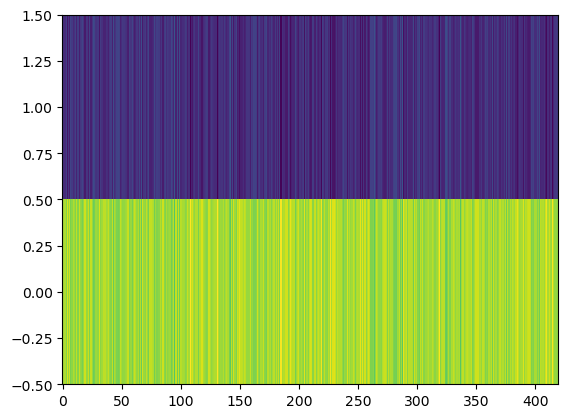

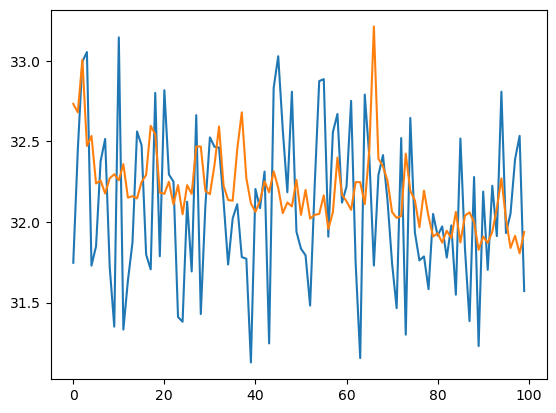

In [146]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 1e-05	31.72/31.9(31.76) 0.1403 0.829
0.198 365 0.4 9.82
[[90.5  9.5]
 [25.1 74.9]]
2 13s 1e-05	32.72/32.02(31.76) 0.1393 0.831
0.194 366 0.4 9.82
[[90.9  9.1]
 [25.6 74.4]]
3 12s 1e-05	31.43/32.35(31.76) 0.1489 0.815
0.196 369 0.4 9.82
[[90.8  9.2]
 [29.1 70.9]]
4 11s 1e-05	32.37/32.05(31.76) 0.1409 0.825
0.197 366 0.4 9.82
[[90.5  9.5]
 [26.1 73.9]]
5 14s 1e-05	32.73/32.7(31.76) 0.1294 0.84
0.196 373 0.4 9.82
[[90.6  9.4]
 [22.8 77.2]]
6 15s 1e-05	32.28/32.88(31.76) 0.1273 0.842
0.196 374 0.4 9.82
[[90.7  9.3]
 [22.4 77.6]]
7 13s 1e-05	32.08/32.1(31.76) 0.137 0.83
0.194 366 0.4 9.82
[[90.8  9.2]
 [25.4 74.6]]
8 9.5s 1e-05	30.72/31.89(31.75) 0.1389 0.827
0.193 364 0.4 9.82
[[90.8  9.2]
 [26.3 73.7]]
9 14s 1e-05	31.05/31.97(31.75) 0.1414 0.826
0.192 365 0.4 9.82
[[90.7  9.3]
 [26.4 73.6]]
10 12s 1e-05	32.06/32.02(31.75) 0.1446 0.821
0.193 366 0.4 9.82
[[90.8  9.2]
 [27.7 72.3]]
11 12s 1e-05	32.02/31.88(31.73) 0.1423 0.822
0.197 364 0.4 9.82
[[90.7  9.3]
 [27.2 72.8]]
12 15s 1e-05	3

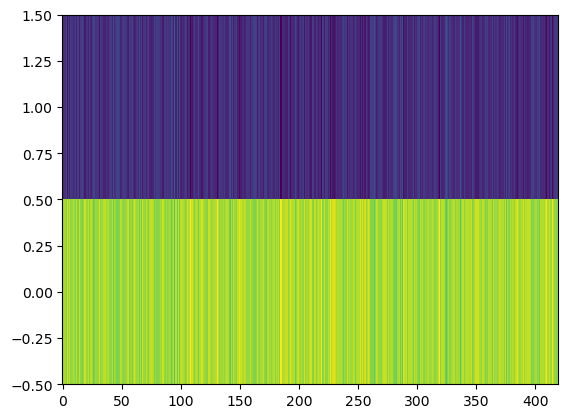

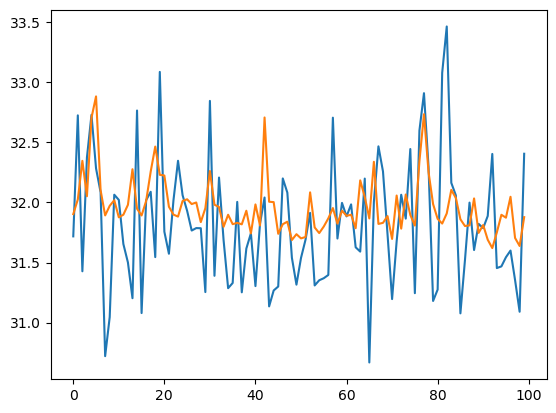

In [147]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 1e-05	31.57/32.15(32) 0.1429 0.818
0.186 367 0.4 9.81
[[90.8  9.2]
 [28.5 71.5]]
2 12s 1e-05	31.52/31.87(31.73) 0.1338 0.83
0.183 364 0.4 9.81
[[90.3  9.7]
 [24.7 75.3]]
3 12s 1e-05	31.41/31.71(31.57) 0.1377 0.826
0.186 363 0.4 9.81
[[90.5  9.5]
 [26.1 73.9]]
4 11s 1e-05	31.4/31.67(31.52) 0.1439 0.823
0.186 362 0.4 9.81
[[90.4  9.6]
 [26.5 73.5]]
5 13s 1e-05	31.26/31.75(31.52) 0.1422 0.826
0.192 363 0.4 9.81
[[90.2  9.8]
 [25.6 74.4]]
6 13s 1e-05	31.98/31.87(31.52) 0.137 0.83
0.181 364 0.4 9.81
[[90.4  9.6]
 [24.7 75.3]]
7 12s 1e-05	31.02/31.86(31.52) 0.14 0.824
0.179 364 0.4 9.81
[[90.7  9.3]
 [26.8 73.2]]
8 12s 1e-05	31.98/32.2(31.52) 0.1334 0.834
0.187 368 0.4 9.81
[[90.2  9.8]
 [23.4 76.6]]
9 15s 1e-05	31.6/31.87(31.52) 0.1385 0.828
0.196 365 0.4 9.81
[[90.3  9.7]
 [25.2 74.8]]
10 12s 1e-05	31.77/32.02(31.52) 0.1455 0.818
0.187 365 0.4 9.81
[[90.4  9.6]
 [27.7 72.3]]
11 12s 1e-05	31.71/31.8(31.52) 0.1428 0.821
0.179 363 0.4 9.81
[[90.  10. ]
 [26.3 73.7]]
12 13s 1e-05	32.04/31

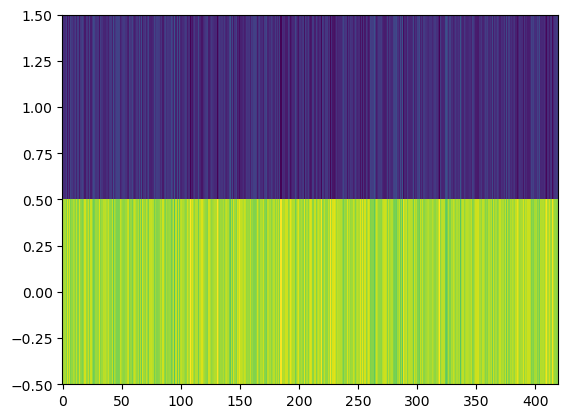

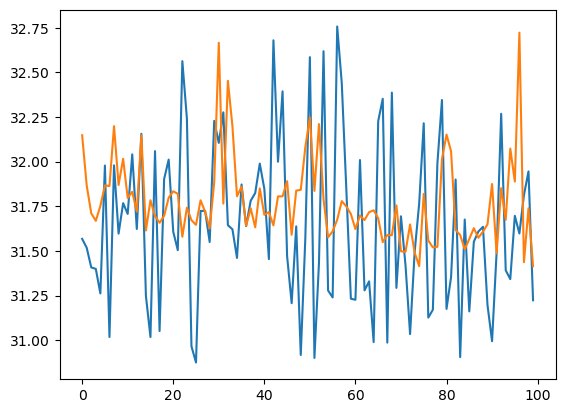

In [148]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 1e-05	31.41/31.95(31.81) 0.1352 0.829
0.175 365 0.4 9.8
[[90.  10. ]
 [24.2 75.8]]
2 9.4s 1e-05	31.45/31.76(31.62) 0.1397 0.825
0.174 363 0.4 9.8
[[89.9 10.1]
 [25.2 74.8]]
3 13s 1e-05	32.49/31.54(31.4) 0.1413 0.822
0.173 361 0.4 9.8
[[90.3  9.7]
 [26.6 73.4]]
4 13s 1e-05	32.27/31.45(31.31) 0.1407 0.823
0.176 360 0.4 9.8
[[90.1  9.9]
 [26.  74. ]]
5 10s 1e-05	31.31/31.58(31.31) 0.1386 0.826
0.172 361 0.4 9.8
[[89.8 10.2]
 [24.7 75.3]]
6 13s 1e-05	30.99/31.42(31.28) 0.1386 0.825
0.173 360 0.4 9.8
[[90.  10. ]
 [25.3 74.7]]
7 13s 1e-05	31.07/31.48(31.28) 0.1396 0.822
0.174 360 0.4 9.8
[[90.1  9.9]
 [26.2 73.8]]
8 14s 1e-05	31.42/31.49(31.28) 0.1397 0.82
0.175 360 0.4 9.8
[[90.1  9.9]
 [26.7 73.3]]
9 12s 1e-05	31.81/31.49(31.28) 0.1413 0.817
0.174 360 0.4 9.8
[[90.  10. ]
 [27.1 72.9]]
10 12s 1e-05	32.54/31.4(31.26) 0.1407 0.821
0.17 359 0.4 9.8
[[89.8 10.2]
 [26.  74. ]]
11 13s 1e-05	31.19/31.47(31.26) 0.1383 0.825
0.171 360 0.4 9.8
[[89.7 10.3]
 [24.8 75.2]]
12 13s 1e-05	30.61/31.5

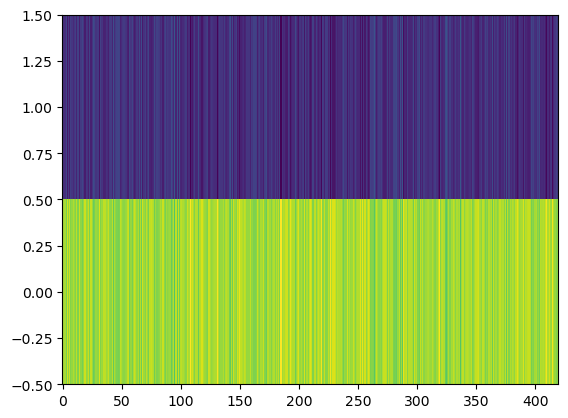

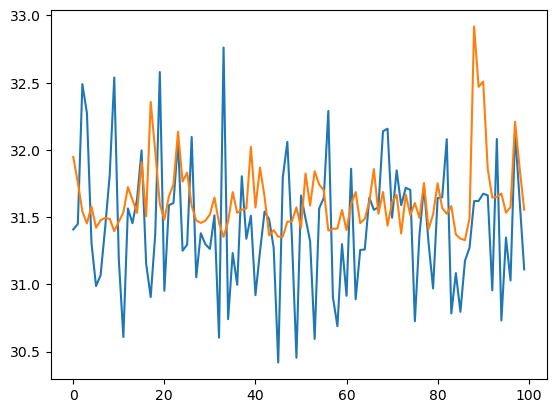

In [149]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [150]:
params['num_epochs']=200
params['lr_decay_steps']=200

  0%|          | 0/200 [00:00<?, ?it/s]

1 0s 1e-05	31.55/31.83(31.69) 0.1392 0.826
0.184 364 0.4 9.8
[[90.2  9.8]
 [25.3 74.7]]
2 11s 1e-05	31.48/32.15(31.69) 0.1468 0.816
0.192 367 0.4 9.8
[[90.4  9.6]
 [28.1 71.9]]
3 12s 1e-05	31.77/32.42(31.69) 0.1519 0.808
0.171 371 0.4 9.8
[[90.2  9.8]
 [29.7 70.3]]
4 16s 1e-05	31.13/31.69(31.55) 0.1356 0.829
0.167 362 0.4 9.8
[[90.1  9.9]
 [24.4 75.6]]
5 11s 1e-05	31.64/31.46(31.32) 0.14 0.823
0.165 360 0.4 9.8
[[90.4  9.6]
 [26.5 73.5]]
6 16s 1e-05	30.94/31.43(31.3) 0.138 0.826
0.167 360 0.4 9.8
[[90.  10. ]
 [25.1 74.9]]
7 13s 1e-05	31.26/31.49(31.3) 0.1437 0.822
0.171 360 0.4 9.8
[[89.9 10.1]
 [25.9 74.1]]
8 11s 1e-05	30.97/31.51(31.3) 0.1486 0.817
0.186 361 0.4 9.8
[[89.9 10.1]
 [27.1 72.9]]
9 13s 1e-05	31.55/31.39(31.24) 0.1425 0.823
0.192 359 0.4 9.8
[[90.2  9.8]
 [26.2 73.8]]
10 13s 1e-05	31.78/31.62(31.24) 0.1476 0.817
0.178 362 0.4 9.8
[[90.3  9.7]
 [27.8 72.2]]
11 9.9s 1e-05	31.33/31.47(31.24) 0.1419 0.823
0.165 360 0.4 9.8
[[90.1  9.9]
 [25.9 74.1]]
12 13s 1e-05	31.79/31.4(3

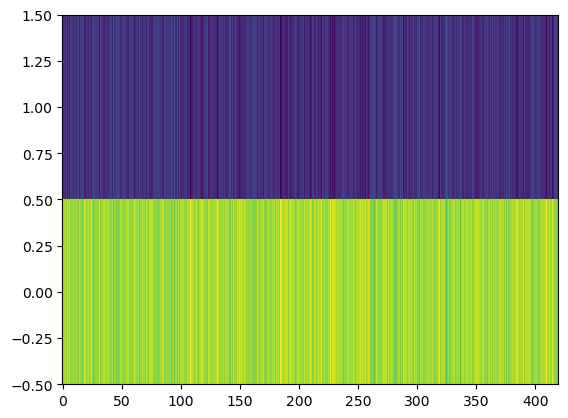

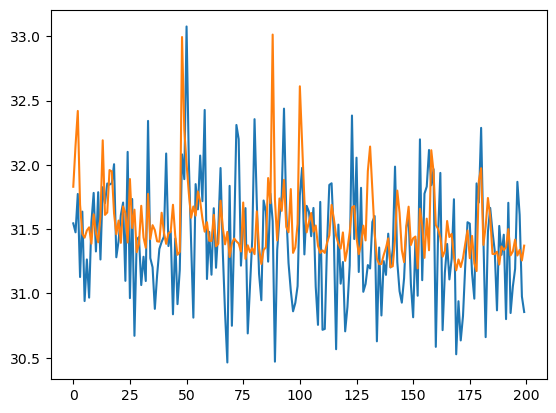

In [151]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

  0%|          | 0/200 [00:00<?, ?it/s]

1 0s 1e-05	32.38/31.54(31.4) 0.1446 0.819
0.161 361 0.4 9.79
[[89.9 10.1]
 [26.6 73.4]]
2 13s 1e-05	31.67/31.68(31.4) 0.1512 0.812
0.16 363 0.4 9.79
[[89.9 10.1]
 [28.2 71.8]]
3 9.7s 1e-05	32.32/31.49(31.34) 0.1442 0.818
0.158 360 0.4 9.79
[[90.3  9.7]
 [27.6 72.4]]
4 13s 1e-05	31.56/31.66(31.34) 0.1412 0.82
0.166 362 0.4 9.79
[[90.4  9.6]
 [27.3 72.7]]
5 11s 1e-05	31.46/31.57(31.34) 0.1357 0.83
0.157 361 0.4 9.79
[[90.4  9.6]
 [24.7 75.3]]
6 12s 1e-05	31.74/31.44(31.3) 0.1381 0.828
0.158 360 0.4 9.79
[[90.4  9.6]
 [25.3 74.7]]
7 14s 1e-05	31.18/31.09(30.95) 0.141 0.821
0.156 356 0.4 9.79
[[90.4  9.6]
 [27.  73. ]]
8 10s 1e-05	30.91/31.42(30.95) 0.1399 0.823
0.155 360 0.4 9.79
[[90.4  9.6]
 [26.5 73.5]]
9 13s 1e-05	30.72/31.84(30.95) 0.1453 0.818
0.157 365 0.4 9.79
[[90.5  9.5]
 [27.8 72.2]]
10 13s 1e-05	30.51/32.01(30.95) 0.1493 0.817
0.159 367 0.4 9.79
[[89.9 10.1]
 [27.1 72.9]]
11 12s 1e-05	30.91/31.69(30.95) 0.1337 0.83
0.16 363 0.4 9.79
[[89.9 10.1]
 [23.9 76.1]]
12 14s 1e-05	31.2

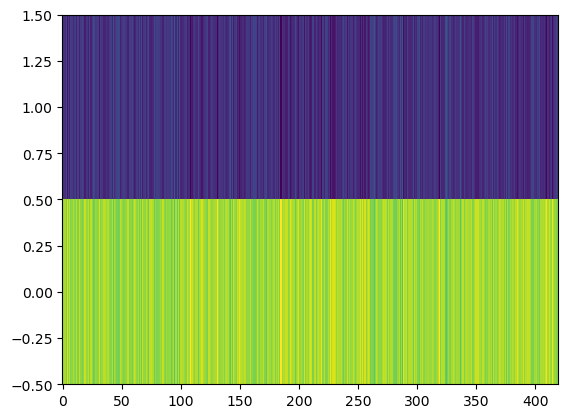

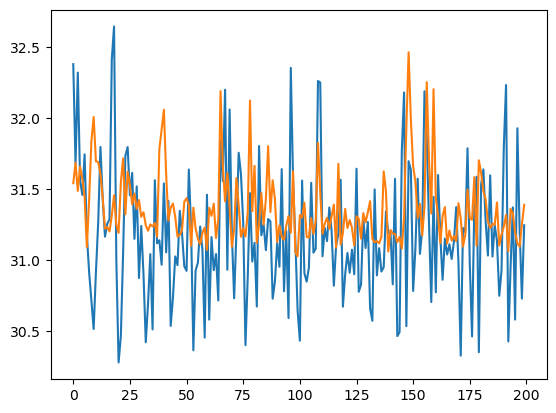

In [152]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

# Evaluation of model performance

## Inference on test data

In [354]:
#params['gpu']=True
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print(dvc)
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)
print(next(model.decoder.parameters()).device,)
print("LOADING BEST MODEL")
best_path = os.path.join(params['working_dir'],'best_model')
print(best_path)
model.load(best_path)
model.eval()
print(next(model.decoder.parameters()).device,)

cuda
Using learned interaction net decoder.
cuda:0
LOADING BEST MODEL
results/synthLJ_21/pyg_dnri_supergaussianmlpeandmask_linrefmlp_boundarymaskedloss_Rinterior08_augrot_clean/seed_1/best_model
cuda:0


In [303]:
model

DNRI(
  (super_gaussians): LearnableDistanceMask()
  (encoder): DNRI_Encoder(
    (super_G): LearnableDistanceMask()
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp1_e): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
      (bn): BatchNor

In [304]:
params['data_path']

'data/synthLJ_21_/'

In [305]:
edges_true = torch.load(params['data_path']+'test_edges')
feats = torch.load(params['data_path']+'test_feats')
feats_ = torch.load(params['data_path']+'test_feats') # not normalized feats

In [306]:
edges_true = edges_true[:,ds_train.slice_t]
feats  = feats[:,ds_train.slice_t]
feats_ = feats_[:,ds_train.slice_t]

In [307]:
feats  = feats.transpose(1,2)
feats_ = feats_.transpose(1,2)

In [308]:
feats[..., :2] = (feats[..., :2]-ds_train.loc_min)*2/(ds_train.loc_max-ds_train.loc_min)-1
feats[...,2: ] = (feats[...,2: ]-ds_train.vel_min)*2/(ds_train.vel_max-ds_train.vel_min)-1

In [309]:
norm = ds_train.norm  # 2/(train_data.loc_max-train_data.loc_min)
norm_v = ds_train.norm_v  # 2/(train_data.vel_max-train_data.vel_min)
print(norm, norm_v)

tensor(5.6345) tensor(3.2162)


In [310]:
feats.shape

torch.Size([2000, 21, 50, 4])

In [311]:
N = feats.shape[1]

In [312]:
model.gumbel_temp = 0.1

In [313]:
batch_size = 32  # 128

In [355]:
with torch.inference_mode(), dvc:
    model.to(dvc)
    node_feats, edge_feats = feats.to(dvc), get_dv(feats, params['sparse']).to(dvc)  # B, T, N, F
    node_feats_test = node_feats
    edge_feats_test = edge_feats
    # target one step in the future
    target = node_feats[:,:, 1:] if not params['pred_delta'] else node_feats.diff(dim=2) # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

    if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
        send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
    else: # fully connected
        send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
        edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                              for i in range(params['num_vars'])]),
                                 requires_grad=False)
    edge_index = torch.stack((send_edges, recv_edges))
    # implicit batching
    datalist = [Data(node_feats=n, edge_feats=e, edge_index=edge_index)
                         for n,e in zip(node_feats,edge_feats)]

    timesteps = node_feats.size(2)  # T
    dl = DataLoader(datalist, batch_size=batch_size)
    all_edges, all_preds = [], []
    all_prior_logits, all_posterior_logits = [], []
    # batching-------------------
    for b in tqdm(dl):
        node_feats, edge_feats, edge_index = getattrs(b,['node_feats','edge_feats', 'edge_index'])

        # Encode input = predict prior and edge class
        prior_logits, posterior_logits, prior_state = model.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        all_prior_logits.append(prior_logits)
        all_posterior_logits.append(posterior_logits)

        # Decode = predict next timestep features
        hidden = model.decoder.get_initial_hidden(node_feats) # zeros B*N,H
        edges, predictions = [], []

        for step in range(timesteps - 1): # T-1
            current_inputs = node_feats[:, step], edge_feats[:,step],edge_index  # B*N, F
            prediction, hidden, edge = model.single_step_forward(
                current_inputs,  # B*N, F
                hidden,  # B*N, H
                posterior_logits[:, step],  # B*E, C
                hard_sample=not model.training,
            )
            predictions.append(prediction)  # B*N, F
            edges.append(edge)              # B*E, C

        all_preds.append(torch.stack(predictions, dim=1)) # B*N, T-1, F
        all_edges.append(torch.stack(edges,dim=1)) # B*E,T-1,C

    # get loss
    # reconstruction
    all_preds=torch.cat(all_preds, dim=0)
    all_edges=torch.cat(all_edges, dim=0)
    print(all_preds.shape, target.shape)
    loss_nll = model.nll_gaussian(all_preds.reshape(-1,4), target.reshape(-1,4))

    # priors
    # learned prior
    all_posterior_logits=torch.cat(all_posterior_logits, dim=0)
    all_prior_logits=torch.cat(all_prior_logits, dim=0)

    prob = F.softmax(all_posterior_logits, dim=-1)
    loss_kl = loss_kl_learned = model.kl_categorical_learned(prob, all_prior_logits)
    # uniform (or guessed) prior
    if params['add_uniform_prior']:
        loss_kl_uniform = model.kl_categorical_avg(prob)
        loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

    loss = loss_nll + model.kl_coef * loss_kl
    loss = loss.mean().item()
    # mask_loss = torch.linalg.norm(target[...,:2], axis=-1)<model.Rinterior
    mask_loss_b = torch.linalg.norm(node_feats_test[:,:,1:,:2], axis=-1)<model.Rinterior
    idx_loss = torch.nonzero(mask_loss_b)
    mask_loss = mask_loss_b.reshape(-1,49)

node_feats = node_feats_test
edge_feats = edge_feats_test
predictions = all_preds
predictions = predictions.reshape(*node_feats.shape[:2],*predictions.shape[-2:])
edges = all_edges
posterior_logits = all_posterior_logits
prior_logits = all_prior_logits
import gc; gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([42000, 49, 4]) torch.Size([2000, 21, 49, 4])


In [356]:
# test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
# edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_b, mask = to_dense_batch(edges,edge_feats_batch)
edges_true_ = edges_true[:,1:].long().cpu() # from the second timestep to coincide with predicted because first edges is from non-saved features
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

In [357]:
loss

31.03296661376953

In [217]:
loss

31.030916213989258

### Check effect of Gumbel noise on edge inference

In [444]:
posterior_logits.shape, 840000*49, 0.5/41*100

(torch.Size([840000, 49, 2]), 41160000, 1.2195121951219512)

In [445]:
edges_noised = np.argmax(gumbel_softmax(posterior_logits, tau=0.01, hard=True, training=True).cpu().numpy(), axis=-1)
edges_noisefree = np.argmax(gumbel_softmax(posterior_logits, tau=0.01, hard=True, training=False).cpu().numpy(), axis=-1)

In [446]:
((edges_noised != edges_noisefree)*1.).mean()*100, ((edges_noised != edges_noisefree)*1.).sum()

(1.5199659863945578, 625618.0)

## Loss

In [358]:
loss, *list(map(lambda x: x.mean().item(), [loss_nll,loss_kl, loss_kl_learned]))

(31.03296661376953,
 30.891990661621094,
 0.14097529649734497,
 0.14097529649734497)

In [359]:
node_feats_test.shape, target.shape

(torch.Size([2000, 21, 50, 4]), torch.Size([2000, 21, 49, 4]))

In [360]:
# MSE positions, velocities
unnorm_pred_pos = predictions[...,:2]*norm
unnorm_pred_vel = predictions[...,2:]*norm_v
unnorm_targ_pos = target[...,:2]*norm
unnorm_targ_vel = target[...,2:]*norm_v

mse_pos = F.mse_loss(unnorm_pred_pos, unnorm_targ_pos, reduction='none')
mse_vel = F.mse_loss(unnorm_pred_vel, unnorm_targ_vel, reduction='none')

nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))

print(list(map(lambda x: f'{x.sum(-1).mean().item():.3g}',
               [mse_pos, mse_vel, nll_pos, nll_vel])))

['1.6e-05', '0.0354', '0.16', '354']


In [361]:
nll_base = ((node_feats_test[:,:,:-1,] - target) ** 2 / (2 * model.prior_variance))

In [362]:
nll_base.sum(-1).mean()

tensor(80.5779, device='cuda:0')

In [363]:
nll_pos.shape

torch.Size([2000, 21, 49, 2])

In [364]:
nll_pos_b = nll_pos
nll_vel_b = nll_vel

### Loss vs time and space

In [365]:
nll = ((all_preds - target.flatten(end_dim=1)) ** 2 / (2 * model.prior_variance))

In [366]:
nll[...,:2].sum(-1).mean(), nll[...,2:].sum(-1).mean()

(tensor(0.0051, device='cuda:0'), tensor(34.2614, device='cuda:0'))

In [367]:
nll_pos, nll_vel = nll[...,:2], nll[...,-2:]

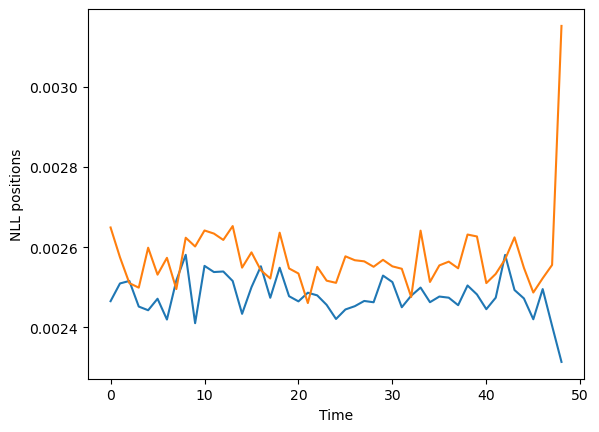

In [368]:
# NLL positions in time
plt.plot(nll_pos.mean(0).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL positions');

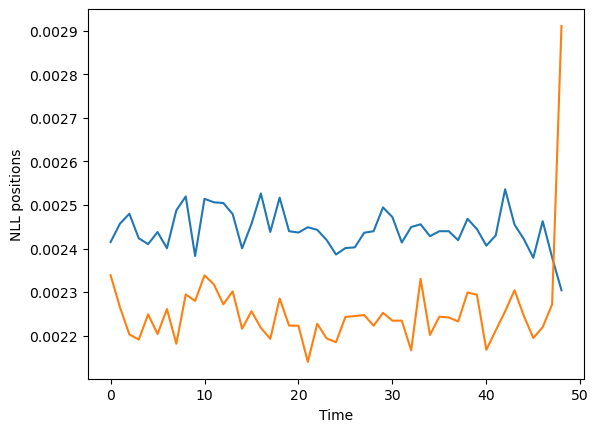

In [495]:
# NLL positions in time
plt.plot(nll_pos.mean(0).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL positions');

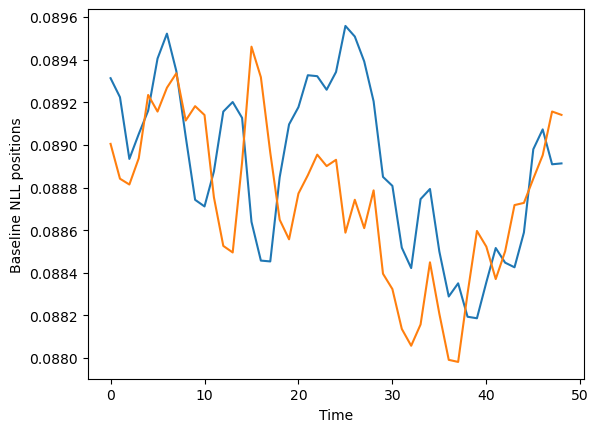

In [497]:
# NLL positions in time
plt.plot(nll_base[...,:2].mean((0,1)).cpu());
plt.gca().set( xlabel='Time', ylabel='Baseline NLL positions');

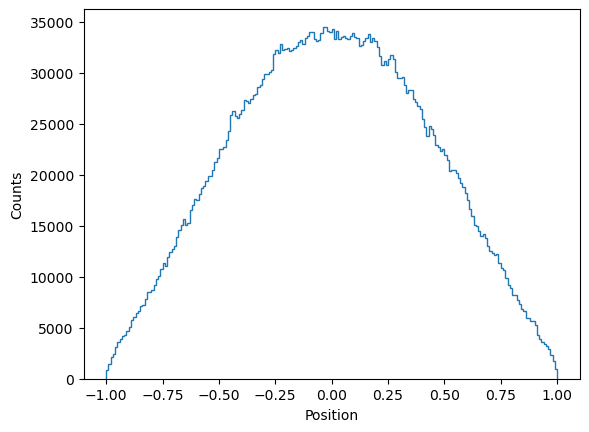

In [500]:
plt.hist(target[...,:2].reshape(-1).cpu(),200, histtype='step');
plt.gca().set( xlabel='Position', ylabel='Counts');

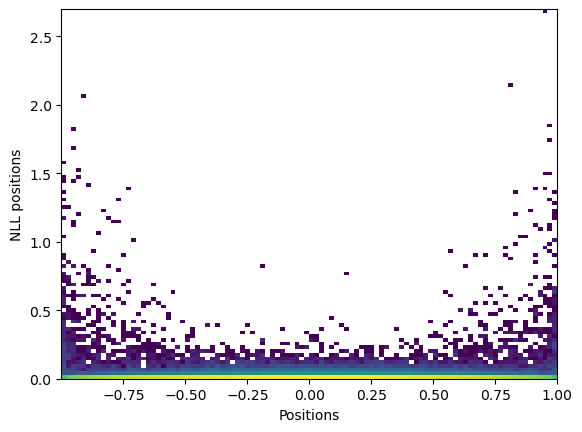

In [369]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll_pos.reshape(-1).cpu(),
           bins=100,norm='log');
plt.gca().set( xlabel='Positions', ylabel='NLL positions');

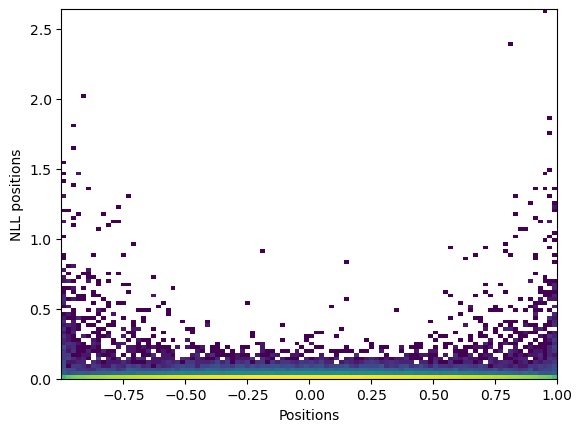

In [501]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll_pos.reshape(-1).cpu(),
           bins=100,norm='log');
plt.gca().set( xlabel='Positions', ylabel='NLL positions');

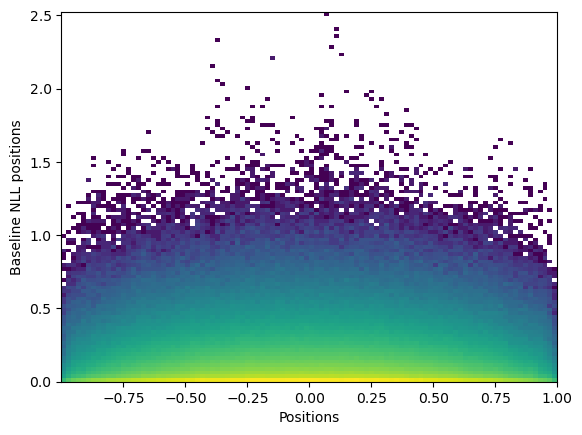

In [502]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll_base[...,:2].reshape(-1).cpu(),
           bins=100,norm='log');
plt.gca().set( xlabel='Positions', ylabel='Baseline NLL positions');

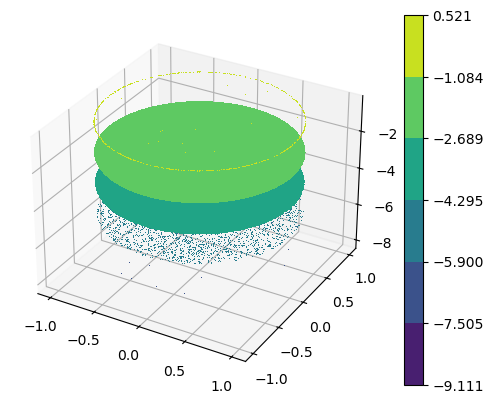

In [197]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = torch.log10(nll[...,0:2].sum(-1).reshape(-1).cpu())
levels = np.linspace(zs.min(), zs.max(), 7)
s = ax.tricontourf(xs, ys, zs, levels=levels)
plt.colorbar(s);
plt.gca().set( xlabel='x', ylabel='y', zlabel=r'$\log_{10}$ NLL');

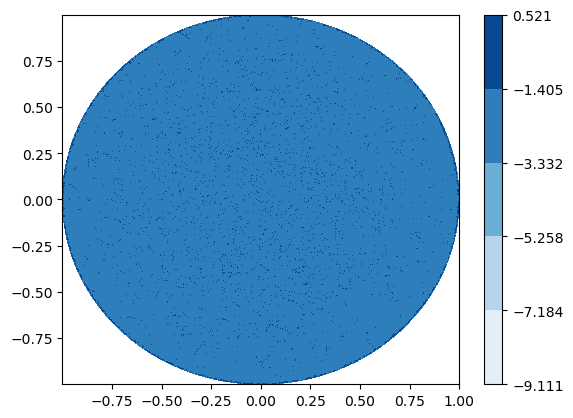

In [199]:
fig, ax = plt.subplots()
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
zs = torch.log10(zs)
# zs_ = zs>0.5
levels = np.linspace(zs.min(), zs.max(), 6)
s=ax.tricontourf(xs, ys, zs, levels=levels, cmap='Blues')
plt.colorbar(s, pad=0, label=r'$\log_{10}$ NLL');
plt.gca().set( xlabel='x', ylabel='y');

In [370]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

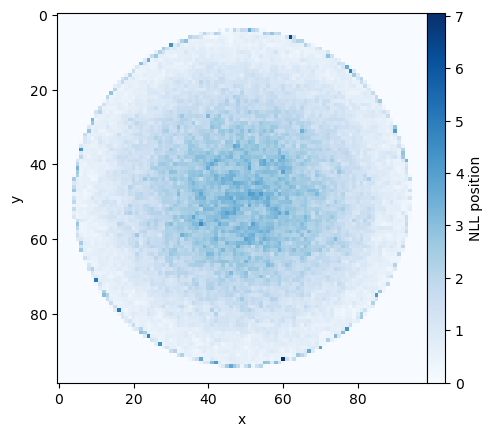

In [201]:
plt.imshow(bs.statistic, cmap='Blues',);
plt.colorbar(pad=0, label='NLL position');
plt.gca().set(xlabel='x',ylabel='y');

In [205]:
nll_base.shape

torch.Size([2000, 21, 49, 4])

In [206]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[:,:,:-10,0].reshape(-1).cpu(), target[:,:,:-10,1].reshape(-1).cpu()
zs = nll_base[:,:,:-10,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

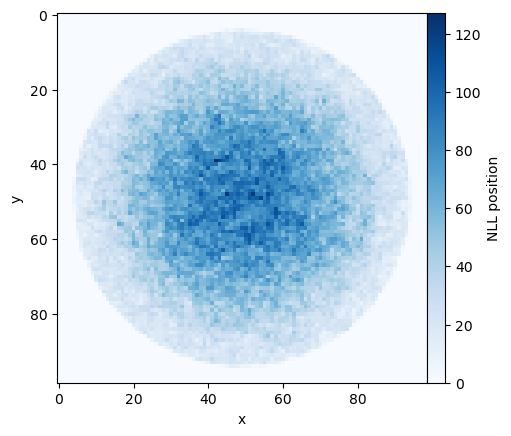

In [207]:
plt.imshow(bs.statistic, cmap='Blues',vmin=0);
plt.colorbar(pad=0, label='Baseline NLL position');
plt.gca().set(xlabel='x',ylabel='y');

In [208]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,2:].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

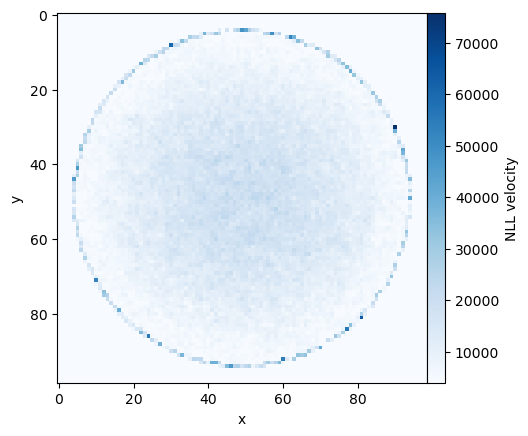

In [209]:
plt.imshow(bs.statistic, cmap='Blues',vmin=4000);
plt.colorbar(pad=0, label='NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

### Loss vs time and space

In [372]:
model.Rinterior

0.8

In [373]:
mask_loss = torch.linalg.norm(target[...,:2].flatten(end_dim=1), axis=-1)<model.Rinterior
mask_loss_b = torch.linalg.norm(node_feats_test[:,:,1:,:2], axis=-1)<model.Rinterior
idx_loss = torch.nonzero(mask_loss_b)

In [374]:
nll_base =((node_feats_test[:,:,:-1,][mask_loss_b] - target[mask_loss_b]) ** 2 / (2 * model.prior_variance))

In [375]:
nll_base.sum(-1).mean(), nll_base[...,:2].sum(-1).mean(), nll_base[...,2:].sum(-1).mean()

(tensor(80.8876, device='cuda:0'),
 tensor(0.1777, device='cuda:0'),
 tensor(80.7099, device='cuda:0'))

In [376]:
nll = ((all_preds - target.flatten(end_dim=1)) ** 2 / (2 * model.prior_variance))

In [377]:
nll[...,:2].sum(-1).mean(), nll[...,2:].sum(-1).mean()

(tensor(0.0051, device='cuda:0'), tensor(34.2614, device='cuda:0'))

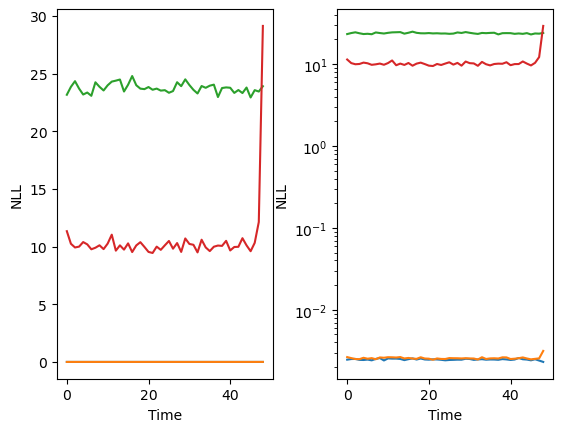

In [378]:
# NLL positions in time
fig, axs = plt.subplots(1,2, gridspec_kw=dict(wspace=0.3))
axs[0].plot(nll.mean(0).cpu());
axs[1].semilogy(nll.mean(0).cpu());
for ax in axs: ax.set(xlabel='Time',ylabel='NLL');

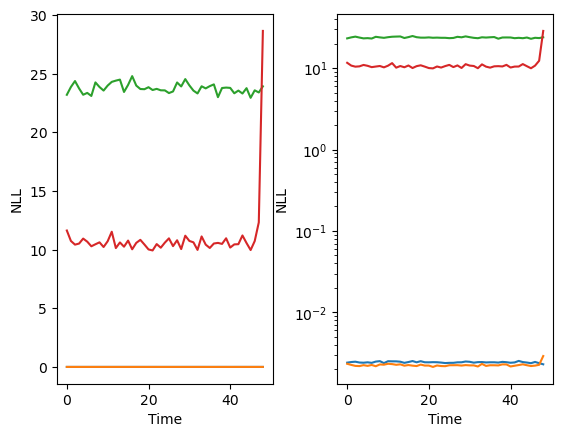

In [516]:
# NLL positions in time
fig, axs = plt.subplots(1,2, gridspec_kw=dict(wspace=0.3))
axs[0].plot(nll.mean(0).cpu());
axs[1].semilogy(nll.mean(0).cpu());
for ax in axs: ax.set(xlabel='Time',ylabel='NLL');

In [379]:
nll_logbins = np.geomspace(1e-8,2e4)

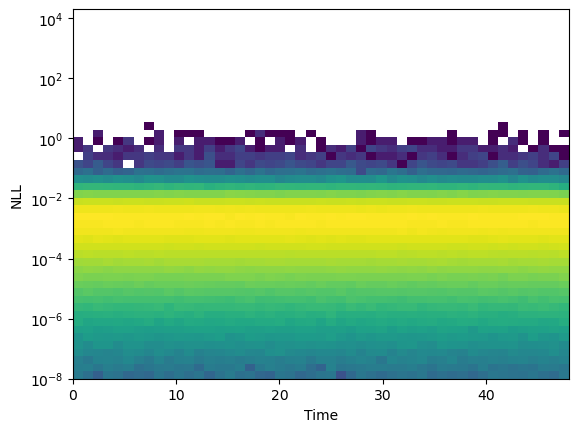

In [380]:
plt.hist2d(np.tile(np.arange(nll.shape[1]),nll.shape[0]).reshape(-1),
           nll[...,0].reshape(-1).cpu(),
           bins=[49,nll_logbins],norm='log');plt.yscale('log')
plt.gca().set(xlabel='Time',ylabel='NLL');

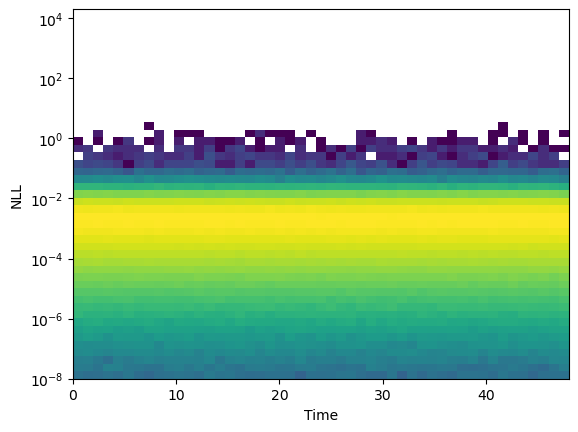

In [518]:
plt.hist2d(np.tile(np.arange(nll.shape[1]),nll.shape[0]).reshape(-1),
           nll[...,0].reshape(-1).cpu(),
           bins=[49,nll_logbins],norm='log');plt.yscale('log')
plt.gca().set(xlabel='Time',ylabel='NLL');

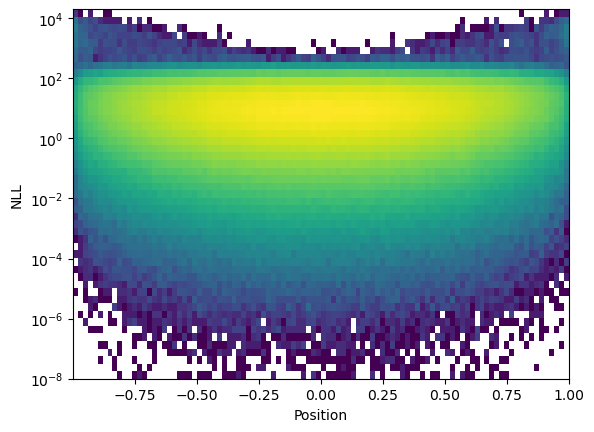

In [520]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll[...,2:].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set(xlabel='Position',ylabel='NLL');

In [521]:
nll[...,2:].min(), nll[...,2:].max()
nll_logbins = np.geomspace(1e-4,2e4)

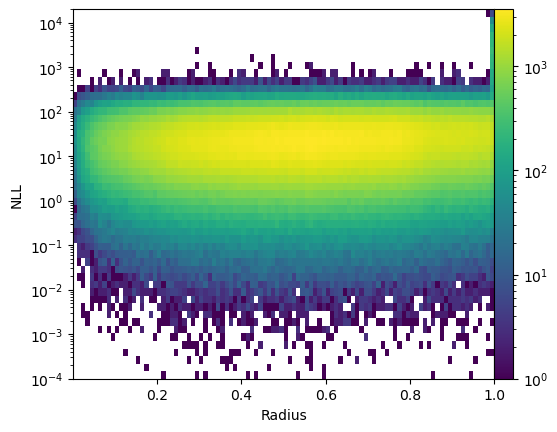

In [523]:
plt.hist2d(torch.hypot(target[...,0].reshape(-1),target[...,1].reshape(-1)).cpu(),
           torch.hypot(nll[...,2].reshape(-1),nll[...,3].reshape(-1)).cpu(),
           bins=[100,nll_logbins],norm='log');
plt.yscale('log');plt.colorbar(pad=0);
plt.gca().set(xlabel='Radius',ylabel='NLL');

In [242]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_3365049/4094421309.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


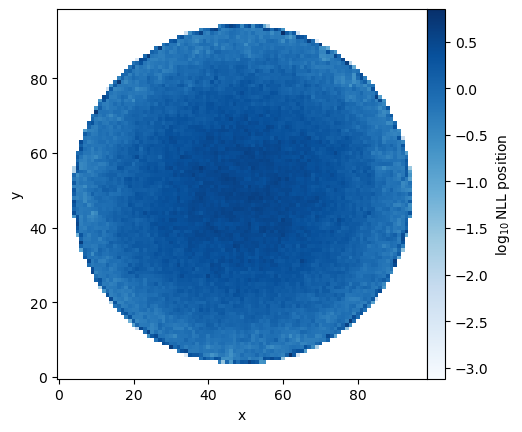

In [243]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

In [244]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,2:4].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_3365049/1568572802.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


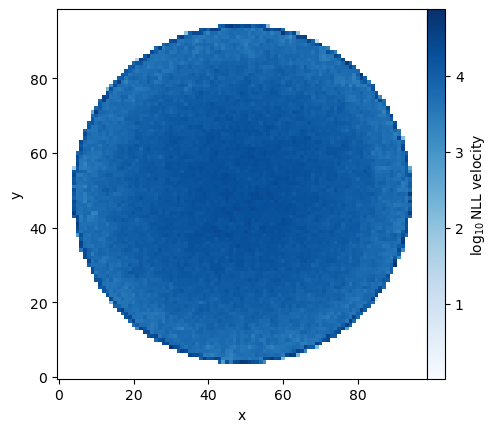

In [245]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

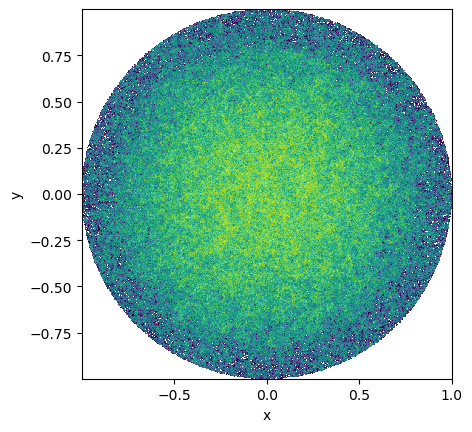

In [524]:
plt.hist2d(target[...,0].reshape(-1).cpu().numpy(),
           target[...,1].reshape(-1).cpu().numpy(), 500, norm='log');
plt.gca().set_aspect('equal');
plt.gca().set(xlabel='x',ylabel='y');

### Masked Loss vs time and space

In [525]:
node_feats_test.shape, mask_loss.shape

(torch.Size([2000, 21, 50, 4]), torch.Size([42000, 49]))

In [526]:
nll_base =((node_feats_test[:,:,:-1,][mask_loss_b] - target[mask_loss_b]) ** 2 / (2 * model.prior_variance))

In [527]:
nll_base.sum(-1).mean(), nll_base[...,:2].sum(-1).mean(), nll_base[...,2:].sum(-1).mean()

(tensor(80.8876, device='cuda:0'),
 tensor(0.1777, device='cuda:0'),
 tensor(80.7099, device='cuda:0'))

In [528]:
nll_nm = ((all_preds - target.flatten(end_dim=1)) ** 2 / (2 * model.prior_variance))
nll = nll_nm[mask_loss]

In [529]:
nll_nm.shape, nll.shape

(torch.Size([42000, 49, 4]), torch.Size([1694231, 4]))

In [530]:
nll[...,:2].sum(-1).mean(), nll[...,2:].sum(-1).mean()

(tensor(0.0046, device='cuda:0'), tensor(31.2586, device='cuda:0'))

In [531]:
mask_loss.shape

torch.Size([42000, 49])

In [532]:
idx_loss = torch.nonzero(mask_loss)

In [533]:
idx_loss.shape

torch.Size([1694231, 2])

In [534]:
nll_logbins = np.geomspace(1e-8,2e4)

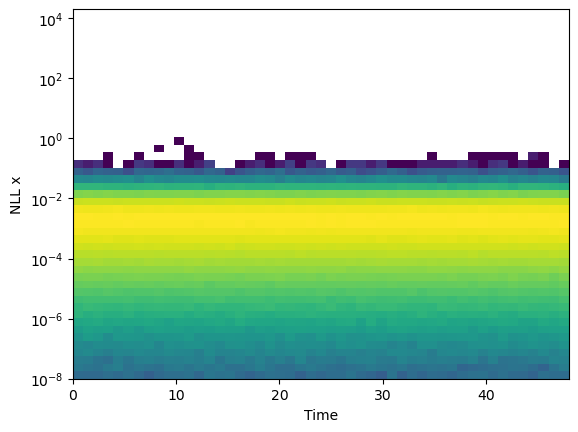

In [540]:
# NLL positions in time
plt.hist2d(idx_loss[:,1].cpu().numpy().reshape(-1),nll[...,0].cpu().numpy().reshape(-1),
           bins=[49,nll_logbins], norm='log');
plt.yscale('log');
plt.gca().set(xlabel='Time',ylabel='NLL x');

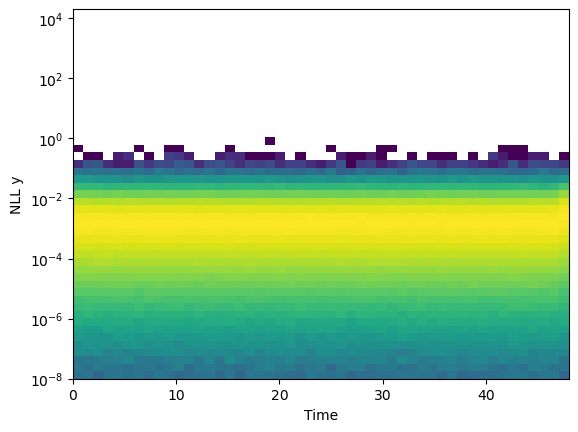

In [541]:
# NLL positions in time
plt.hist2d(idx_loss[:,1].cpu().numpy().reshape(-1),nll[...,1].cpu().numpy().reshape(-1),
           bins=[49,nll_logbins], norm='log');
plt.yscale('log');
plt.gca().set(xlabel='Time',ylabel='NLL y');

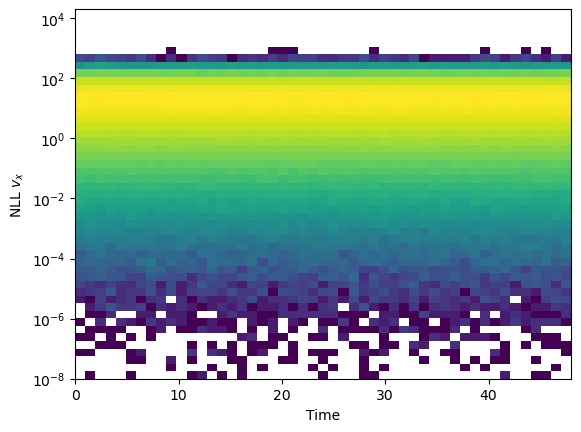

In [542]:
# NLL positions in time
plt.hist2d(idx_loss[:,1].cpu().numpy().reshape(-1),nll[...,2].cpu().numpy().reshape(-1),
           bins=[49,nll_logbins], norm='log');
plt.yscale('log');
plt.gca().set(xlabel='Time',ylabel='NLL '+r'$v_x$');

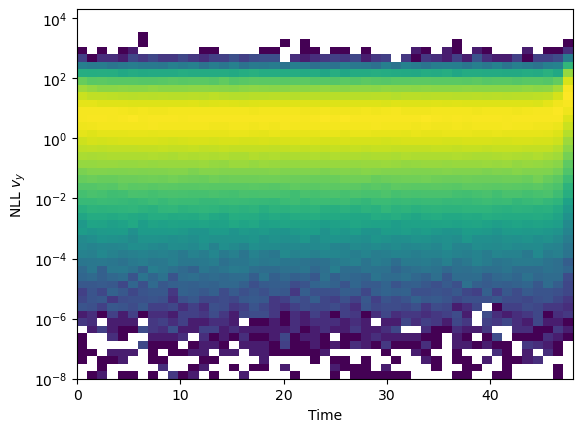

In [543]:
# NLL positions in time
plt.hist2d(idx_loss[:,1].cpu().numpy().reshape(-1),nll[...,3].cpu().numpy().reshape(-1),
           bins=[49,nll_logbins], norm='log');
plt.yscale('log');
plt.gca().set(xlabel='Time',ylabel='NLL '+r'$v_y$');

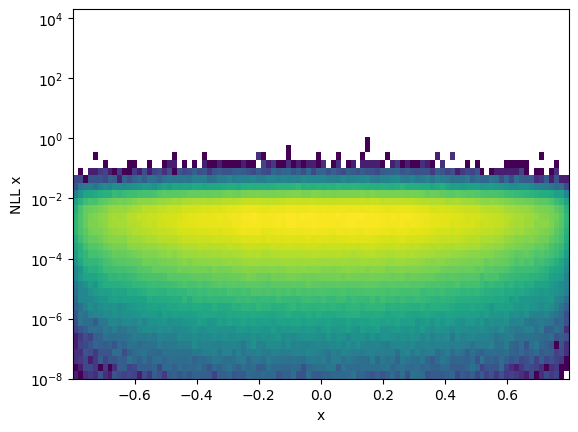

In [544]:
plt.hist2d(target[mask_loss_b][...,0].reshape(-1).cpu(),
           nll[...,0].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set(xlabel='x',ylabel='NLL x');

In [545]:
nll[...,2:].min(), nll[...,2:].max()
nll_logbins = np.geomspace(1e-4,2e4)

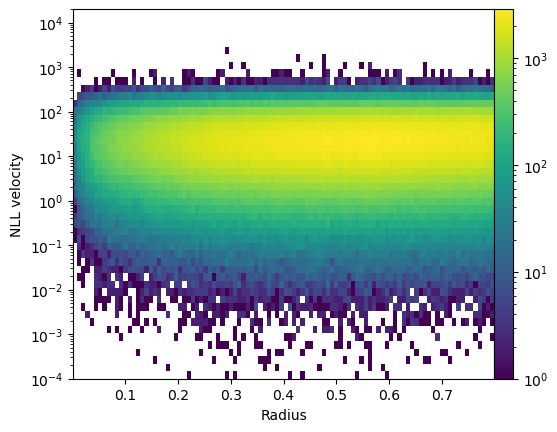

In [546]:
plt.hist2d(torch.hypot(target[mask_loss_b][...,0].reshape(-1),target[mask_loss_b][...,1].reshape(-1)).cpu(),
           torch.hypot(nll[...,2].reshape(-1),nll[...,3].reshape(-1)).cpu(),
           bins=[100,nll_logbins],norm='log');
plt.yscale('log');plt.colorbar(pad=0);
plt.gca().set(xlabel='Radius',ylabel='NLL velocity');

In [547]:
edge_feats_test.shape, mask_loss_b.shape, nll_nm.shape

(torch.Size([2000, 420, 50, 3]),
 torch.Size([2000, 21, 49]),
 torch.Size([42000, 49, 4]))

In [548]:
torch.min(edge_feats_test[...,:-1,0],dim=1).indices.shape

torch.Size([2000, 49])

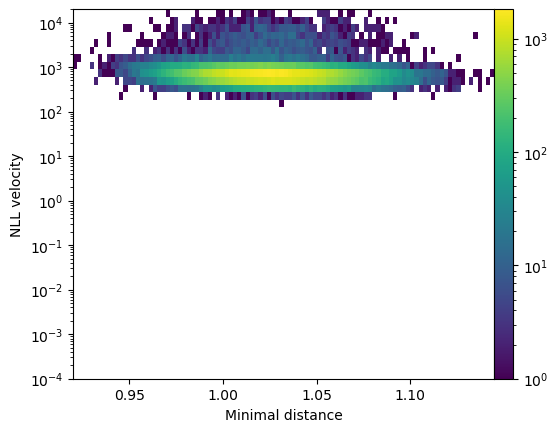

In [554]:
plt.hist2d((torch.min(edge_feats_test[...,:-1,0],dim=1).values).reshape(-1).cpu().numpy()*norm.cpu().numpy(),
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2).sum((1,-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.axvline(1.5);
plt.gca().set(xlabel='Minimal distance',ylabel='NLL velocity');

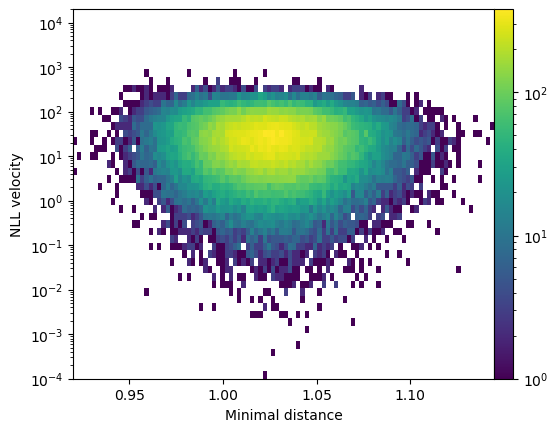

In [555]:
plt.hist2d((norm*torch.min(edge_feats_test[...,:-1,0],dim=1).values)[mask_loss_b[:,-1]].reshape(-1).cpu().numpy(),
           # particle --------------------------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,-1].sum((-1))[mask_loss_b[:,-1]].reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.axvline(1.5);
plt.gca().set(xlabel='Minimal distance',ylabel='NLL velocity');

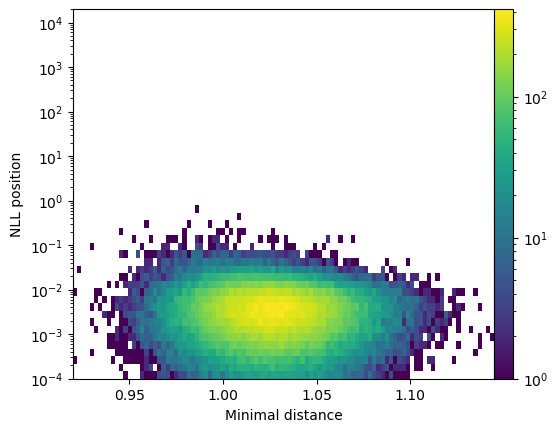

In [556]:
plt.hist2d((norm*torch.min(edge_feats_test[...,:-1,0],dim=1).values)[mask_loss_b[:,-1]].reshape(-1).cpu().numpy(),
           # particle -------------------------------------------v
           nll_nm[...,:2].reshape(-1,params['num_vars'],49,2)[:,-1].sum((-1))[mask_loss_b[:,-1]].reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.axvline(1.5);
plt.gca().set(xlabel='Minimal distance',ylabel='NLL position');

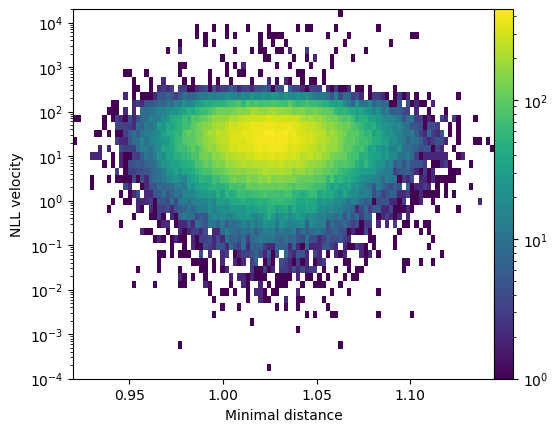

In [568]:
plt.hist2d(norm*torch.min(edge_feats_test[...,:-1,0],dim=1).values.reshape(-1).cpu().numpy(),
           # particle --------------------------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,-2].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Minimal distance',ylabel='NLL velocity');

In [558]:
edge_feats_test.shape, torch.min(edge_feats_test[...,:-1,0],dim=1).indices.shape, mask_loss_b.shape

(torch.Size([2000, 420, 50, 3]),
 torch.Size([2000, 49]),
 torch.Size([2000, 21, 49]))

In [559]:
edge_feats_test.shape,  mask_loss_b.shape, #torch.min(edge_feats_test[...,:-1,0],dim=1).indices.shape,

(torch.Size([2000, 420, 50, 3]), torch.Size([2000, 21, 49]))

In [560]:
min_d_idx = torch.min(edge_feats_test[...,:-1,0],dim=1).indices
min_d_idx_masked = min_d_idx[mask_loss_b[:,-1]]

In [561]:
min_d_idx.shape, min_d_idx_masked.shape

(torch.Size([2000, 49]), torch.Size([80583]))

In [562]:
torch.take_along_dim(edge_feats_test[...,:-1,2],
                     dim=1, indices=min_d_idx[:,None]).squeeze().shape

torch.Size([2000, 49])

In [563]:
edge_feats_test = edge_feats_test.cpu()
min_d_idx = min_d_idx.cpu()
mask_loss_b = mask_loss_b.cpu()

In [564]:
edge_feats_test_dx = torch.take_along_dim(edge_feats_test[...,:-1,1],
                     dim=1, indices=min_d_idx[:,None]).squeeze()
edge_feats_test_dy = torch.take_along_dim(edge_feats_test[...,:-1,2],
                     dim=1, indices=min_d_idx[:,None]).squeeze()
angles = torch.atan2(edge_feats_test_dx,edge_feats_test_dy).numpy()
angles = np.where(angles<0,angles+2*np.pi, angles)

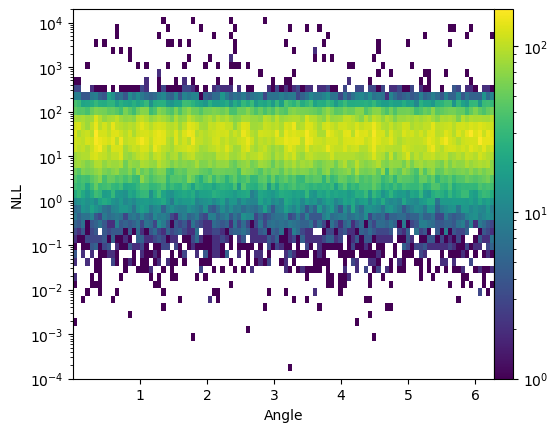

In [569]:
plt.hist2d(angles.reshape(-1),
           # particle 0 -----------------------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,0].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

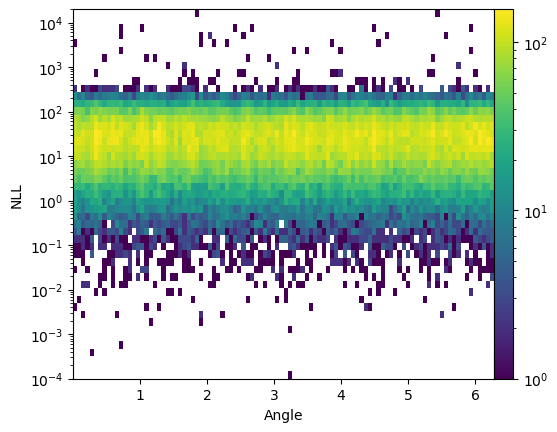

In [570]:
plt.hist2d(angles.reshape(-1),
           # particle --------------------------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,-1].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

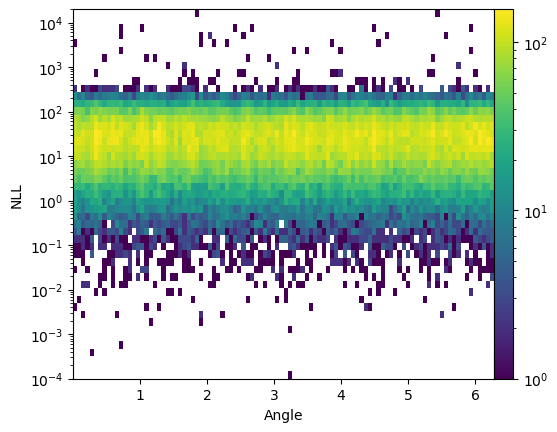

In [571]:
angles = torch.atan2(edge_feats_test[:,1,:-1,1],
                     edge_feats_test[:,1,:-1,2]).reshape(-1).cpu().numpy()
angles = np.where(angles<0,angles+2*np.pi, angles)
plt.hist2d(angles,
           # particle 2 -----------------------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,-1].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

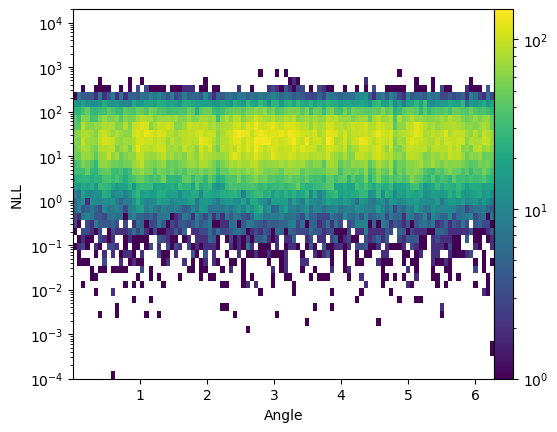

In [572]:
angles = torch.atan2(edge_feats_test[:,3,:-1,1][mask_loss_b[:,-1]],
                     edge_feats_test[:,3,:-1,2][mask_loss_b[:,-1]]).reshape(-1).cpu().numpy()
angles = np.where(angles<0,angles+2*np.pi, angles)
plt.hist2d(angles,
           # particle 2 ------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,-1][mask_loss_b[:,-1]].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

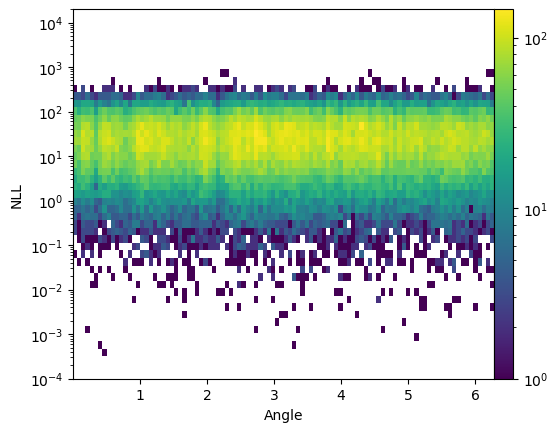

In [573]:
j=2  # particle
l=3  # edge
angles = torch.atan2(edge_feats_test[:,l,:-1,1][mask_loss_b[:,j]],
                     edge_feats_test[:,l,:-1,2][mask_loss_b[:,j]]).reshape(-1).cpu().numpy()
angles = np.where(angles<0,angles+2*np.pi, angles)
plt.hist2d(angles,
           # particle 2 ------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,j][mask_loss_b[:,j]].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

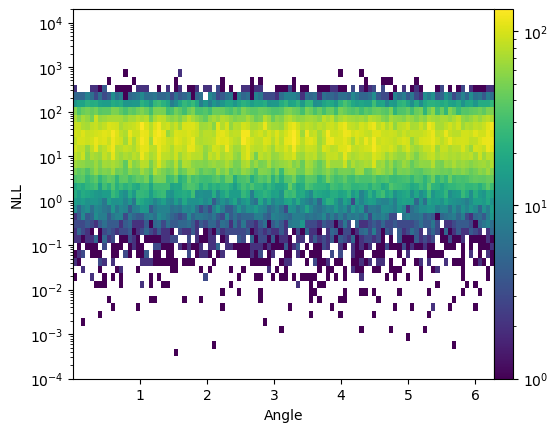

In [574]:
j=2  # particle
l=1  # edge
angles = torch.atan2(edge_feats_test[:,l,:-1,1][mask_loss_b[:,j]],
                     edge_feats_test[:,l,:-1,2][mask_loss_b[:,j]]).reshape(-1).cpu().numpy()
angles = np.where(angles<0,angles+2*np.pi, angles)
plt.hist2d(angles,
           # particle 2 ------------------------v
           nll_nm[...,2:4].reshape(-1,params['num_vars'],49,2)[:,j][mask_loss_b[:,j]].sum((-1)).reshape(-1).cpu().numpy(),
           bins=[100,nll_logbins], norm='log');
plt.yscale('log'); plt.colorbar(pad=0);
plt.gca().set(xlabel='Angle',ylabel='NLL');

In [291]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[mask_loss_b][...,0].reshape(-1).cpu(), target[mask_loss_b][...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_3365049/4094421309.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


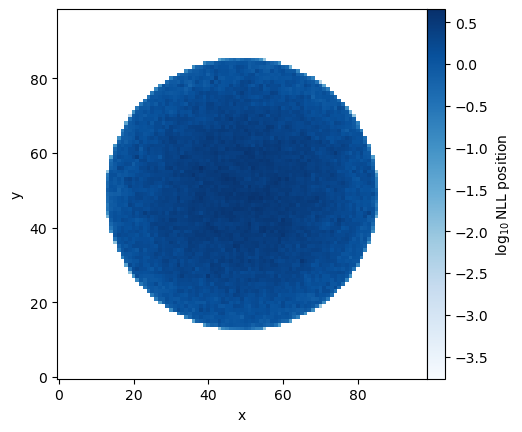

In [292]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

In [293]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[mask_loss_b][...,0].reshape(-1).cpu(), target[mask_loss_b][...,1].reshape(-1).cpu()
zs = nll[...,2:4].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_3365049/1568572802.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


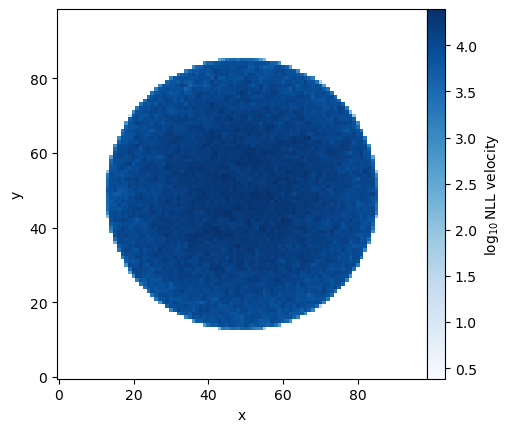

In [294]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

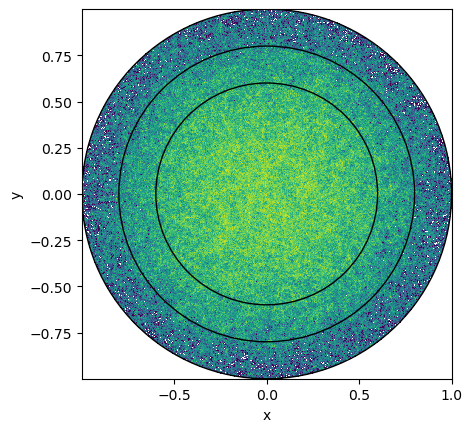

In [575]:
plt.hist2d(target[...,0].reshape(-1).cpu().numpy(),
           target[...,1].reshape(-1).cpu().numpy(), 500, norm='log');
plt.gca().add_patch(plt.Circle((0,0),.6,fill=None));
plt.gca().add_patch(plt.Circle((0,0),.8,fill=None));
plt.gca().add_patch(plt.Circle((0,0),1.,fill=None));
plt.gca().set_aspect('equal');
plt.gca().set(xlabel='x',ylabel='y');

## Raw preds

In [578]:
target.shape, all_preds.shape

(torch.Size([2000, 21, 49, 4]), torch.Size([42000, 49, 4]))

In [579]:
target_b = target

In [580]:
predictions_b = all_preds.reshape(-1,params['num_vars'],49,4)
predictions_b.shape

torch.Size([2000, 21, 49, 4])

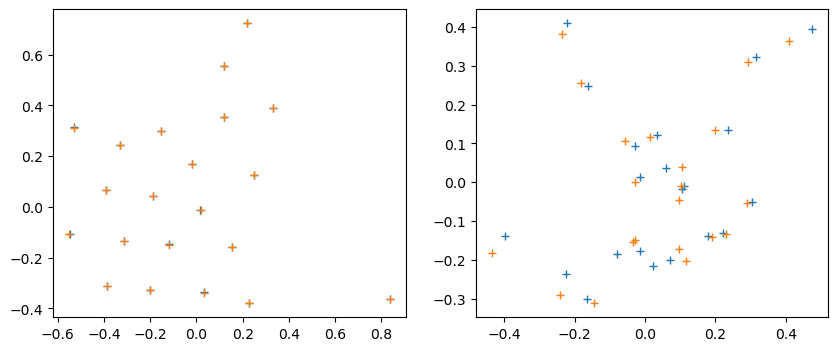

In [581]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
j = 1 # particle
axs[0].plot(*target_b[i,:,j,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,j,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,j,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,j,2:].T.cpu(), '+');

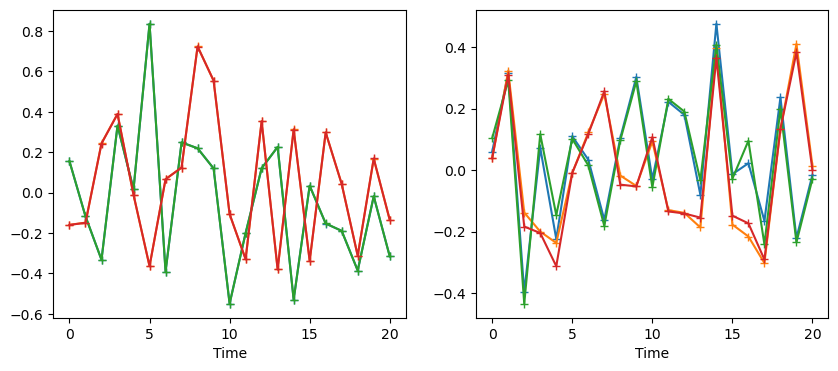

In [582]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,j,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,j,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,j,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,j,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

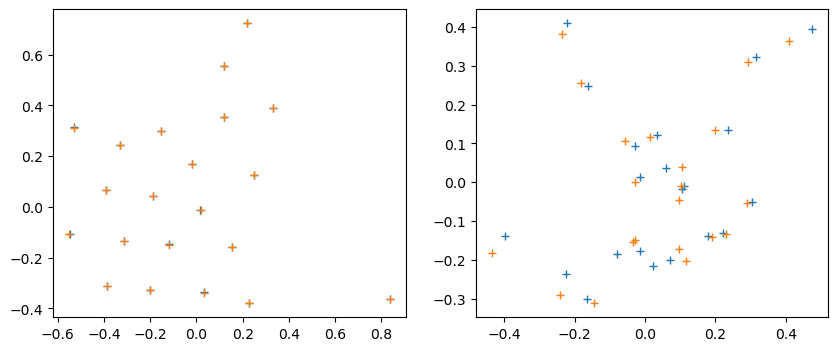

In [587]:
i=0
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(*target_b[i,:,j,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,j,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,j,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,j,2:].T.cpu(), '+');

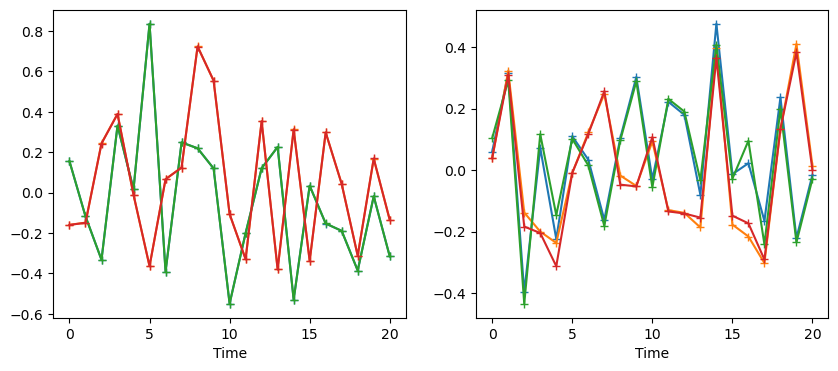

In [588]:
i=0
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,j,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,j,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,j,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,j,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

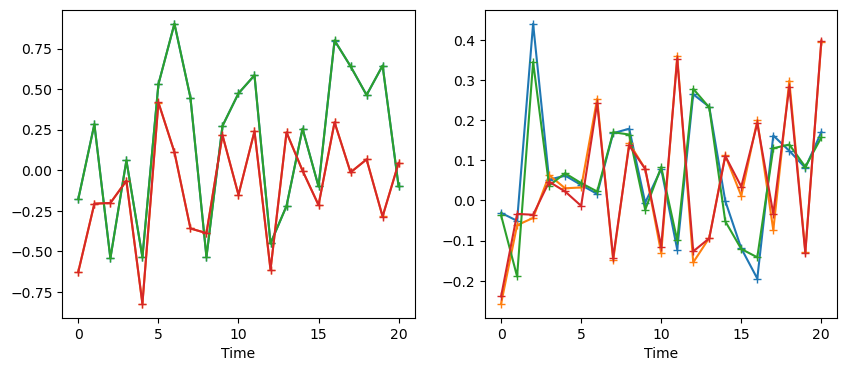

In [589]:
i=1
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,j,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,j,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,j,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,j,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

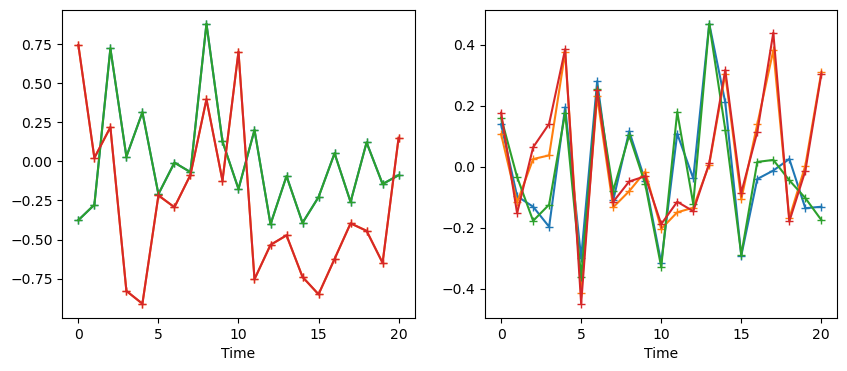

In [590]:
i=21
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,j,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,j,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,j,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,j,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

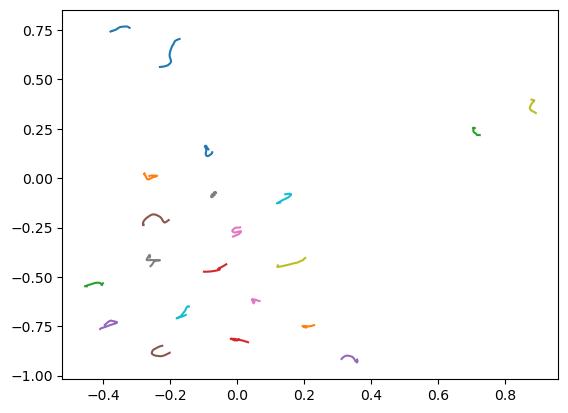

In [591]:
for j in range(N):
    plt.plot(*target_b[i,j,:30,:2].cpu().T);

## 1 MSE vs time

In [214]:
def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps,
                            params, return_total_errors=False,bs=None):
    batch_size = params.get('batch_size', 128) if bs is None else bs
    data_loader = DataLoader(dataset, batch_size=batch_size,drop_last=True)# pin_memory=gpu)
    model.eval()
    model.to(dvc)
    total_se = 0
    batch_count = 0
    all_errors = []
    preds = []
    edges = []
    bs = 0
    for batch_ind, batch in tqdm(enumerate(data_loader)):
        node_feats, edge_feats, edge_index = getattrs(batch,['node_feats','edge_feats', 'edge_index'])
        with torch.inference_mode():
            model_inputs = Data(node_feats=node_feats[:,:burn_in_steps],
                                edge_feats=edge_feats[:,:burn_in_steps],
                                edge_index=edge_index,
                                batch=batch.batch
                               )
            model_preds, model_edges = model.predict_future(model_inputs,
                                                            forward_pred_steps,
                                                            return_edges=True,
                                                            return_everything=True)
            preds.append(model_preds)
            edges.append(model_edges)
            # BN, T-1, F
            gt_predictions = node_feats[:,1:] #if True else node_feats[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            batch_count += 1
            mse = F.mse_loss(model_preds,gt_predictions,reduction='none')
            # here bounces have little effect
            # mask_bound = torch.linalg.norm(gt_predictions[...,:2], axis=-1)>model.Rinterior
            # mse[mask_bound] = 0.
            mse = mse.mean(dim=-1)
            if return_total_errors:
                all_errors.append(mse)
            else:
                total_se += mse.sum(dim=0) # T-1
        bs+=len(batch.batch.unique()) # +B
    if return_total_errors:
        return torch.cat(all_errors, dim=0), torch.cat(preds,dim=0), torch.cat(edges,dim=0)
    else:
        return total_se / bs  # bs=len(dataset)

In [ ]:
params['data_path']

In [ ]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
forward_pred = test_data.node_feats.shape[2] - params['test_burn_in_steps']  # 50-10
test_mse, test_preds, test_edges = eval_forward_prediction(model,
                                    test_data.datalist,
                                    params['test_burn_in_steps'],
                                    forward_pred, params,
                                    return_total_errors=True,
                                    bs=100
                                   )
test_mse = test_mse.cpu()
path = os.path.join(params['working_dir'], '2024_'+params['error_out_name']%params['test_burn_in_steps'])
#np.save(path, test_mse.cpu().numpy())
print(path)

In [50]:
# np.save('draft/'+'LJ21_'+'test_mse_burninsteps10', test_mse.cpu().numpy())

In [ ]:
params['data_path'], test_preds.shape, test_data.node_feats.shape

In [382]:
test_mse_1  = test_mse.mean(0)[0].item()
test_mse_15 = test_mse.mean(0)[14].item()
test_mse_25 = test_mse.mean(0)[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)

FORWARD PRED RESULTS:
	1 STEP:  0.001326634781435132
	15 STEP:  0.007457863073796034
	25 STEP:  0.020555313676595688


In [44]:
test_preds.shape,test_mse.shape

(torch.Size([42000, 49, 4]), torch.Size([42000, 49]))

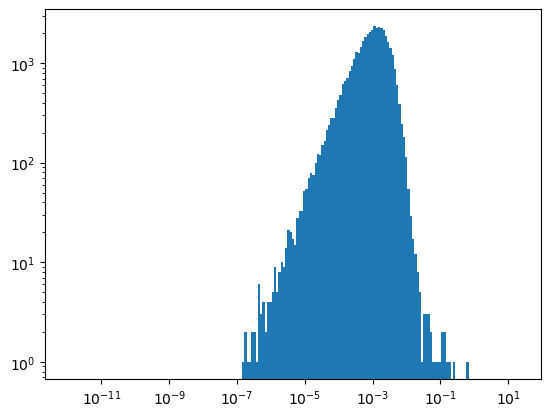

In [45]:
plt.hist(test_mse[:,0], bins=np.concatenate([[0],np.geomspace(1e-12,2e1,200)]), log=True); plt.xscale('log');

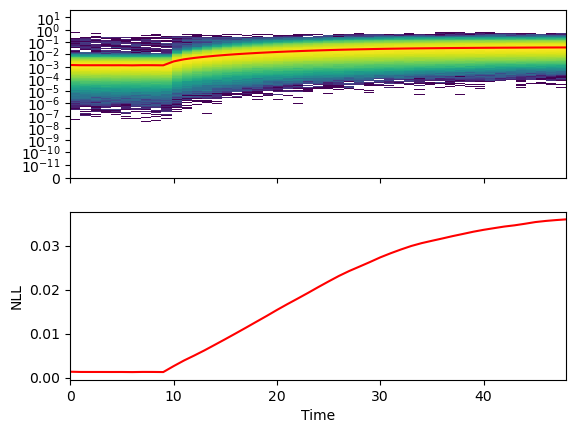

In [383]:
logbins = np.concatenate([[0],np.geomspace(1e-11,4e1,200)])
fig,axs = plt.subplots(2,1, sharex=True )#figsize=(12,4))
axs = axs.flatten()
axs[0].hist2d(np.tile(np.arange(test_mse.shape[-1]),test_mse.shape[0]),
           test_mse.reshape(-1),
           bins = [49,logbins], norm='log'
          );
axs[0].plot(test_mse.mean(0),'r')
axs[0].set_yscale('symlog', linthresh=1e-11)
axs[1].plot(test_mse.mean(0),'r');
axs[1].set_xlabel('Time');axs[1].set_ylabel('NLL');

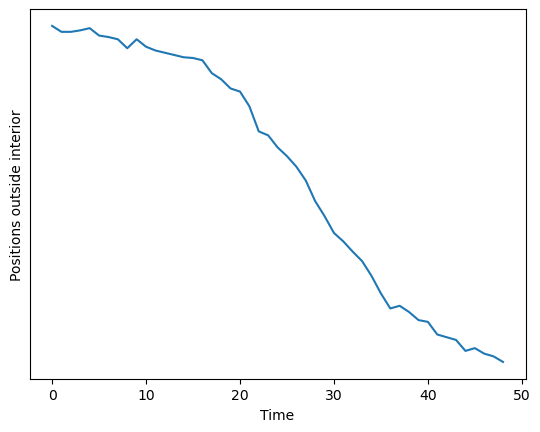

In [47]:
plt.semilogy((test_preds[:,:,:2]>model.Rinterior).any(-1).sum(0).cpu().numpy());
plt.gca().set( xlabel='Time',ylabel='Positions outside interior', yscale='symlog');

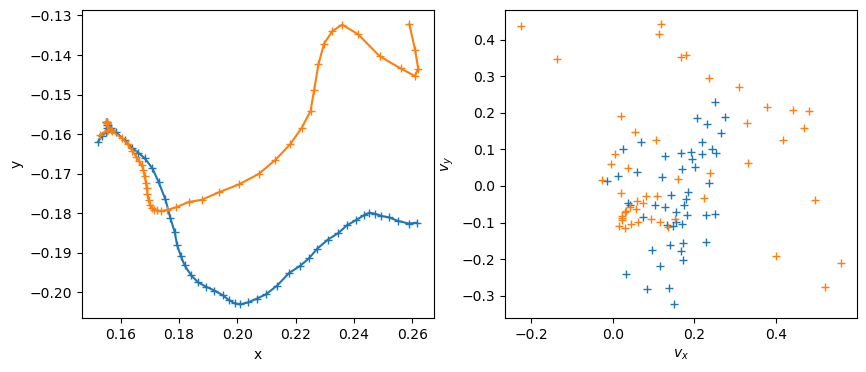

In [48]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
i=0; j=0
axs[0].plot(*test_data.node_feats.reshape(-1,50,4)[i+N*j,:,:2].T.cpu().numpy(),'+-');
axs[0].plot(*test_preds[i+j*N,:,:2].T.cpu().numpy(),'+-');
axs[0].set_xlabel('x');axs[0].set_ylabel('y');
axs[1].plot(*test_data.node_feats[i,j,:,2:].T.cpu().numpy(), '+');
axs[1].plot(*test_preds[i+j*N,:,2:].T.cpu().numpy(), '+');
axs[1].set_xlabel(r'$v_x$');axs[1].set_ylabel(r'$v_y$');

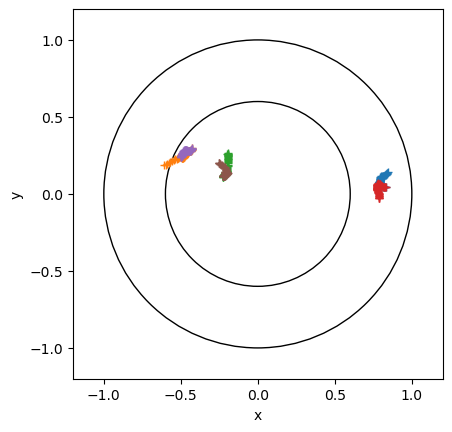

In [49]:
i=6
plt.plot(*test_preds[i*N-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-3,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-3,:,:2].T.cpu().numpy(),'+-');
plt.gca().add_patch(plt.Circle((0,0),.6,fill=None));
plt.gca().add_patch(plt.Circle((0,0),1.,fill=None));
plt.xlim(-1.2,1.2);plt.ylim(-1.2,1.2);
plt.gca().set_aspect('equal');
plt.xlabel('x');plt.ylabel('y');

## 2 Edges

### Edge visual structure

In [135]:
edges_ = edges + false_edges

In [268]:
# predicted edges, true
edges_b.shape, edges_pred.shape, edges_true.shape, edges_true_.shape

(torch.Size([2000, 420, 49, 2]),
 torch.Size([2000, 49, 420]),
 torch.Size([2000, 50, 420]),
 torch.Size([2000, 49, 420]))

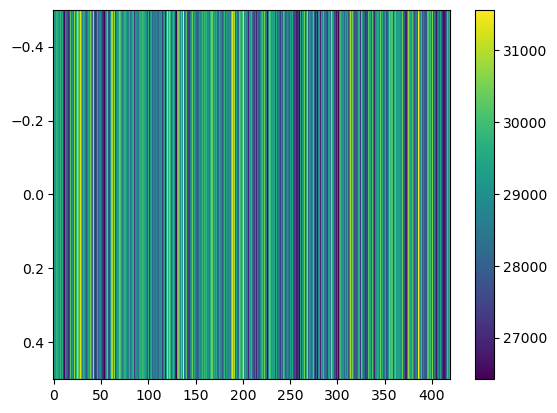

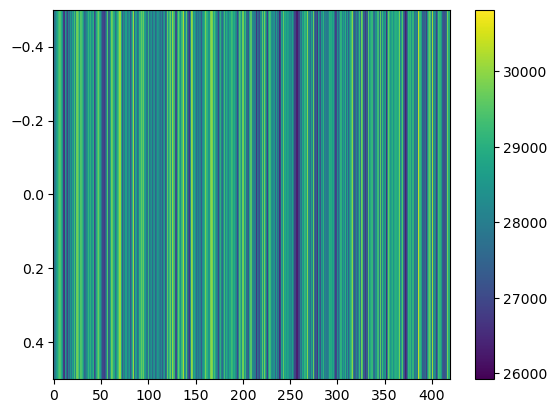

In [269]:
h = plt.imshow((edges_true[:,1:].to(bool).numpy().reshape(-1,edges_true.shape[-1])==True).sum(0)[None], aspect='auto', interpolation='none');
cbar = plt.colorbar(h)
plt.figure();
h=plt.imshow((torch.argmax(edges_b,dim=-1).long().transpose(1,-1).cpu().numpy().reshape(-1,edges_b.shape[1])!=0).sum(0)[None], aspect='auto', cmap=cbar.cmap);
cbar = plt.colorbar(h)

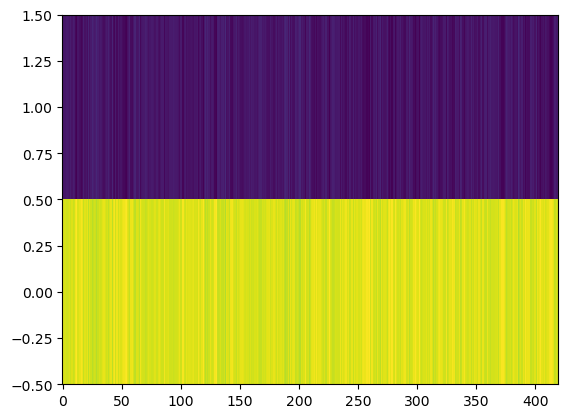

In [272]:
plt.imshow(get_edges_count_table(edges_true_, dim=2),origin='lower', aspect='auto', interpolation='none');

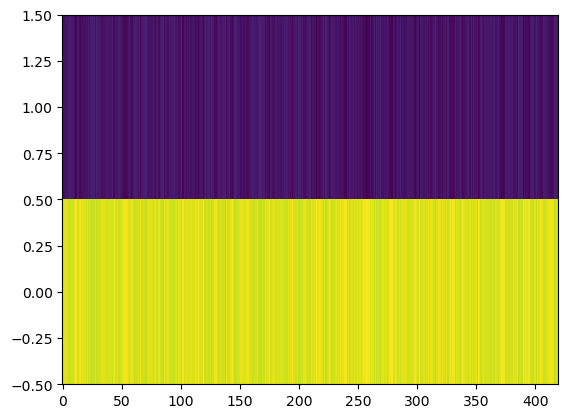

In [273]:
plt.imshow(get_edges_count_table(edges_pred, dim=2),origin='lower', aspect='auto', interpolation='none');

In [299]:
np.savez_compressed("draft/LJ21_edge_structure",
                    N=N,
                    edges_pred=edges_pred.numpy(),
                    row_idx=row_idx, col_idx=col_idx
                   )

In [287]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred[0,0].numpy()

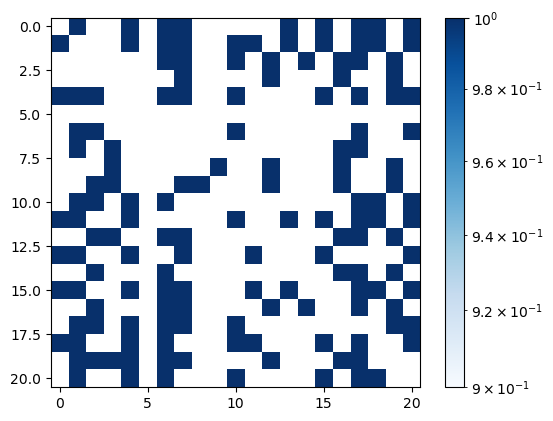

In [288]:
plt.imshow(adjacency_types, cmap='Blues', norm='log', vmin=.9); plt.colorbar();

In [289]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred[0].sum(0).numpy()

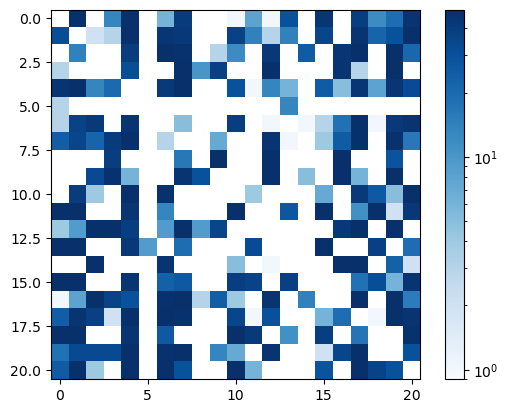

In [290]:
plt.imshow(adjacency_types, cmap='Blues', norm='log', vmin=.9); plt.colorbar();

In [293]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred.sum((0,1)).numpy()

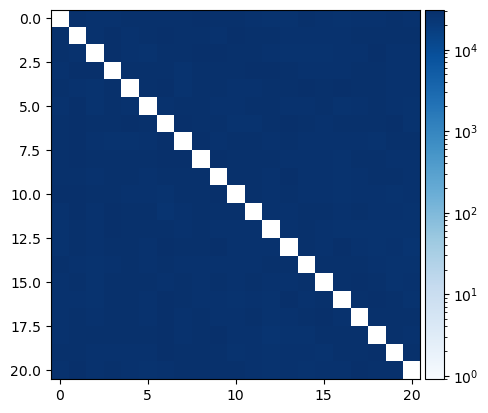

In [298]:
plt.imshow(adjacency_types, cmap='Blues', norm='log', vmin=.9); plt.colorbar(pad=0.01);

### Spurious edges due to small messages

In [464]:
edge_feats.shape, edges.shape

(torch.Size([2000, 420, 50, 3]), torch.Size([840000, 49, 2]))

In [384]:
with torch.inference_mode() and dvc:
    eps = 1e-3
    start_idx = 1 if model.decoder.skip_first_edge_type else 0
    false_edges = torch.zeros_like(edges)  # to correct predicted edges
    assert model.train_hard_sample
    datalist_ = [Data(edge_feats=e, edge=ed)
                 for e,ed in zip(edge_feats[:,:,:-1],
                                 edges.reshape(*edge_feats.shape[:2],
                                               *edges.shape[-2:]))]
    print(f'{len(datalist_)=}')
    dl_ = DataLoader(datalist_, batch_size=batch_size, follow_batch=["edge"])
    # batching-------------------
    bi=0
    for b in tqdm(dl_):
        edge_feats_ = b['edge_feats']
        edges_ = b['edge']

        d = edge_feats_[...,0:1]  # (B*E,T,1) distances
        v = edge_feats_[...,1: ]  # (B*E,T,2) versor
        for i in range(len(model.decoder.edge_functions)):
            msg = model.decoder.edge_functions[i](d)*v    # BE, T, 2
            msg_near_zero = msg.abs().sum(-1)<eps
            # spurious = near zero and predicted as interacting edge
            false_edges[bi:bi+b.edge_ptr[-1],:,i+start_idx] = 1.*(msg_near_zero*edges_[...,i+start_idx])
        bi +=b.edge_ptr[-1]
        #print(bi.item())

    false_edges[...,0] = false_edges[...,start_idx:].sum(-1)
    false_edges[...,start_idx:] = -false_edges[...,start_idx:]
torch.cuda.empty_cache()

len(datalist_)=2000


  0%|          | 0/63 [00:00<?, ?it/s]

In [250]:
false_edges.shape

torch.Size([840000, 49, 2])

In [251]:
edge_shape = edge_feats.shape[0],params['num_vars']*(params['num_vars']-1),edge_feats.shape[-2]-1,params['num_edge_types']

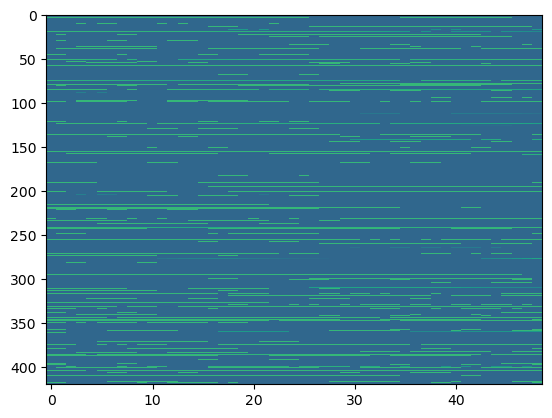

In [260]:
plt.imshow(false_edges.reshape(edge_shape)[0,...,0].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');

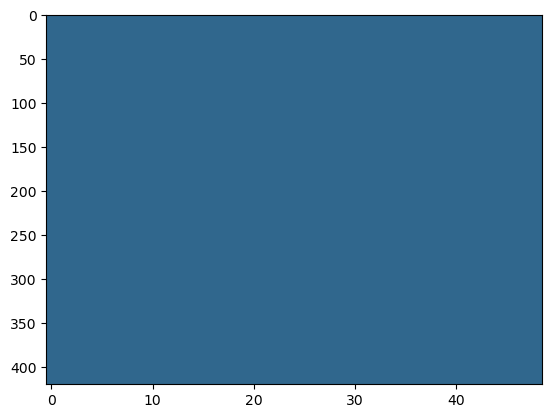

In [253]:
plt.imshow(edges.reshape(edge_shape)[0,...,0].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');

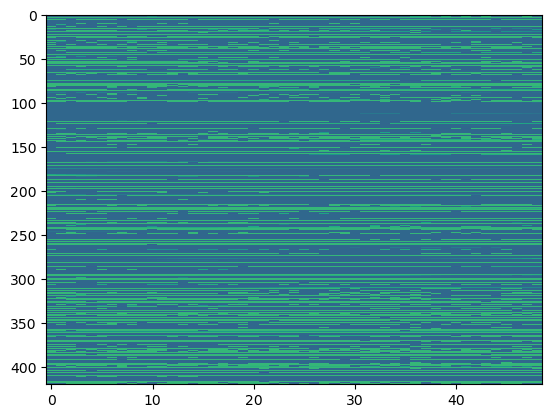

In [254]:
plt.imshow(edges.reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');

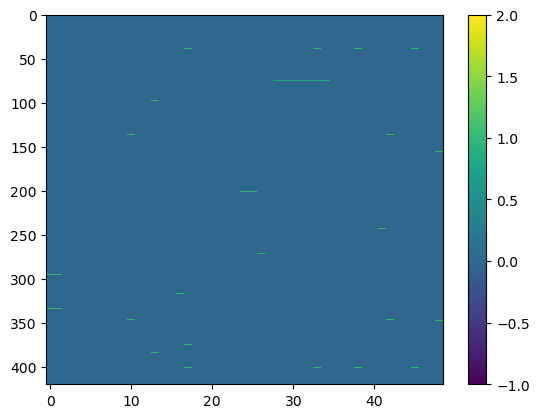

In [255]:
plt.imshow((edges+false_edges).reshape(edge_shape)[0,...,0].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.colorbar();

In [385]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary'), None

def f1_score_dnri_(edges_pred, edges_true_,):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return [f1_score(edges_true_[...,i].reshape(-1),
                    edges_pred[...,i].reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary')
           for i in range(edges_pred.shape[-1])]

In [386]:
edges_order = [0,1]

In [387]:
f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.8247020687575161, None)

In [388]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.8239477846611694, None)

In [227]:
f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.8247840421701615, None)

In [263]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.8240457476547727, None)

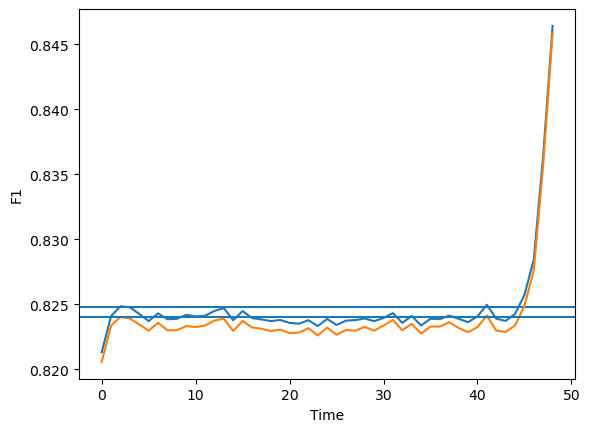

In [264]:
f1_test = f1_score_dnri_((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_mean = np.mean(f1_test)
plt.plot(f1_test);plt.axhline(f1_test_mean);

f1_test_false = f1_score_dnri_((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_false_mean = np.mean(f1_test_false)
plt.plot(f1_test_false);plt.axhline(f1_test_false_mean);
plt.gca().set( xlabel='Time', ylabel='F1');

In [389]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [390]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.901 0.099]
 [0.255 0.745]]
[[26140470  2880718]
 [ 3090352  9048460]]


In [229]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [230]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.901 0.099]
 [0.254 0.746]]
[[26137527  2883661]
 [ 3085719  9053093]]


In [231]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

In [232]:
cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [233]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.901 0.099]
 [0.254 0.746]]
[[26137720  2883468]
 [ 3086216  9052596]]


In [601]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
edges_true = test_data.edges

In [602]:
edges.shape, edges_true.shape

(torch.Size([840000, 49, 2]), torch.Size([2000, 50, 420]))

In [603]:
edges = edges + false_edges

In [604]:
edge_feats_batch = Batch.from_data_list(test_data.datalist,follow_batch=['edge_feats']).edge_feats_batch
edge_feats_batch

tensor([   0,    0,    0,  ..., 1999, 1999, 1999], device='cuda:0')

In [605]:
edges_b, mask = to_dense_batch(edges,edge_feats_batch)

In [606]:
edges_b.shape, edges_true.shape

(torch.Size([2000, 420, 49, 2]), torch.Size([2000, 50, 420]))

In [ ]:
plt.imshow()

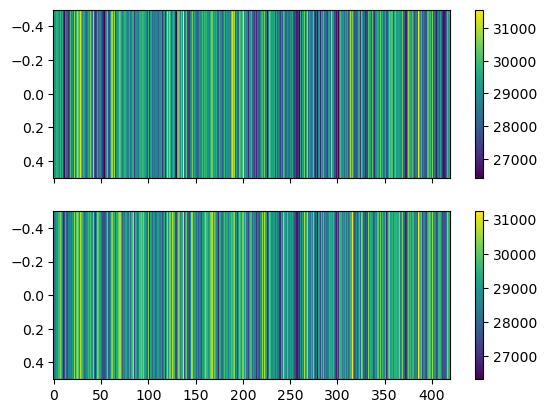

In [616]:
fig,axs = plt.subplots(2,1, sharex=True); axs= axs.flatten()
h = axs[0].imshow((edges_true[:,1:].to(bool).numpy().reshape(-1,edges_true.shape[-1])==True).sum(0)[None], aspect='auto', interpolation='none');
cbar = plt.colorbar(h, ax=axs[0])
h=axs[1].imshow((torch.argmax(edges_b,dim=-1).long().transpose(1,-1).cpu().numpy().reshape(-1,edges_b.shape[1])!=0).sum(0)[None], aspect='auto', interpolation='none', cmap=cbar.cmap);
cbar = plt.colorbar(h, ax=axs[1])

In [617]:
edges_true_ = edges_true[:,1:].long().cpu() # from the second timestep to coincide with predicted because first edges is from non-saved features
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

In [618]:
edges_true_.shape, edges_pred.shape, edges_true_.dtype, edges_pred.dtype

(torch.Size([2000, 49, 420]),
 torch.Size([2000, 49, 420]),
 torch.int64,
 torch.int64)

### Edge predictions

In [625]:
edges_prior  = prior_logits.cpu().detach()
edges_logits = posterior_logits.cpu().detach()

In [ ]:
edges_prior_b, mask = to_dense_batch(edges_prior,edge_feats_batch.cpu())

In [ ]:
edges_prior_b = edges_prior_b.transpose(1,2)

In [ ]:
edges_prior.shape, edges_prior_b.shape

It can happen the encoder classifies an interacting edge with the correct potential learned by the decoder but with the label not matching the arbitrary naming of the edge types.

0.1724629339590793

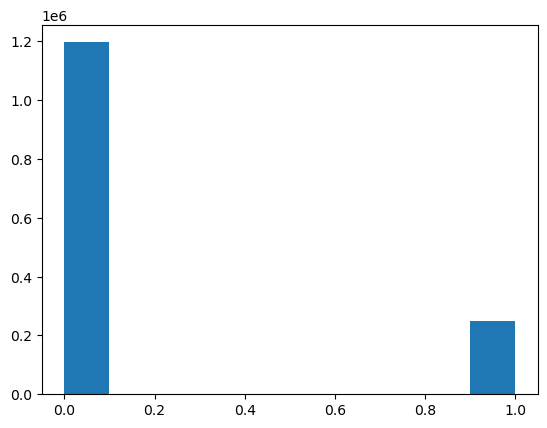

In [868]:
plt.hist(np.argmax(edges_prior_b.numpy(), axis=-1)[edges_true_==1]);np.argmax(edges_prior_b.numpy(), axis=-1)[edges_true_==1].mean()

In [869]:
# renaming edge_types according to the most predicted
print(np.argmax(edges_prior_b.numpy(), axis=-1)[edges_true_==1].mean())
if np.argmax(edges_prior_b.numpy(), axis=-1)[edges_true_==1].mean()> 1.2:
    edges_prior = edges_prior[...,[0,2,1]]
    edges_logits = edges_logits[...,[0,2,1]]

0.1724629339590793


In [ ]:
edges_prior_b, mask = to_dense_batch(edges_prior,edge_feats_batch.cpu())
edges_logits_b, mask = to_dense_batch(edges_logits,edge_feats_batch.cpu())

In [871]:
edges_prior_b = edges_prior_b.transpose(1,2)
edges_logits_b = edges_logits_b.transpose(1,2)

In [872]:
edges_prior.shape, edges_prior_b.shape, edges_logits.shape, edges_logits_b.shape

(torch.Size([84000, 49, 2]),
 torch.Size([200, 49, 420, 2]),
 torch.Size([84000, 49, 2]),
 torch.Size([200, 49, 420, 2]))

In [ ]:
import numpy as np
ep = np.argmax(edges_prior_b.numpy(), axis=-1)
ec = np.argmax(edges_logits_b.numpy(), axis=-1)

In [ ]:
el = np.argmax(torch.nn.functional.gumbel_softmax(edges_logits_b, tau=model.gumbel_temp/2, hard=False,).cpu().numpy(), axis=-1)

In [631]:
edges_t = edges_true_.numpy()

In [ ]:
edges_t.shape, ep.shape, ec.shape, el.shape

In [633]:
edges_b.shape

torch.Size([2000, 420, 49, 2])

In [ ]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True, gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i], edges_b[i,...,edges_order].argmax(-1).T.cpu(), ep[i],ec[i]],
                        ['Ground truth',  'Edges + False','Prior', 'Edges argmax']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_ylabel('Time', rotation=0, ha='right'); axs[0].set_xlabel('Edge\npair');

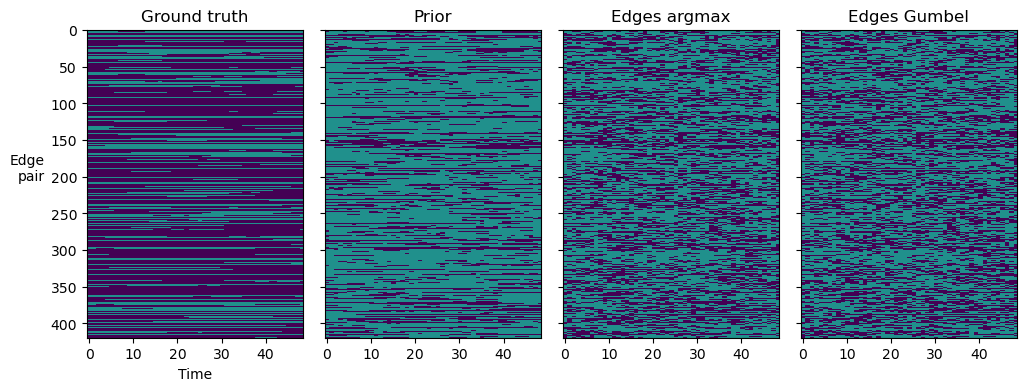

In [342]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,figsize=(12,4), gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i].T, ep[i].T, ec[i].T, el[i].T],
                        ['Ground truth',  'Prior', 'Edges argmax', 'Edges Gumbel']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right');

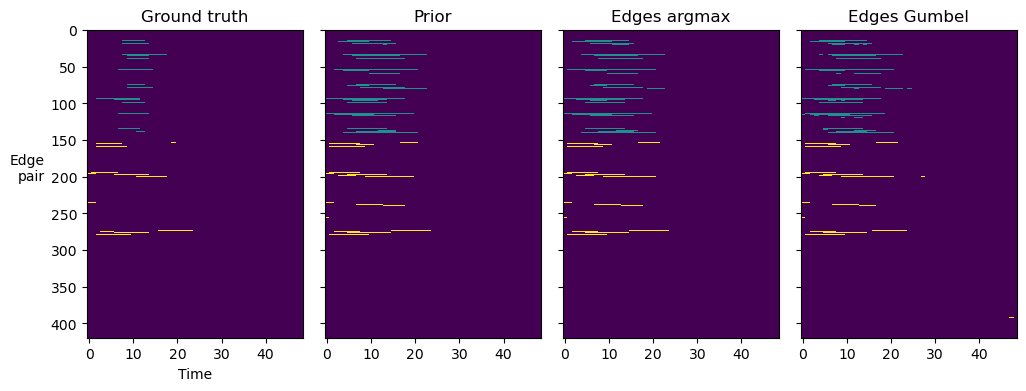

In [241]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,figsize=(12,4), gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i].T, ep[i].T, ec[i].T, el[i].T],
                        ['Ground truth',  'Prior', 'Edges argmax', 'Edges Gumbel']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right');

/tmp/ipykernel_205113/624500231.py:3: UserWarning: Adding colorbar to a different Figure <Figure size 1200x400 with 4 Axes> than <Figure size 1200x400 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(h, ax=axs[-1])


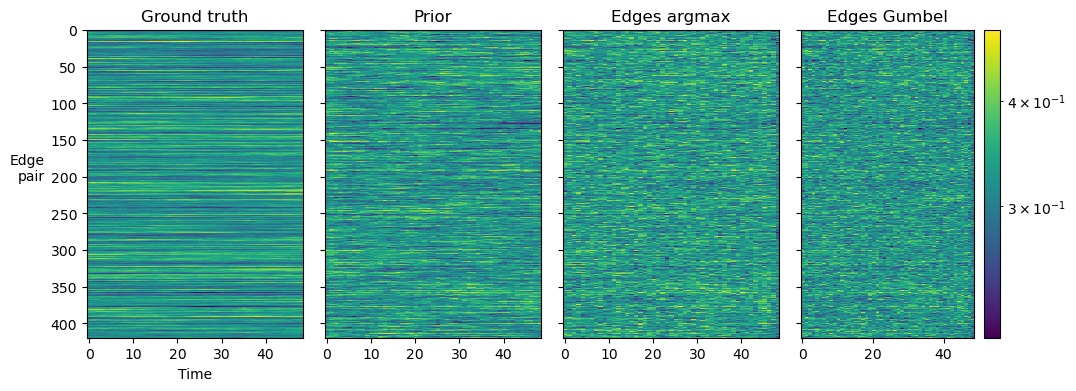

In [343]:
fig, axs = plt.subplots(1,4, sharey=True,figsize=(12,4), gridspec_kw=dict(wspace=0.1))
h = ax.imshow(edges_t.mean(0).T,aspect='auto',norm='log', interpolation='none');  ax.set_title(t);
cbar = plt.colorbar(h, ax=axs[-1])
for ax, x, t in zip(axs,[edges_t.mean(0).T, ep.mean(0).T, ec.mean(0).T, el.mean(0).T],
                        ['Ground truth',  'Prior', 'Edges argmax', 'Edges Gumbel']):
    ax.imshow(x,aspect='auto', cmap=cbar.cmap, interpolation='none');  ax.set_title(t);
axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right');

In [202]:
np.unique(edges_t)

array([0, 1])

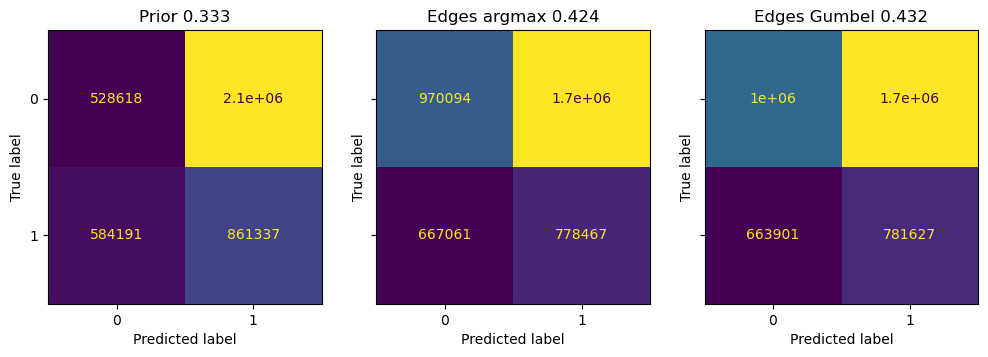

In [344]:
# Confusion matrix: TP, TN, FP, FN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axs = plt.subplots(1,3, sharey=True,sharex=True,
                        figsize=(12,4), gridspec_kw=dict(wspace=0.2))
for  j,(x,l) in enumerate(zip([ep, ec, el],
                        ['Prior', 'Edges argmax', 'Edges Gumbel'])):
    cm = confusion_matrix(edges_t.reshape(-1), x.reshape(-1), )#normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(edges_t), )
    disp.plot(ax=axs[j],colorbar=False,);
    axs[j].set_title(l + f' {f1_score(edges_t.reshape(-1), x.reshape(-1),average="macro"):.3g}')

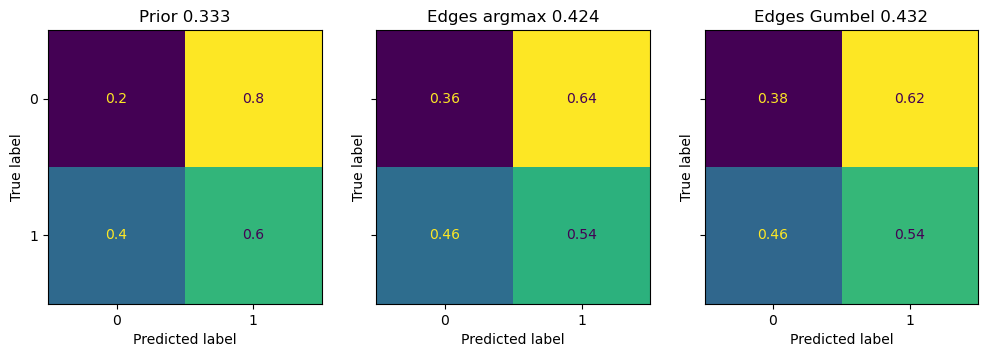

In [345]:
# Confusion matrix: TP, TN, FP, FN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axs = plt.subplots(1,3, sharey=True,sharex=True,
                        figsize=(12,4), gridspec_kw=dict(wspace=0.2))
for  j,(x,l) in enumerate(zip([ep, ec, el],
                        ['Prior', 'Edges argmax', 'Edges Gumbel'])):
    cm = confusion_matrix(edges_t.reshape(-1), x.reshape(-1), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(edges_t), )
    disp.plot(ax=axs[j],colorbar=False,);
    axs[j].set_title(l + f' {f1_score(edges_t.reshape(-1), x.reshape(-1),average="macro"):.3g}')

In [283]:
# # Confusion matrix: TP, TN, FP, FN
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(edges_t.reshape(-1),edges_t.reshape(-1), normalize='all')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2], )
# disp.plot(colorbar=True,);
# plt.title('True' + f' {f1_score(edges_t.reshape(-1), edges_t.reshape(-1),average="macro"):.3g}');

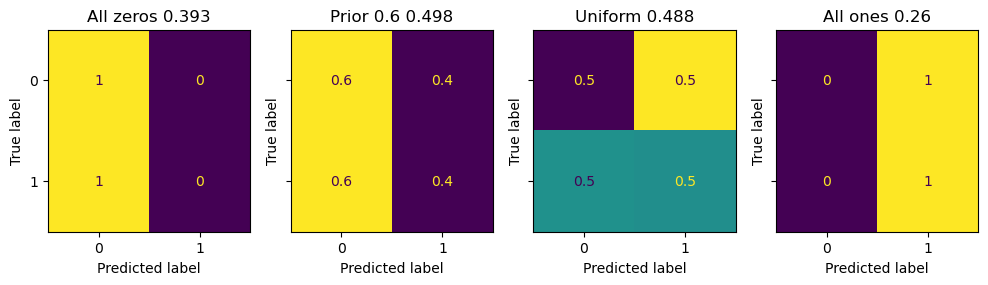

In [206]:
# Confusion matrix: TP, TN, FP, FN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axs = plt.subplots(1,4, sharey=True,sharex=True,
                        figsize=(12,4), gridspec_kw=dict(wspace=0.2))
for  j,(x,l) in enumerate(zip([np.zeros_like(ep),
                               np.random.choice(2, size=ep.shape, p=[0.6, 0.4]),
                               np.random.choice(2, size=ep.shape, p=[1/2]*2),
                               np.ones_like(ep)],
                        ['All zeros', 'Prior 0.6','Uniform','All ones', ])):
    cm = confusion_matrix(edges_t.reshape(-1), x.reshape(-1), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(edges_t), )
    disp.plot(ax=axs[j],colorbar=False);
    axs[j].set_title(l + f' {f1_score(edges_t.reshape(-1), x.reshape(-1), average="macro"):.3g}')

The model is good.

### Posterior logits

In [169]:
posterior_logits.max(), posterior_logits.min(), model.super_gaussians._parameters

(tensor(30.9156, device='cuda:0'),
 tensor(-28.9559, device='cuda:0'),
 OrderedDict([('sigma',
               Parameter containing:
               tensor([0.4001], device='cuda:0', requires_grad=True)),
              ('beta',
               Parameter containing:
               tensor([9.7737], device='cuda:0', requires_grad=True))]))

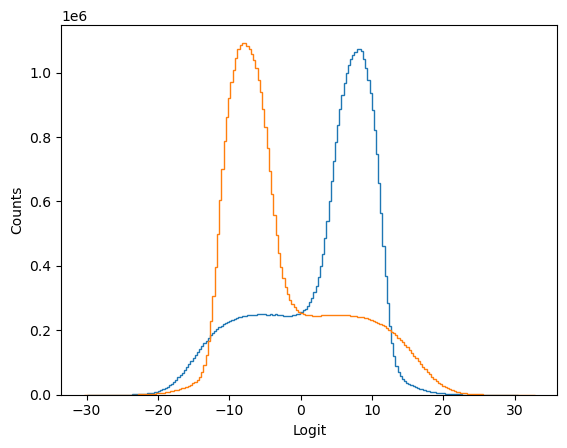

In [415]:
plt.hist(all_posterior_logits.reshape(-1, all_posterior_logits.shape[-1]).cpu().numpy(), 200,histtype='step');
plt.gca().set( xlabel='Logit', ylabel='Counts');

In [171]:
edge_feats[:,:-1,0].shape,all_posterior_logits[...,0].shape

(torch.Size([2000, 419, 3]), torch.Size([840000, 49]))

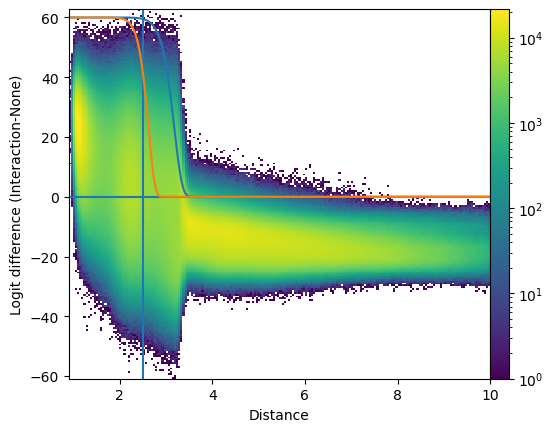

In [173]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,1].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0.9,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(2.5);plt.axhline(0);
sigma = model.super_gaussians._parameters['sigma'].detach().cpu()
beta = model.super_gaussians._parameters['beta'].detach().cpu()
plt.plot(x*ds_train.norm,60*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
sigma = torch.tensor(0.33);    beta = torch.tensor(10.)
plt.plot(x*ds_train.norm,60*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');

In [175]:
print(model.super_gaussians.sigma)
print(model.super_gaussians.beta)

Parameter containing:
tensor([0.4001], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([9.7737], device='cuda:0', requires_grad=True)


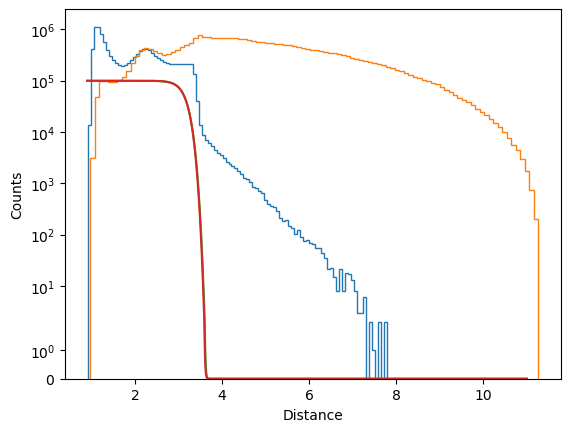

In [416]:
plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(all_posterior_logits.argmax(-1)==1).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(all_posterior_logits.argmax(-1)==0).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
with torch.inference_mode():
    x = torch.linspace(0.9,11,1000)/ds_train.norm
    sigma = model.super_gaussians._parameters['sigma'].cpu()
    beta = model.super_gaussians._parameters['beta'].cpu()
    plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
    sigma = torch.tensor(0.4);    beta = torch.tensor(10.)
    plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
    plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

### edges predictions vs distance

In [330]:
edges_pred.transpose(2,1).shape, edge_feats.shape, np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).shape

(torch.Size([2000, 420, 49]), torch.Size([2000, 420, 50, 3]), (2000, 420, 49))

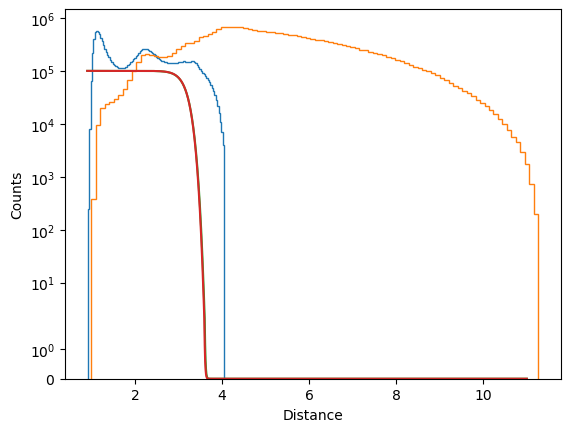

In [321]:
plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==1).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==0).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
with torch.inference_mode():
    x = torch.linspace(0.9,11,1000)/ds_train.norm
    sigma = model.super_gaussians._parameters['sigma'].cpu()
    beta = model.super_gaussians._parameters['beta'].cpu()
    plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
    sigma = torch.tensor(0.4);    beta = torch.tensor(10.)
    plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
    plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

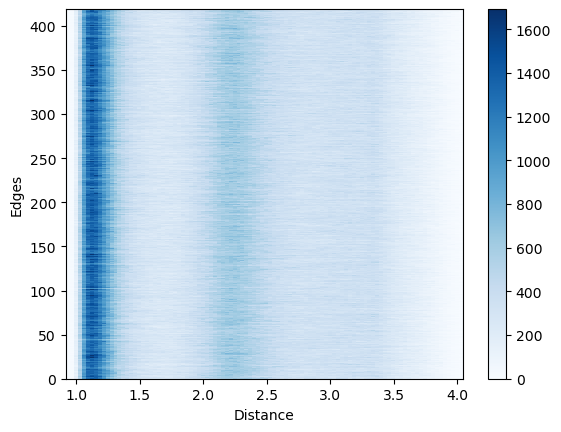

In [348]:
mask_i  = (edges_pred.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_pred.shape[-1]],cmap='Blues',);
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

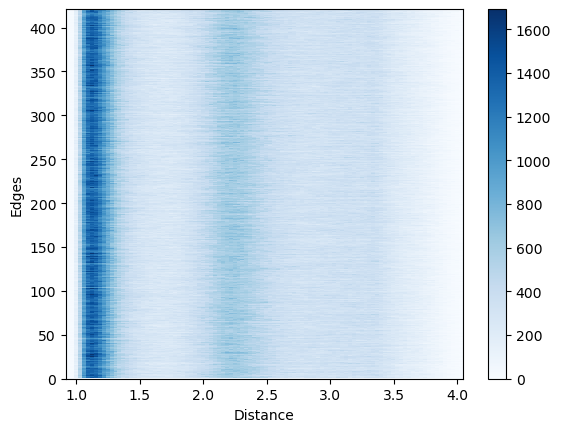

In [350]:
edges_bins = np.arange(edges_pred.shape[-1]+2)
mask_i  = (edges_pred.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = (np.arange(edges_pred.shape[-1])+1)[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_bins],cmap='Blues');
bins_d = h[1]
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

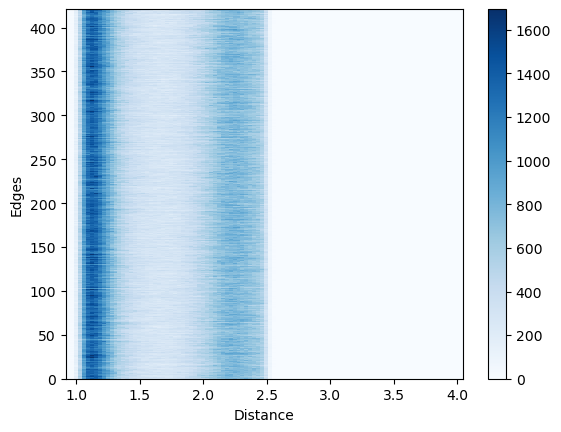

In [351]:
mask_i  = (edges_true_.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[bins_d,edges_bins],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

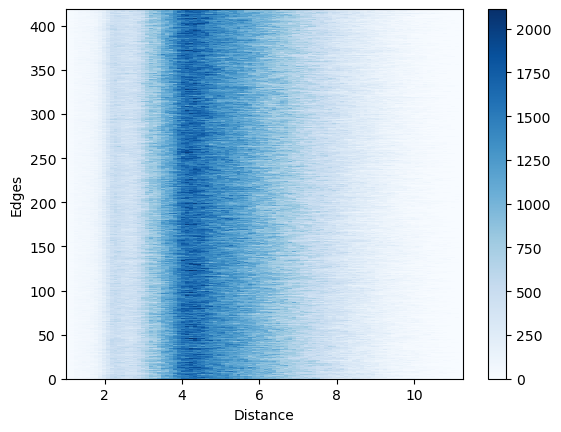

In [343]:
mask_i  = (edges_pred.transpose(2,1)==0).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_pred.shape[-1]],cmap='Blues',);
plt.colorbar()
# plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==0).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
# with torch.inference_mode():
#     x = torch.linspace(0.9,11,1000)/ds_train.norm
#     sigma = model.super_gaussians._parameters['sigma'].cpu()
#     beta = model.super_gaussians._parameters['beta'].cpu()
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     sigma = torch.tensor(0.4);    beta = torch.tensor(10.)
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

# 3 Extraction of forces

## Active force

In [391]:
def active_force(self, n_points=50):
    self.eval()
    dvc = next(self.parameters()).device
    with torch.no_grad():
        ori = torch.linspace(0.,2*3.14159,n_points,device=dvc)[:,None]
        versor = torch.cat([torch.cos(ori),torch.sin(ori),],dim=-1)[:,None]
        node_feats = torch.linspace(0.,0.5,n_points,device=dvc)[None,:,None]*versor  # velocity
        agg_msg_zero = torch.zeros(n_points,n_points,2,device=dvc)
        return ori.cpu().numpy(), self.decoder.node_function(torch.cat([node_feats,agg_msg_zero],
                                                                        dim=-1)).cpu().numpy(), node_feats.cpu().numpy()

In [392]:
ori, delta_active, velocities = active_force(model)

In [393]:
ori.shape, delta_active.shape, velocities.shape

((50, 1), (50, 50, 4), (50, 50, 2))

The input to the node function are velocities and zeros.
The first output are deltas of position scaled by delta of time that take a very similar shape to input velocities. The other output are deltas of velocity and are almost zero. Hence, there is a small active force.

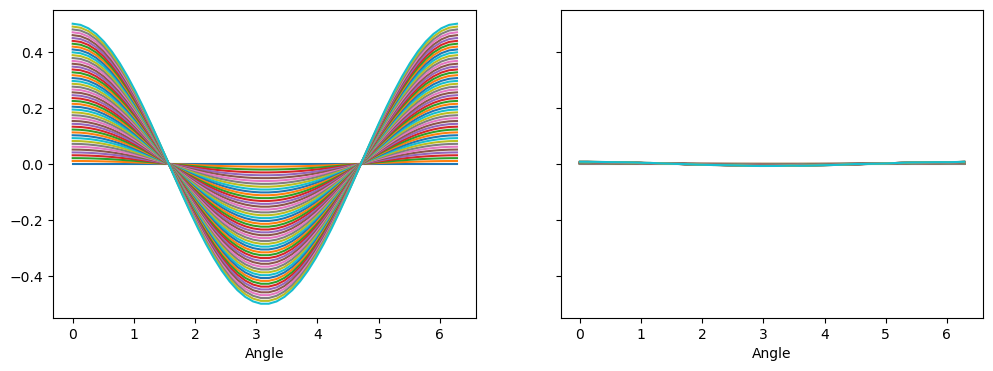

In [394]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, velocities[:,:,0]); # velx
axs[1].plot(ori,delta_active[:,:,0]); # dx
for ax in axs: ax.set(xlabel='Angle',);

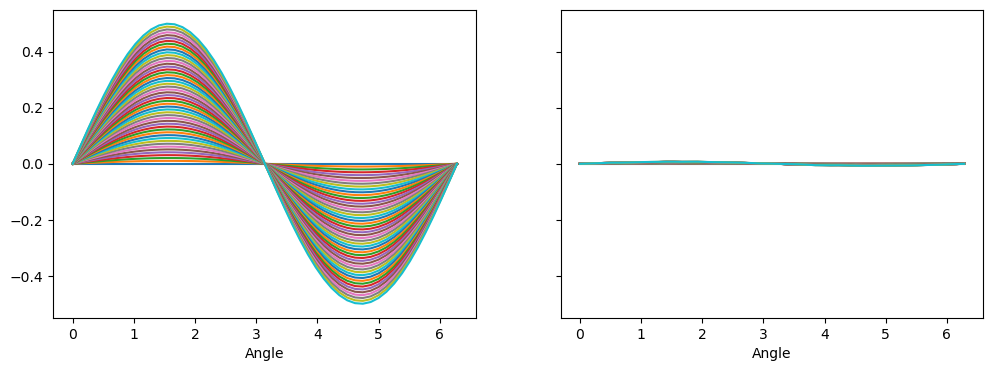

In [395]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, velocities[:,:,1]); # vely
axs[1].plot(ori,delta_active[:,:,1]); # dy
for ax in axs: ax.set(xlabel='Angle',);

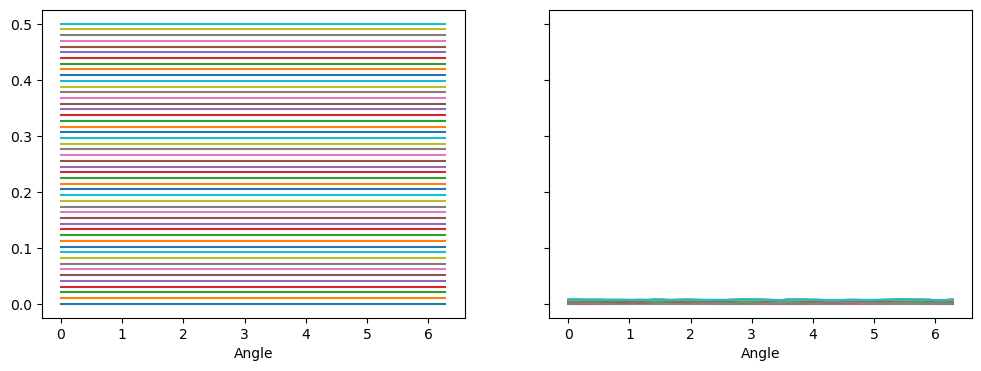

In [396]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, np.hypot(velocities[:,:,0],velocities[:,:,1])); # velx
axs[1].plot(ori, np.hypot(delta_active[:,:,0],delta_active[:,:,1])); # dx
for ax in axs: ax.set(xlabel='Angle',);

The input node_feats are velocities and the first outputs are dx, dy.

Next, the other output is dvx and dvy that are mostly zero.

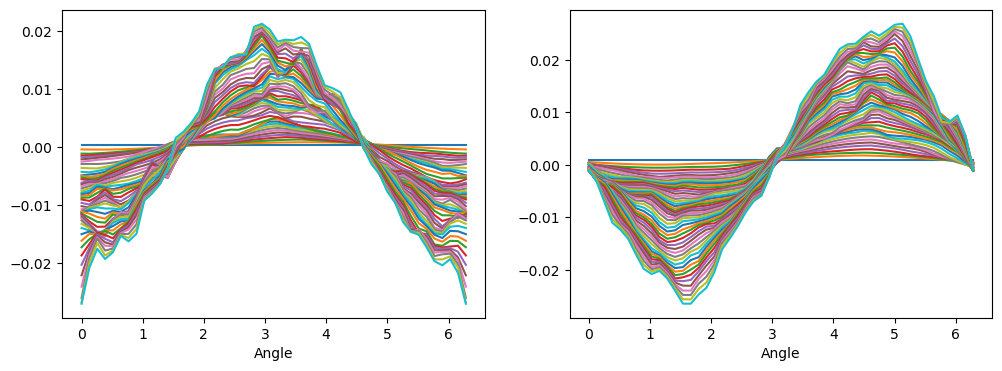

In [397]:
# dv
fig, axs = plt.subplots(1,2, figsize=(12,4));
axs[0].plot(ori,delta_active[:,:,2]); axs[1].plot(ori,delta_active[:,:,3]);
for ax in axs: ax.set(xlabel='Angle',);

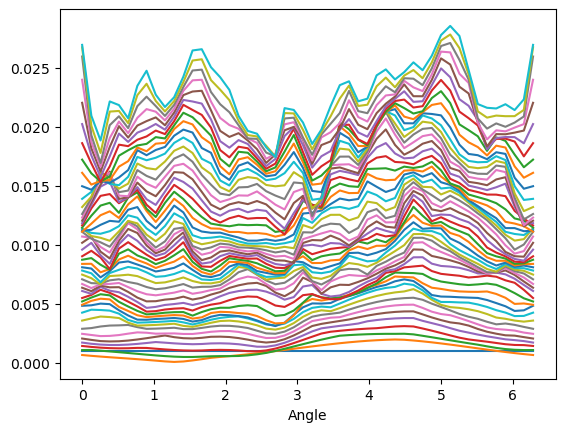

In [398]:
# dv
plt.plot(ori,np.hypot(delta_active[:,:,2],delta_active[:,:,3]));
plt.gca().set( xlabel='Angle',);

## Force magnitude from the messages

Interpreting the message components. As noted in ActiveNet, if the machine learns properly, the message that goes to the node function suffers a linear transformation to become a delta of velocity. Taking advantage of this, we fit the linear transformation and map the messages to forces.

In [399]:
def interparticle_force_modulus(self, d_max=3, n_points=50, j=0,):
    assert j in [0,1]
    self.eval()
    with torch.no_grad():
        train_data = torch.load(os.path.join(params['data_path'], 'train_feats'))
        N = train_data.shape[2]
        # inverted norm
        norm_ = 2./(train_data[:, :, :, :2].max()- train_data[:, :, :, :2].min()).abs() # 0.1
        aggregate_zero = torch.zeros(n_points,N,256)
        distance = torch.linspace(0.01,d_max, n_points)[None,:, None] # 1, n_points, 1
        d = distance*norm_
        alphas = torch.linspace(0,2*3.14159,n_points) # distance versor angle wrt x axis
        ori = torch.linspace(0,2*np.pi,n_points+1,)[:-1,None]
        cos_ori = torch.cos(ori);    sin_ori = torch.sin(ori)
        versor = torch.cat([cos_ori,sin_ori,],dim=-1)[:,None] # n_points,1, 2
        F_inter  = torch.zeros(n_points,n_points, 1) # modulus of N particles at n distances and n alphas
        node_feats = torch.full((n_points,n_points,2),0.04)  # velocity
        edges_ = torch.ones(1,n_points,params['num_edge_types']); # n_points, C=3 edge_types

        # for edge_type...j
        norm_msg  = 1
        start_idx = 1 if model.decoder.skip_first_edge_type else 0
        msg = model.decoder.edge_functions[j](d)*versor # n_points, n_points, 2
        msg = msg*edges_[:,:,j+start_idx:j+start_idx+1]    # <-- Encoder z edges predictions
        msg = msg/norm_msg     # (B,E,O)
        F_active = model.decoder.node_function(torch.cat([node_feats, torch.zeros_like(msg)], dim=-1))
        deltas = model.decoder.node_function(torch.cat([node_feats, msg], dim=-1))
        F_inter = torch.hypot(deltas[...,-1]- F_active[...,-1],
                              deltas[...,-2]- F_active[...,-2])
        assert torch.all(torch.isfinite(F_inter))
    return distance.squeeze(), F_inter.detach().numpy(), deltas, ori, node_feats, msg

In [400]:
dist, f, deltas_a, alphas, node_feats, msg = interparticle_force_modulus(model.cpu(),n_points=300,d_max = 4, j=0)

In [401]:
def force_LJ(d,sigma=1,eps=1,):    return 4*eps*(12*(sigma**12/d**13) - 6*(sigma**6/d**7))
def force_TSLJ(d,r_cut=2.5,sigma=1,eps=1,):    return np.where(d<r_cut, force_LJ(d,sigma,eps=eps), 0)
d_theo = np.linspace(.9,dist.max(),201)
f_theo = force_TSLJ(d_theo)

In [402]:
norm_v = ds_train.norm_v
norm = ds_train.norm

In [403]:
norm_v= norm_v.numpy()
norm = norm.numpy()

In [404]:
delta_t = ds_train.delta_t

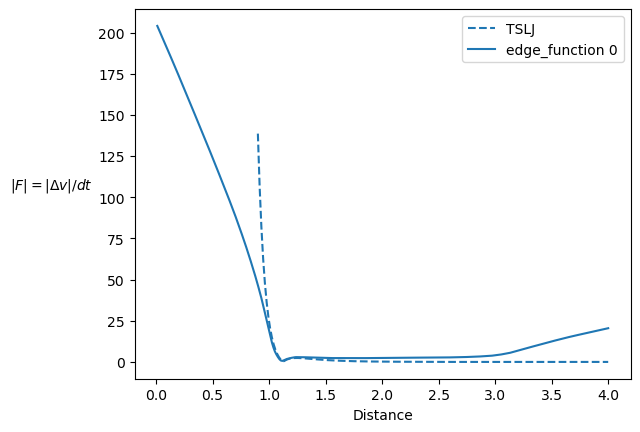

In [405]:
plt.plot(d_theo,np.abs(f_theo), '--', label='TSLJ');
plt.plot(dist,f.mean(0)*norm_v/delta_t, c=f'C0', label=f'edge_function 0');
plt.xlabel('Distance'); plt.ylabel(r'$|F|=|\Delta v|/dt$', rotation=0, ha='right');
plt.legend(ncol=1);

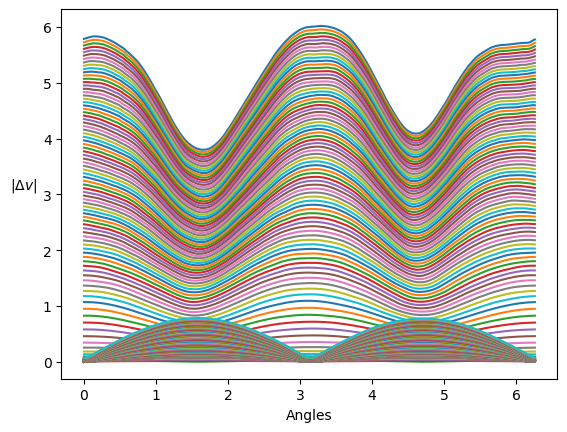

In [406]:
plt.plot(alphas,f*norm_v);plt.xlabel('Angles'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

In [ ]:
plt.plot(d_,np.abs(f_theo), '--', label='TSLJ');
plt.plot(dist,f.T*norm_v/delta_t);plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

## Message linear transformation

In [ ]:
msg.shape, deltas_a.shape

In [ ]:
# Define the two sets of 2D points
X = msg.reshape(-1,2)
Y = deltas_a[...,2:].reshape(-1,2)

# Add a column of ones to X for the bias term
X_homogeneous = np.hstack((X, np.ones((X.shape[0], 1))))

# Compute the linear transformation using least squares
A, residuals, rank, s= np.linalg.lstsq(X_homogeneous, Y, rcond=None)

# Print the linear transformation matrix
print(A)

# Apply the linear transformation to X
transformed_X = np.dot(X_homogeneous, A)

In [408]:
r2 = 1 - residuals / (Y.numpy().size * Y.var().numpy());r2

array([0.99670322, 0.99756292])

In [409]:
A_ = [A,A]

In [410]:
transformed_X.shape

(90000, 2)

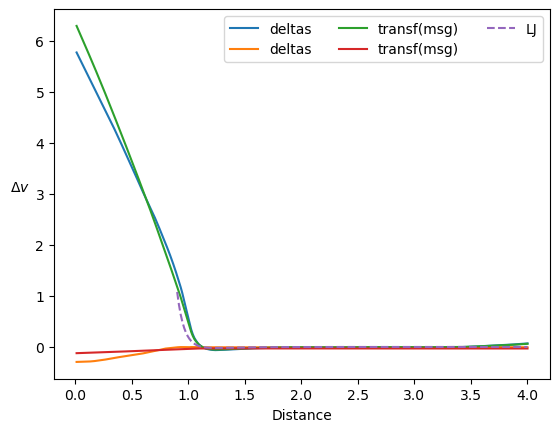

In [411]:
plt.plot(dist,deltas_a[0,:,2:]*norm_v, label='deltas');
plt.plot(dist,transformed_X.reshape(300,300,2)[0]*norm_v, label='transf(msg)');
plt.plot(d_theo,f_theo/norm_v*delta_t, '--', label='LJ');
plt.legend(ncol=3);plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');

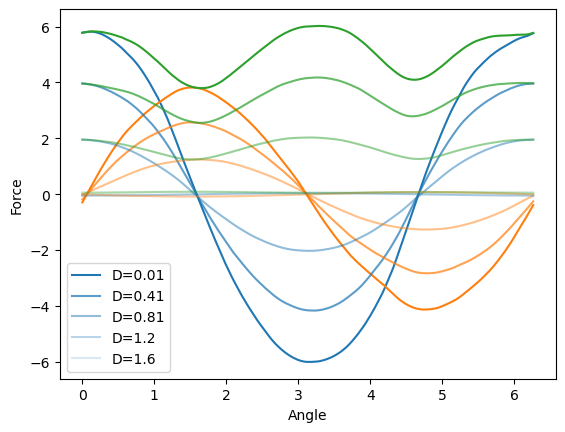

In [412]:
for i in range(0,130,30):
    plt.plot(alphas,deltas_a[:,i,2]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,deltas_a[:,i,3]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,((deltas_a[:,i,2:])**2).sum(-1).sqrt()*norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

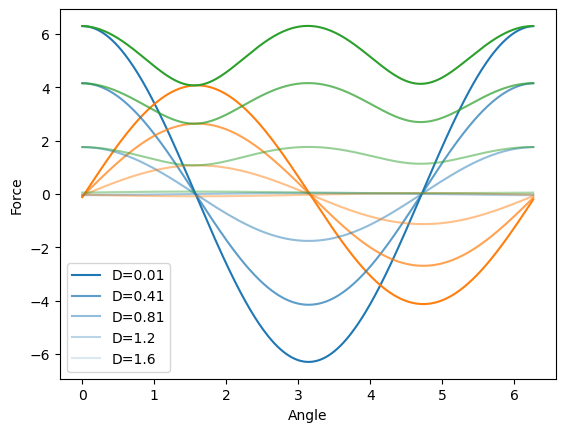

In [413]:
for i in range(0,130,30):
    plt.plot(alphas,transformed_X.reshape(300,300,2)[:,i,0]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,transformed_X.reshape(300,300,2)[:,i,1]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,np.sqrt(((transformed_X.reshape(300,300,2)[:,i,:])**2).sum(-1))*norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

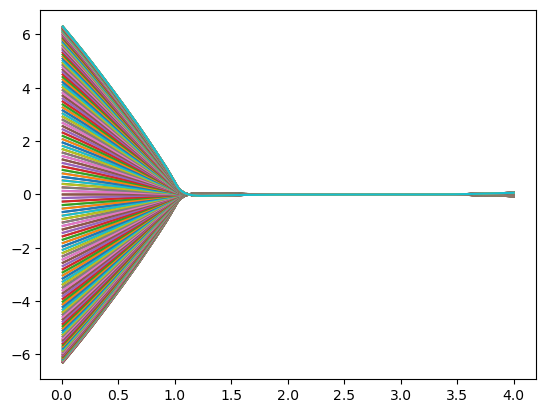

In [414]:
plt.plot(dist,transformed_X.reshape(300,300,2)[:,:,0].T*norm_v);

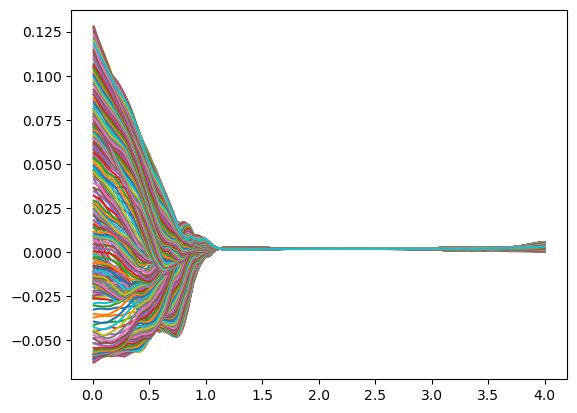

In [415]:
plt.plot(dist,deltas_a[:,:,0].T*norm_v);

There is dependency of the angle.

## Interpret messages and the effect of predicted edges on test samples

for all test inputs:
put msg homogenous to np.dot with A.
Then, multiply by edge prediction.

In [416]:
edges.shape, edges_true.shape

(torch.Size([840000, 49, 2]), torch.Size([2000, 50, 420]))

In [417]:
edge_feats_batch.shape

torch.Size([840000])

In [418]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(test_data.datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_true_ = edges_true[:,:].long().cpu()
edges_b, mask = to_dense_batch(edges, edge_feats_batch)
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

In [419]:
edge_feats_test = get_dv(feats[:,:,:-1], params['sparse'])

In [420]:
edge_feats_test_ = edge_feats_test.transpose(1,2)

In [421]:
node_feats_test_ = node_feats_test[:,:,1:].transpose(1,2)

In [422]:
edges_pred_onehot = F.one_hot(edges_pred)

In [423]:
node_feats_test_.shape, edge_feats_test_.shape, edges_pred.shape, edges_pred_onehot.shape

(torch.Size([2000, 49, 21, 4]),
 torch.Size([2000, 49, 420, 3]),
 torch.Size([2000, 49, 420]),
 torch.Size([2000, 49, 420, 2]))

In [424]:
edge_feats_test_.device, next(model.parameters()).device

(device(type='cpu'), device(type='cpu'))

In [425]:
edge_feats_test_ = edge_feats_test_.cpu()

In [426]:
#  get messages from edge_feats_test
msg = [torch.zeros(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions))
       for i in range(len(model.decoder.edge_functions))]
msg_homo = [torch.zeros(np.prod(edge_feats_test_.shape[:-1]),len(model.decoder.edge_functions)+1)
            for i in range(len(model.decoder.edge_functions))]
msg_transf =[0 for i in range(len(model.decoder.edge_functions))]
msg_f = [0 for i in range(len(model.decoder.edge_functions))]
with torch.no_grad():
    model = model.cpu()
    # msg_norm = 1
    for i in trange(len(model.decoder.edge_functions)):
        msg[i] = model.decoder.edge_functions[i](edge_feats_test_[...,0:1])*edge_feats_test_[...,1:]
        msg[i] = msg[i].reshape(-1,2)
        # Add a column of ones to X for the bias term
        msg_homo[i] = torch.hstack((msg[i], torch.ones((msg[i].shape[0], 1),device=msg[i].device)))
        # Apply the linear transformation to X
        msg_transf[i] = np.dot(msg_homo[i].detach().cpu(), A_[i]).reshape(*edge_feats_test_.shape[:-1],A_[i].shape[-1])

        msg_f[i] = msg_transf[i]*edges_pred_onehot[...,i+1,None].numpy()
torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]

In [427]:
msg_f[0].shape, edge_feats_test_.shape, edges_pred.shape

((2000, 49, 420, 2),
 torch.Size([2000, 49, 420, 3]),
 torch.Size([2000, 49, 420]))

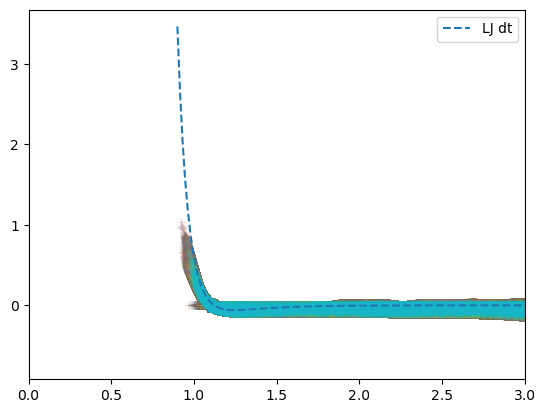

In [428]:
for i in range(edge_feats_test_.shape[2]):
    # know the sign by the product of the force and the distance versors
    p  = msg_transf[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
    # take the max to avoid floating point errors bw components
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    plt.plot(
         edge_feats_test_  [...,i,0:1].reshape(-1,1).cpu().numpy()*norm,
         ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
         '+', alpha=0.1,
        );
plt.plot(d_theo,f_theo*delta_t, '--', label='LJ dt');
plt.xlim(0,3);#plt.ylim(-0.1,0.6)
leg = plt.legend(loc='upper right')

In [ ]:
# edges contributing to message_0
msg_f0_idx = np.unique(np.nonzero(np.abs(msg_f[0])>0.01)[2]); msg_f0_idx

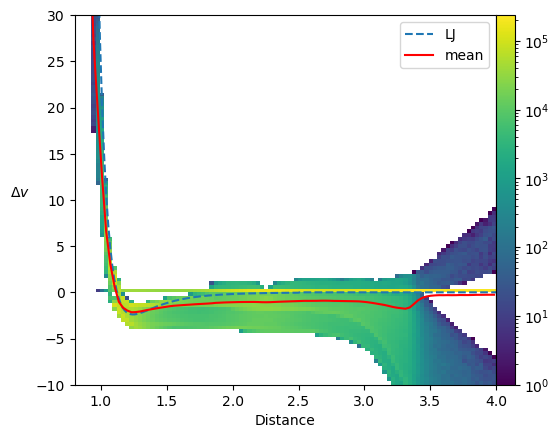

In [434]:
i=msg_f0_idx #49
p  = msg_transf[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

h = plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v/delta_t,
    100, range=[[0.8,4],[-10,30]], norm='log'
    );
plt.colorbar(pad=0);
plt.plot(d_theo,f_theo, '--', label='LJ');

bins = h[1]
from scipy.stats import binned_statistic
xs = edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm
ys = ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v/delta_t
bs = binned_statistic(xs,ys,bins=bins,statistic='mean')

plt.plot(h[1][:-1]+(h[1][1]-h[1][0])/2,bs.statistic, 'r-', label='mean');
plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');
plt.legend();

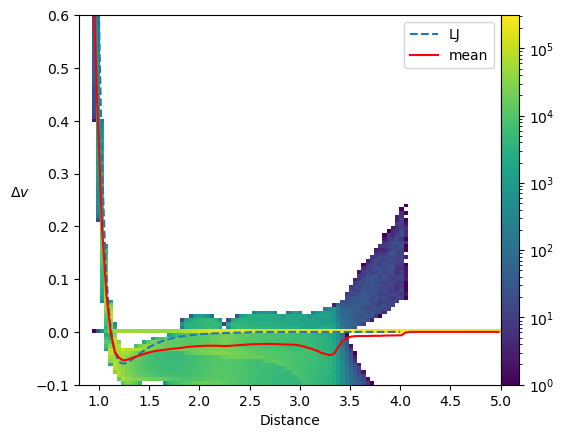

In [431]:
i=msg_f0_idx #49
p  = msg_transf[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

h = plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
    100, range=[[0.8,5],[-.1,.6]], norm='log'
    );
plt.colorbar(pad=0);
plt.plot(d_theo,f_theo*delta_t, '--', label='LJ');

bins = h[1]
from scipy.stats import binned_statistic
xs = edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm
ys = ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v
bs = binned_statistic(xs,ys,bins=bins,statistic='mean')

plt.plot(h[1][:-1]+(h[1][1]-h[1][0])/2,bs.statistic, 'r-', label='mean');
plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');
plt.legend();

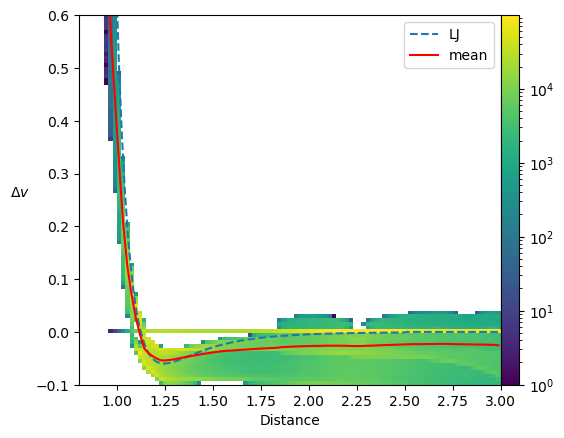

In [430]:
i=msg_f0_idx #49
p  = msg_transf[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

h = plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
    100, range=[[0.8,3],[-.1,.6]], norm='log'
    );
plt.colorbar(pad=0);
plt.plot(d_theo,f_theo*delta_t, '--', label='LJ');

bins = h[1]
from scipy.stats import binned_statistic
xs = edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm
ys = ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v
bs = binned_statistic(xs,ys,bins=bins,statistic='mean')

plt.plot(h[1][:-1]+(h[1][1]-h[1][0])/2,bs.statistic, 'r-', label='mean');
plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');
plt.legend();

In [175]:
torch.cuda.empty_cache()

## clean plot

In [ ]:
params['data_path']

In [436]:
np.savez_compressed("draft/LJ21"+"_forces_msg_noisefree", # edges and msg from test set
                    edges_pred=edges_pred,
                    model_skip_first=model.skip_first,
                    msg_transf=msg_transf, edge_feats_test_=edge_feats_test_,
                    delta_t = ds_train.delta_t,
                    norm=norm, norm_v=norm_v # norm of model's training dataset
                   )

In [441]:
with np.load("draft/LJ21"+"_forces_msg_noisefree"+".npz") as fm:
    edges_pred=fm['edges_pred']
    model_skip_first=fm['model_skip_first']
    msg_transf=fm['msg_transf']
    edge_feats_test_=fm['edge_feats_test_']
    delta_t = fm['delta_t']
    norm=fm['norm']
    norm_v=fm['norm_v']

In [438]:
len(msg_transf)

1

In [439]:
def force_LJ(d,sigma=1,eps=1,):    return 4*eps*(12*(sigma**12/d**13) - 6*(sigma**6/d**7))
def force_TSLJ(d,r_cut=2.5,sigma=1,eps=1,):    return np.where(d<r_cut, force_LJ(d,sigma,eps=eps), 0)
d_theo = np.linspace(.9,dist.max(),201)
f_theo = force_TSLJ(d_theo)

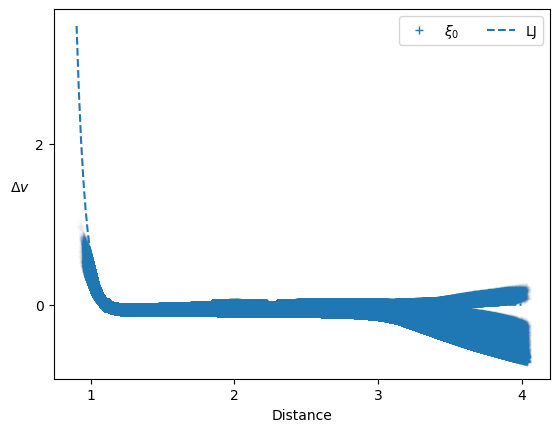

In [183]:
# save/load edges_pred, model.skip_first, msg_transf, edge_feats_test_, norm, norm_v
for i in range(len(msg_transf)):
    mask = edges_pred==model_skip_first+i
    p  = msg_transf[i][mask]*edge_feats_test_[mask][:,1:]
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    plt.plot(edge_feats_test_  [mask][:,0]*norm,
             ps*np.hypot(*msg_transf[i][mask].T)*norm_v,'+',
             alpha=0.01,c=f'C{i}', label=fr'$\xi_{i}$');
plt.plot(d_theo,f_theo*delta_t, '--', label='LJ');

plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');
leg = plt.legend(ncol=2);
for lh in leg.legend_handles:    lh.set_alpha(1)
plt.gca().locator_params(nbins=4);

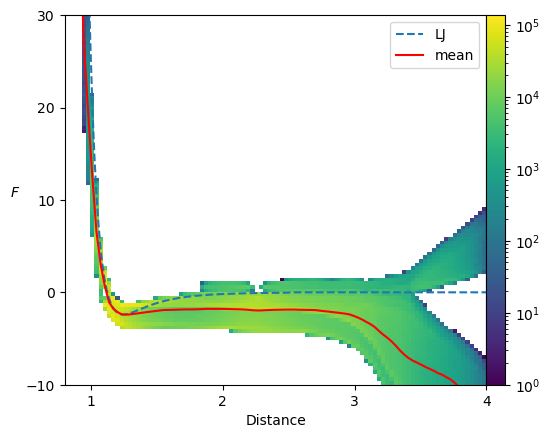

In [209]:
for i in range(len(msg_transf)):
    mask = edges_pred==model_skip_first+i
    p  = msg_transf[i][mask]*edge_feats_test_[mask][:,1:]
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    xs = edge_feats_test_  [mask][:,0].reshape(-1)*norm
    ys = ps*np.hypot(*msg_transf[i][mask].T)*norm_v/delta_t
    # plt.plot(edge_feats_test_  [mask][:,0]*norm,
    #          ps*np.hypot(*msg_transf[i][mask].T)*norm_v,'+',
    #          alpha=0.01,c=f'C{i}', label=fr'$\xi_{i}$');

    h = plt.hist2d(xs,ys,100, range=[[0.8,4],[-10,30]], norm='log');
    plt.colorbar(pad=0);
    plt.plot(d_theo,f_theo, '--', label='LJ');

    bins = h[1]
    from scipy.stats import binned_statistic
    bs = binned_statistic(xs,ys,bins=bins,statistic='mean')

    plt.plot(h[1][:-1]+(h[1][1]-h[1][0])/2,bs.statistic, 'r-', label='mean');
plt.xlabel('Distance'); plt.ylabel(r'$F$', rotation=0, ha='right');
plt.legend(); plt.gca().locator_params(nbins=4);